# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [94]:
# !nvidia-smi

# Download and import required packages

In [95]:
# !pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
# !pip install --upgrade jupyter    

In [96]:
# !git clone https://github.com/pytorch/fairseq.git
# !cd fairseq && git checkout 9a1c497
# !pip install --upgrade ./fairseq/

In [97]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [98]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [99]:
# data_dir = './DATA/rawdata'
# dataset_name = 'ted2020'
# urls = (
#     "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
#     "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
# )
# file_names = (
#     'ted2020.tgz', # train & dev
#     'test.tgz', # test
# )
# prefix = Path(data_dir).absolute() / dataset_name

# prefix.mkdir(parents=True, exist_ok=True)
# for u, f in zip(urls, file_names):
#     path = prefix/f
#     if not path.exists():
#         !wget {u} -O {path}
#     if path.suffix == ".tgz":
#         !tar -xvf {path} -C {prefix}
#     elif path.suffix == ".zip":
#         !unzip -o {path} -d {prefix}
# !mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
# !mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
# !mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
# !mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
# !rm -rf {prefix/'test'}

## Language

In [100]:
# src_lang = 'en'
# tgt_lang = 'zh'

# data_prefix = f'{prefix}/train_dev.raw'
# test_prefix = f'{prefix}/test.raw'

In [101]:
# !head {data_prefix+'.'+src_lang} -n 5
# !head {data_prefix+'.'+tgt_lang} -n 5

## Preprocess files

In [102]:
# import re

# def strQ2B(ustring):
#     """Full width -> half width"""
#     # reference:https://ithelp.ithome.com.tw/articles/10233122
#     ss = []
#     for s in ustring:
#         rstring = ""
#         for uchar in s:
#             inside_code = ord(uchar)
#             if inside_code == 12288:  # Full width space: direct conversion
#                 inside_code = 32
#             elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
#                 inside_code -= 65248
#             rstring += chr(inside_code)
#         ss.append(rstring)
#     return ''.join(ss)
                
# def clean_s(s, lang):
#     if lang == 'en':
#         s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
#         s = s.replace('-', '') # remove '-'
#         s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
#     elif lang == 'zh':
#         s = strQ2B(s) # Q2B
#         s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
#         s = s.replace(' ', '')
#         s = s.replace('—', '')
#         s = s.replace('“', '"')
#         s = s.replace('”', '"')
#         s = s.replace('_', '')
#         s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
#     s = ' '.join(s.strip().split())
#     return s

# def len_s(s, lang):
#     if lang == 'zh':
#         return len(s)
#     return len(s.split())

# def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
#     if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
#         print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
#         return
#     with open(f'{prefix}.{l1}', 'r') as l1_in_f:
#         with open(f'{prefix}.{l2}', 'r') as l2_in_f:
#             with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
#                 with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
#                     for s1 in l1_in_f:
#                         s1 = s1.strip()
#                         s2 = l2_in_f.readline().strip()
#                         s1 = clean_s(s1, l1)
#                         s2 = clean_s(s2, l2)
#                         s1_len = len_s(s1, l1)
#                         s2_len = len_s(s2, l2)
#                         if min_len > 0: # remove short sentence
#                             if s1_len < min_len or s2_len < min_len:
#                                 continue
#                         if max_len > 0: # remove long sentence
#                             if s1_len > max_len or s2_len > max_len:
#                                 continue
#                         if ratio > 0: # remove by ratio of length
#                             if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
#                                 continue
#                         print(s1, file=l1_out_f)
#                         print(s2, file=l2_out_f)

In [103]:
# clean_corpus(data_prefix, src_lang, tgt_lang)
# clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [104]:
# !head {data_prefix+'.clean.'+src_lang} -n 5
# !head {data_prefix+'.clean.'+tgt_lang} -n 5

## Split into train/valid

In [105]:
# valid_ratio = 0.01 # 3000~4000 would suffice
# train_ratio = 1 - valid_ratio

In [106]:
# if (prefix/f'train.clean.{src_lang}').exists() \
# and (prefix/f'train.clean.{tgt_lang}').exists() \
# and (prefix/f'valid.clean.{src_lang}').exists() \
# and (prefix/f'valid.clean.{tgt_lang}').exists():
#     print(f'train/valid splits exists. skipping split.')
# else:
#     line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
#     labels = list(range(line_num))
#     random.shuffle(labels)
#     for lang in [src_lang, tgt_lang]:
#         train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
#         valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
#         count = 0
#         for line in open(f'{data_prefix}.clean.{lang}', 'r'):
#             if labels[count]/line_num < train_ratio:
#                 train_f.write(line)
#             else:
#                 valid_f.write(line)
#             count += 1
#         train_f.close()
#         valid_f.close()

## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [107]:
# import sentencepiece as spm
# vocab_size = 8000
# if (prefix/f'spm{vocab_size}.model').exists():
#     print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
# else:
#     spm.SentencePieceTrainer.train(
#         input=','.join([f'{prefix}/train.clean.{src_lang}',
#                         f'{prefix}/valid.clean.{src_lang}',
#                         f'{prefix}/train.clean.{tgt_lang}',
#                         f'{prefix}/valid.clean.{tgt_lang}']),
#         model_prefix=prefix/f'spm{vocab_size}',
#         vocab_size=vocab_size,
#         character_coverage=1,
#         model_type='unigram', # 'bpe' works as well
#         input_sentence_size=1e6,
#         shuffle_input_sentence=True,
#         normalization_rule_name='nmt_nfkc_cf',
#     )

In [108]:
# spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
# in_tag = {
#     'train': 'train.clean',
#     'valid': 'valid.clean',
#     'test': 'test.raw.clean',
# }
# for split in ['train', 'valid', 'test']:
#     for lang in [src_lang, tgt_lang]:
#         out_path = prefix/f'{split}.{lang}'
#         if out_path.exists():
#             print(f"{out_path} exists. skipping spm_encode.")
#         else:
#             with open(prefix/f'{split}.{lang}', 'w') as out_f:
#                 with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
#                     for line in in_f:
#                         line = line.strip()
#                         tok = spm_model.encode(line, out_type=str)
#                         print(' '.join(tok), file=out_f)

In [109]:
# !head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
# !head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

## Binarize the data with fairseq

In [110]:
# binpath = Path('./DATA/data-bin', dataset_name)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess \
#         --source-lang {src_lang}\
#         --target-lang {tgt_lang}\
#         --trainpref {prefix/'train'}\
#         --validpref {prefix/'valid'}\
#         --testpref {prefix/'test'}\
#         --destdir {binpath}\
#         --joined-dictionary\
#         --workers 2

# Configuration for experiments

In [111]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=300,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [112]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [113]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2022-04-03 01:08:10 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-04-03 01:08:10 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 9.999 GB ; name = NVIDIA GeForce RTX 3080                 
2022-04-03 01:08:10 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [114]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-04-03 01:08:10 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2022-04-03 01:08:10 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [115]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-04-03 01:08:10 | INFO | hw5.seq2seq | loading data for epoch 1
2022-04-03 01:08:10 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2022-04-03 01:08:10 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2022-04-03 01:08:10 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2022-04-03 01:08:10 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2022-04-03 01:08:10 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2022-04-03 01:08:10 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [116]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2]),
 'target': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [117]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-04-03 01:08:11 | WARNING | fairseq.tasks.fairseq_task | 2,532 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 135, 2444, 3058, 682, 731, 235, 1558, 3383, 559]


{'id': tensor([723]),
 'nsentences': 1,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,   18,   26,   82,    8,  480,   15,  651,
           1361,   38,    6,  176, 2696,   39,    5,  822,   92,  260,    7,    2]]),
  'src_lengths': tensor([19]),
  'prev_output_tokens': tensor([[   2,  140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,
            151, 2691,    9,  215, 1680,   10,    1,    1,    1,    1,    1,    1]])},
 'target': tensor([[ 140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,  151,
          2691,    9,  215, 1680,   10,    2,    1,    1,    1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [118]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

# Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_layers is the number of layers for Encoder RNN
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask. 
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs: 
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2 
- Outputs: 
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [119]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [120]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

# Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs: 
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2 
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs: 
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [121]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [122]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [123]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: switch to TransformerEncoder & TransformerDecoder
    # encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [124]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=1,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=1,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [125]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [126]:
model = build_model(arch_args, task)
logger.info(model)

2022-04-03 01:08:12 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [127]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [128]:
def get_rate(d_model, step_num, warmup_step):
    # lr = 0.001
    # Change lr from constant to the equation shown above
    lr = d_model**-0.5 * min(step_num**-0.5, step_num*warmup_step**-1.5)
    return lr

In [129]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

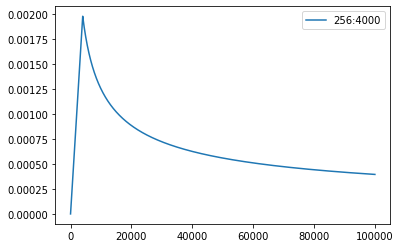

In [130]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [131]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [132]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [133]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [134]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [135]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [136]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-04-03 01:08:14 | INFO | hw5.seq2seq | task: TranslationTask
2022-04-03 01:08:14 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-04-03 01:08:14 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-04-03 01:08:14 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-04-03 01:08:14 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-04-03 01:08:14 | INFO | hw5.seq2seq | num. model params: 5,677,568 (num. trained: 5,677,568)
2022-04-03 01:08:14 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [137]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-04-03 01:08:14 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2022-04-03 01:08:14 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/checkpoint_last.pt: step=11697 loss=4.267194747924805 bleu=15.171087108884214


train epoch 1:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:09:39 | INFO | hw5.seq2seq | training loss: 4.4621
2022-04-03 01:09:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

/home/spiderkiller/miniconda3/envs/ml_hw5/lib/python3.7/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/spiderkiller/miniconda3/envs/ml_hw5/lib/python3.7/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_id

2022-04-03 01:10:03 | INFO | hw5.seq2seq | example source: but the point is , it doesn't feel that way .
2022-04-03 01:10:03 | INFO | hw5.seq2seq | example hypothesis: 但重點是 , 它並不感覺 。
2022-04-03 01:10:03 | INFO | hw5.seq2seq | example reference: 但重點是 , 感覺起來卻不是那麼回事呀
2022-04-03 01:10:03 | INFO | hw5.seq2seq | validation loss:	4.2667
2022-04-03 01:10:03 | INFO | hw5.seq2seq | BLEU = 15.53 50.7/25.2/13.2/7.3 (BP = 0.829 ratio = 0.842 hyp_len = 94173 ref_len = 111811)
2022-04-03 01:10:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint1.pt
2022-04-03 01:10:03 | INFO | hw5.seq2seq | end of epoch 1


train epoch 2:   0%|          | 0/791 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5c189aa70>
Traceback (most recent call last):
  File "/home/spiderkiller/miniconda3/envs/ml_hw5/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/spiderkiller/miniconda3/envs/ml_hw5/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/spiderkiller/miniconda3/envs/ml_hw5/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5c189aa70>
Traceback (most recent call last):
  File "/home/spiderkiller/miniconda3/envs/ml_hw5/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/spiderkille

2022-04-03 01:11:28 | INFO | hw5.seq2seq | training loss: 4.4506
2022-04-03 01:11:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:11:55 | INFO | hw5.seq2seq | example source: we can push through that .
2022-04-03 01:11:55 | INFO | hw5.seq2seq | example hypothesis: 我們可以透過這一點 。
2022-04-03 01:11:55 | INFO | hw5.seq2seq | example reference: 我們可以衝破這些限制 。
2022-04-03 01:11:55 | INFO | hw5.seq2seq | validation loss:	4.2517
2022-04-03 01:11:55 | INFO | hw5.seq2seq | BLEU = 15.41 50.5/25.1/13.3/7.3 (BP = 0.822 ratio = 0.836 hyp_len = 93443 ref_len = 111811)
2022-04-03 01:11:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint2.pt
2022-04-03 01:11:55 | INFO | hw5.seq2seq | end of epoch 2


train epoch 3:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:13:22 | INFO | hw5.seq2seq | training loss: 4.4421
2022-04-03 01:13:22 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:13:47 | INFO | hw5.seq2seq | example source: thank you .
2022-04-03 01:13:47 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2022-04-03 01:13:47 | INFO | hw5.seq2seq | example reference: 謝謝 。
2022-04-03 01:13:47 | INFO | hw5.seq2seq | validation loss:	4.2329
2022-04-03 01:13:47 | INFO | hw5.seq2seq | BLEU = 16.35 47.4/23.5/12.3/6.8 (BP = 0.937 ratio = 0.939 hyp_len = 104981 ref_len = 111811)
2022-04-03 01:13:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint3.pt
2022-04-03 01:13:48 | INFO | hw5.seq2seq | end of epoch 3


train epoch 4:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:15:13 | INFO | hw5.seq2seq | training loss: 4.4320
2022-04-03 01:15:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:15:41 | INFO | hw5.seq2seq | example source: those men would eventually be convicted of placing a van filled with 1 , 500 pounds of explosives into the sublevel parking lot of the world trade center's north tower , causing an explosion that killed six people and injured over 1 , 000 others .
2022-04-03 01:15:41 | INFO | hw5.seq2seq | example hypothesis: 那些男人最終被告知 , 把一千五百磅的探索 , 在南方 , 有一千五百磅的探索中心 , 將許多世界貿易中心的探索中心 , 將殺害六個人和傷了一千磅 。
2022-04-03 01:15:41 | INFO | hw5.seq2seq | example reference: 這群男人最終被指控將滿載1500磅重的炸彈的廂式貨車停在世界貿易中心北塔的地下停車場 , 爆炸造成6人死亡 , 同時致使超過1000人受傷 。
2022-04-03 01:15:41 | INFO | hw5.seq2seq | validation loss:	4.2161
2022-04-03 01:15:41 | INFO | hw5.seq2seq | BLEU = 16.10 48.0/23.8/12.5/6.8 (BP = 0.912 ratio = 0.915 hyp_len = 102337 ref_len = 111811)
2022-04-03 01:15:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint4.pt
2022-04-03 01:15:41 | INFO | hw5.seq2seq | end of epoch 4


train epoch 5:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:17:09 | INFO | hw5.seq2seq | training loss: 4.4186
2022-04-03 01:17:09 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:17:34 | INFO | hw5.seq2seq | example source: but this is really how i go about creating these photographs .
2022-04-03 01:17:34 | INFO | hw5.seq2seq | example hypothesis: 但這是我要如何在創造這些照片中 。
2022-04-03 01:17:34 | INFO | hw5.seq2seq | example reference: 但是我真的是這樣做出這些相片的 。
2022-04-03 01:17:34 | INFO | hw5.seq2seq | validation loss:	4.2099
2022-04-03 01:17:34 | INFO | hw5.seq2seq | BLEU = 16.74 46.9/23.1/12.1/6.7 (BP = 0.971 ratio = 0.972 hyp_len = 108664 ref_len = 111811)
2022-04-03 01:17:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint5.pt
2022-04-03 01:17:34 | INFO | hw5.seq2seq | end of epoch 5


train epoch 6:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:19:00 | INFO | hw5.seq2seq | training loss: 4.4112
2022-04-03 01:19:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:19:26 | INFO | hw5.seq2seq | example source: so that is a fact .
2022-04-03 01:19:26 | INFO | hw5.seq2seq | example hypothesis: 這是事實 。
2022-04-03 01:19:26 | INFO | hw5.seq2seq | example reference: 這就是事實
2022-04-03 01:19:26 | INFO | hw5.seq2seq | validation loss:	4.2115
2022-04-03 01:19:26 | INFO | hw5.seq2seq | BLEU = 16.49 49.4/24.6/13.0/7.2 (BP = 0.898 ratio = 0.903 hyp_len = 100941 ref_len = 111811)
2022-04-03 01:19:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint6.pt
2022-04-03 01:19:26 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:20:51 | INFO | hw5.seq2seq | training loss: 4.4064
2022-04-03 01:20:51 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:21:18 | INFO | hw5.seq2seq | example source: thank you so much everyone .
2022-04-03 01:21:18 | INFO | hw5.seq2seq | example hypothesis: 謝謝大家
2022-04-03 01:21:18 | INFO | hw5.seq2seq | example reference: 謝謝大家 !
2022-04-03 01:21:18 | INFO | hw5.seq2seq | validation loss:	4.1964
2022-04-03 01:21:18 | INFO | hw5.seq2seq | BLEU = 15.74 49.9/24.8/13.1/7.2 (BP = 0.852 ratio = 0.862 hyp_len = 96367 ref_len = 111811)
2022-04-03 01:21:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint7.pt
2022-04-03 01:21:18 | INFO | hw5.seq2seq | end of epoch 7


train epoch 8:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:22:43 | INFO | hw5.seq2seq | training loss: 4.3987
2022-04-03 01:22:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:23:11 | INFO | hw5.seq2seq | example source: these differences became a source of inspired artistic celebration .
2022-04-03 01:23:11 | INFO | hw5.seq2seq | example hypothesis: 這些差異變得很大 。
2022-04-03 01:23:11 | INFO | hw5.seq2seq | example reference: 這些差異變成了一個源頭 , 富有靈感之藝術讚頌的源頭 。
2022-04-03 01:23:11 | INFO | hw5.seq2seq | validation loss:	4.1956
2022-04-03 01:23:11 | INFO | hw5.seq2seq | BLEU = 15.83 49.7/24.8/13.2/7.3 (BP = 0.851 ratio = 0.861 hyp_len = 96324 ref_len = 111811)
2022-04-03 01:23:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint8.pt
2022-04-03 01:23:11 | INFO | hw5.seq2seq | end of epoch 8


train epoch 9:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:24:37 | INFO | hw5.seq2seq | training loss: 4.3942
2022-04-03 01:24:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:25:04 | INFO | hw5.seq2seq | example source: it's not .
2022-04-03 01:25:04 | INFO | hw5.seq2seq | example hypothesis: 這不是 。
2022-04-03 01:25:04 | INFO | hw5.seq2seq | example reference: 不是
2022-04-03 01:25:04 | INFO | hw5.seq2seq | validation loss:	4.1956
2022-04-03 01:25:04 | INFO | hw5.seq2seq | BLEU = 16.29 49.2/24.4/12.8/7.1 (BP = 0.897 ratio = 0.902 hyp_len = 100884 ref_len = 111811)
2022-04-03 01:25:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint9.pt
2022-04-03 01:25:05 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:26:29 | INFO | hw5.seq2seq | training loss: 4.3876
2022-04-03 01:26:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:26:53 | INFO | hw5.seq2seq | example source: so think about when you have friends , families and coworkers in california , on the west coast or in other parts of the world .
2022-04-03 01:26:53 | INFO | hw5.seq2seq | example hypothesis: 所以想想看 , 當你有朋友時 , 家庭和牛津的西方 , 在加州或其他地區的其他部分 。
2022-04-03 01:26:53 | INFO | hw5.seq2seq | example reference: 所以 , 想像當你嘗試聯繫在加州 , 在西海岸或者在世界的另一面
2022-04-03 01:26:53 | INFO | hw5.seq2seq | validation loss:	4.1827
2022-04-03 01:26:53 | INFO | hw5.seq2seq | BLEU = 16.02 50.5/25.3/13.4/7.4 (BP = 0.848 ratio = 0.859 hyp_len = 96006 ref_len = 111811)
2022-04-03 01:26:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint10.pt
2022-04-03 01:26:54 | INFO | hw5.seq2seq | end of epoch 10


train epoch 11:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:28:20 | INFO | hw5.seq2seq | training loss: 4.3841
2022-04-03 01:28:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:28:47 | INFO | hw5.seq2seq | example source: and i was asked to move out because one of my roommates had shared my status with her parents .
2022-04-03 01:28:47 | INFO | hw5.seq2seq | example hypothesis: 我被要求搬出去 , 因為我的房間和她的父母分享我的信任之一 。
2022-04-03 01:28:47 | INFO | hw5.seq2seq | example reference: 我會被要求搬出去 , 是因為其中一名室友和她的父母談了我的狀況 。
2022-04-03 01:28:47 | INFO | hw5.seq2seq | validation loss:	4.1845
2022-04-03 01:28:47 | INFO | hw5.seq2seq | BLEU = 16.45 50.0/24.9/13.2/7.4 (BP = 0.881 ratio = 0.887 hyp_len = 99229 ref_len = 111811)
2022-04-03 01:28:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint11.pt
2022-04-03 01:28:47 | INFO | hw5.seq2seq | end of epoch 11


train epoch 12:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:30:11 | INFO | hw5.seq2seq | training loss: 4.3811
2022-04-03 01:30:11 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:30:35 | INFO | hw5.seq2seq | example source: and i want to share with you a quick video from our facility that gives you a sense of how this looks at scale .
2022-04-03 01:30:35 | INFO | hw5.seq2seq | example hypothesis: 我想跟各位分享一個很快的影片 , 給你們看一下這個看法有多大 。
2022-04-03 01:30:35 | INFO | hw5.seq2seq | example reference: 我想與你們快速分享一段關於我們設備的影片可以瞭解一下它的規模
2022-04-03 01:30:35 | INFO | hw5.seq2seq | validation loss:	4.1781
2022-04-03 01:30:35 | INFO | hw5.seq2seq | BLEU = 16.62 49.6/24.8/13.1/7.3 (BP = 0.898 ratio = 0.903 hyp_len = 100927 ref_len = 111811)
2022-04-03 01:30:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint12.pt
2022-04-03 01:30:35 | INFO | hw5.seq2seq | end of epoch 12


train epoch 13:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:32:00 | INFO | hw5.seq2seq | training loss: 4.3766
2022-04-03 01:32:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:32:27 | INFO | hw5.seq2seq | example source: it's a distinction perhaps we might make between two nobel laureates , richard feynman and john nash .
2022-04-03 01:32:27 | INFO | hw5.seq2seq | example hypothesis: 或許我們可能在兩個諾貝爾曼和約翰納納德曼和約翰納納納什 。
2022-04-03 01:32:27 | INFO | hw5.seq2seq | example reference: 我們或許可以從兩位諾貝爾獎得主 , 理查費曼和約翰奈許之間看出這樣的差異 。
2022-04-03 01:32:27 | INFO | hw5.seq2seq | validation loss:	4.1791
2022-04-03 01:32:27 | INFO | hw5.seq2seq | BLEU = 16.08 50.3/25.3/13.3/7.3 (BP = 0.856 ratio = 0.865 hyp_len = 96768 ref_len = 111811)
2022-04-03 01:32:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint13.pt
2022-04-03 01:32:27 | INFO | hw5.seq2seq | end of epoch 13


train epoch 14:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:33:54 | INFO | hw5.seq2seq | training loss: 4.3734
2022-04-03 01:33:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:34:20 | INFO | hw5.seq2seq | example source: and therein lie the words of wisdom of a young girl whose brief life forever impacted mine .
2022-04-03 01:34:20 | INFO | hw5.seq2seq | example hypothesis: 有一個有謊言的年輕女孩 , 永遠影響了我的生活的年輕女孩 , 永遠影響我 。
2022-04-03 01:34:20 | INFO | hw5.seq2seq | example reference: 她說的話對我有很大啟發 。 這一個年幼女孩短暫的一生永遠影響著我 。
2022-04-03 01:34:20 | INFO | hw5.seq2seq | validation loss:	4.1758
2022-04-03 01:34:20 | INFO | hw5.seq2seq | BLEU = 16.17 50.4/25.1/13.3/7.3 (BP = 0.862 ratio = 0.871 hyp_len = 97381 ref_len = 111811)
2022-04-03 01:34:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint14.pt
2022-04-03 01:34:20 | INFO | hw5.seq2seq | end of epoch 14


train epoch 15:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:35:46 | INFO | hw5.seq2seq | training loss: 4.3734
2022-04-03 01:35:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:36:11 | INFO | hw5.seq2seq | example source: and we've started making curtains , and not only is it beautiful , but people can see status that you care about your children .
2022-04-03 01:36:11 | INFO | hw5.seq2seq | example hypothesis: 我們開始做曲線 , 不僅是美麗的 , 但人們可以看到你的孩子 。
2022-04-03 01:36:11 | INFO | hw5.seq2seq | example reference: 我們也開始生産窗簾不止因爲窗簾看起來漂亮 , 人們也可以看到你的地位看得出你很關心小孩
2022-04-03 01:36:11 | INFO | hw5.seq2seq | validation loss:	4.1810
2022-04-03 01:36:11 | INFO | hw5.seq2seq | BLEU = 16.15 51.0/25.6/13.7/7.6 (BP = 0.841 ratio = 0.853 hyp_len = 95342 ref_len = 111811)
2022-04-03 01:36:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint15.pt
2022-04-03 01:36:11 | INFO | hw5.seq2seq | end of epoch 15


train epoch 16:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:37:38 | INFO | hw5.seq2seq | training loss: 4.3704
2022-04-03 01:37:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:38:06 | INFO | hw5.seq2seq | example source: now , i'm not suggesting we want to raise our babies in our stomach , but i am suggesting it's possible we might want to manage gastric secretion in the gut .
2022-04-03 01:38:06 | INFO | hw5.seq2seq | example hypothesis: 現在 , 我不是建議我們要把我們的嬰兒放到我們的胃裡 , 但我建議是有可能想管理氣體安全的秘密 。
2022-04-03 01:38:06 | INFO | hw5.seq2seq | example reference: 我並不是說要把嬰兒養在胃裡而是我們可能可以了解胃在內臟裡的分泌物
2022-04-03 01:38:06 | INFO | hw5.seq2seq | validation loss:	4.1702
2022-04-03 01:38:06 | INFO | hw5.seq2seq | BLEU = 16.43 49.6/24.8/13.0/7.2 (BP = 0.894 ratio = 0.899 hyp_len = 100506 ref_len = 111811)
2022-04-03 01:38:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint16.pt
2022-04-03 01:38:06 | INFO | hw5.seq2seq | end of epoch 16


train epoch 17:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:39:32 | INFO | hw5.seq2seq | training loss: 4.3695
2022-04-03 01:39:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:40:00 | INFO | hw5.seq2seq | example source: so we're hoping that's what they'll do .
2022-04-03 01:40:00 | INFO | hw5.seq2seq | example hypothesis: 所以我們希望這就是他們所做的 。
2022-04-03 01:40:00 | INFO | hw5.seq2seq | example reference: 所以 , 我們希望它們能夠幫忙 。
2022-04-03 01:40:00 | INFO | hw5.seq2seq | validation loss:	4.1581
2022-04-03 01:40:00 | INFO | hw5.seq2seq | BLEU = 16.70 48.3/24.0/12.6/7.0 (BP = 0.934 ratio = 0.936 hyp_len = 104662 ref_len = 111811)
2022-04-03 01:40:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint17.pt
2022-04-03 01:40:00 | INFO | hw5.seq2seq | end of epoch 17


train epoch 18:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:41:24 | INFO | hw5.seq2seq | training loss: 4.3654
2022-04-03 01:41:24 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:41:52 | INFO | hw5.seq2seq | example source: i remember so vividly that day .
2022-04-03 01:41:52 | INFO | hw5.seq2seq | example hypothesis: 我記得這麼幸運的是 ,
2022-04-03 01:41:52 | INFO | hw5.seq2seq | example reference: 我對那一天還記憶猶新 。
2022-04-03 01:41:52 | INFO | hw5.seq2seq | validation loss:	4.1611
2022-04-03 01:41:52 | INFO | hw5.seq2seq | BLEU = 16.86 48.9/24.5/13.1/7.3 (BP = 0.918 ratio = 0.921 hyp_len = 103000 ref_len = 111811)
2022-04-03 01:41:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint18.pt
2022-04-03 01:41:52 | INFO | hw5.seq2seq | end of epoch 18


train epoch 19:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:43:18 | INFO | hw5.seq2seq | training loss: 4.3611
2022-04-03 01:43:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:43:43 | INFO | hw5.seq2seq | example source: the next step is to make compliant toes , and try to add spines and claws and set it for dry adhesives .
2022-04-03 01:43:43 | INFO | hw5.seq2seq | example hypothesis: 下一步是要做出複雜的工具 , 試著加入脊椎和爪子 , 把它放進去 。
2022-04-03 01:43:43 | INFO | hw5.seq2seq | example reference: 下一步是要製造順從聽話的腳趾頭 。 然後加上刺和爪子 , 再加上乾膠 。
2022-04-03 01:43:43 | INFO | hw5.seq2seq | validation loss:	4.1650
2022-04-03 01:43:43 | INFO | hw5.seq2seq | BLEU = 16.74 50.0/25.1/13.4/7.5 (BP = 0.889 ratio = 0.895 hyp_len = 100020 ref_len = 111811)
2022-04-03 01:43:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint19.pt
2022-04-03 01:43:43 | INFO | hw5.seq2seq | end of epoch 19


train epoch 20:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:45:10 | INFO | hw5.seq2seq | training loss: 4.3580
2022-04-03 01:45:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:45:37 | INFO | hw5.seq2seq | example source: and got the cord off of the baby's neck , and a healthy screaming , kicking baby arrived , just as the dad ran in from the parking lot , " hi , you have a son , i'm dr . darria .
2022-04-03 01:45:37 | INFO | hw5.seq2seq | example hypothesis: 然後在嬰兒的脖子裡 , 健康螢幕上有健康的螢幕 , 就像從公園裡走到公園裡的爸爸爸 , 說: 「 嗨 , 你有兒子 , 爸 , 你有兒子 。 」
2022-04-03 01:45:37 | INFO | hw5.seq2seq | example reference: 我把臍帶從嬰兒的脖子繞開 , 接著 , 一個健康哭鬧的嬰兒誕生了 。 同時 , 他的父親剛從停車場趕來 。 「 你好 , 是一個男孩 。 我是達里亞醫生 。
2022-04-03 01:45:37 | INFO | hw5.seq2seq | validation loss:	4.1626
2022-04-03 01:45:37 | INFO | hw5.seq2seq | BLEU = 16.09 51.1/25.6/13.5/7.4 (BP = 0.846 ratio = 0.857 hyp_len = 95809 ref_len = 111811)
2022-04-03 01:45:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint20.pt
2022-04-03 01:45:37 | INFO | hw5.seq2seq | end of epoch 20


train epoch 21:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:47:03 | INFO | hw5.seq2seq | training loss: 4.3593
2022-04-03 01:47:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:47:28 | INFO | hw5.seq2seq | example source: no , but the issue of city building in democracy is interesting because it creates chaos , right ?
2022-04-03 01:47:28 | INFO | hw5.seq2seq | example hypothesis: 不 , 但民主的議題是很有趣的 , 因為它創造了混亂 , 對吧 ?
2022-04-03 01:47:28 | INFO | hw5.seq2seq | example reference: 不 , 但民主的城市建設很有趣 , 因為會造成混亂 , 是嗎 ?
2022-04-03 01:47:28 | INFO | hw5.seq2seq | validation loss:	4.1600
2022-04-03 01:47:28 | INFO | hw5.seq2seq | BLEU = 16.34 51.1/25.6/13.6/7.5 (BP = 0.854 ratio = 0.864 hyp_len = 96576 ref_len = 111811)
2022-04-03 01:47:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint21.pt
2022-04-03 01:47:28 | INFO | hw5.seq2seq | end of epoch 21


train epoch 22:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:48:54 | INFO | hw5.seq2seq | training loss: 4.3501
2022-04-03 01:48:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:49:20 | INFO | hw5.seq2seq | example source: so i'm going to show you a demo of this .
2022-04-03 01:49:20 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我要給各位看一下 。
2022-04-03 01:49:20 | INFO | hw5.seq2seq | example reference: 現在請各位看示範
2022-04-03 01:49:20 | INFO | hw5.seq2seq | validation loss:	4.1752
2022-04-03 01:49:20 | INFO | hw5.seq2seq | BLEU = 16.23 51.5/25.9/13.7/7.6 (BP = 0.840 ratio = 0.852 hyp_len = 95228 ref_len = 111811)
2022-04-03 01:49:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint22.pt
2022-04-03 01:49:20 | INFO | hw5.seq2seq | end of epoch 22


train epoch 23:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:50:46 | INFO | hw5.seq2seq | training loss: 4.3499
2022-04-03 01:50:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:51:12 | INFO | hw5.seq2seq | example source: you see , in every country where you hear about armed jihadis targeting civilians , there are also unarmed people defying those militants that you don't hear about , and those people need our support to succeed .
2022-04-03 01:51:12 | INFO | hw5.seq2seq | example hypothesis: 你知道 , 在每個國家都聽過軍事約翰·塔迪斯人 , 還有你不聽過那些軍隊的軍隊 , 而那些人需要我們的支持這些軍隊 。
2022-04-03 01:51:12 | INFO | hw5.seq2seq | example reference: 你看 , 不管在哪個國家你都會聽到武裝聖戰者針對平民百姓 , 也有很多手無寸鐵的人民公然反抗那些激進分子 , 只是你沒聽過 , 那些人需要我們的支持才能成功 。
2022-04-03 01:51:12 | INFO | hw5.seq2seq | validation loss:	4.1547
2022-04-03 01:51:12 | INFO | hw5.seq2seq | BLEU = 16.56 50.0/25.1/13.3/7.4 (BP = 0.884 ratio = 0.891 hyp_len = 99577 ref_len = 111811)
2022-04-03 01:51:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint23.pt
2022-04-03 01:51:12 | INFO | hw5.seq2seq | end of epoch 23


train epoch 24:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:52:38 | INFO | hw5.seq2seq | training loss: 4.3463
2022-04-03 01:52:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:53:04 | INFO | hw5.seq2seq | example source: from gezi to tahrir to elsewhere , i've seen people put their lives and livelihoods on the line .
2022-04-03 01:53:04 | INFO | hw5.seq2seq | example hypothesis: 從喬治到其他地方 , 我見過人們把生活放在線上 。
2022-04-03 01:53:04 | INFO | hw5.seq2seq | example reference: 從格濟公園 , 到解放廣場 , 再到其它地方 , 我見過許多人用他們的生命和生計做賭注 。
2022-04-03 01:53:04 | INFO | hw5.seq2seq | validation loss:	4.1554
2022-04-03 01:53:04 | INFO | hw5.seq2seq | BLEU = 16.48 51.3/25.9/13.8/7.6 (BP = 0.851 ratio = 0.861 hyp_len = 96312 ref_len = 111811)
2022-04-03 01:53:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint24.pt
2022-04-03 01:53:04 | INFO | hw5.seq2seq | end of epoch 24


train epoch 25:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:54:31 | INFO | hw5.seq2seq | training loss: 4.3451
2022-04-03 01:54:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:54:58 | INFO | hw5.seq2seq | example source: and every project before that had been completely personal and it was a revelation when people just started commenting , started giving feedback on your code .
2022-04-03 01:54:58 | INFO | hw5.seq2seq | example hypothesis: 在這個計畫之前 , 每個計畫都完全個人 , 而當人們開始評論時 , 開始給你回饋 。
2022-04-03 01:54:58 | INFO | hw5.seq2seq | example reference: 在那之前每一件計劃都是我個人的東西 , 所以當大家開始評論 , 開始對你的程式給意見時 , 真的是一種啟示 。
2022-04-03 01:54:58 | INFO | hw5.seq2seq | validation loss:	4.1453
2022-04-03 01:54:58 | INFO | hw5.seq2seq | BLEU = 16.55 51.1/25.7/13.8/7.7 (BP = 0.857 ratio = 0.867 hyp_len = 96894 ref_len = 111811)
2022-04-03 01:54:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint25.pt
2022-04-03 01:54:58 | INFO | hw5.seq2seq | end of epoch 25


train epoch 26:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:56:22 | INFO | hw5.seq2seq | training loss: 4.3447
2022-04-03 01:56:22 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:56:48 | INFO | hw5.seq2seq | example source: thank you so much .
2022-04-03 01:56:48 | INFO | hw5.seq2seq | example hypothesis: 謝謝大家 。
2022-04-03 01:56:48 | INFO | hw5.seq2seq | example reference: 感謝各位.
2022-04-03 01:56:48 | INFO | hw5.seq2seq | validation loss:	4.1555
2022-04-03 01:56:48 | INFO | hw5.seq2seq | BLEU = 16.32 51.1/25.8/13.7/7.6 (BP = 0.847 ratio = 0.858 hyp_len = 95900 ref_len = 111811)
2022-04-03 01:56:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint26.pt
2022-04-03 01:56:48 | INFO | hw5.seq2seq | end of epoch 26


train epoch 27:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 01:58:15 | INFO | hw5.seq2seq | training loss: 4.3430
2022-04-03 01:58:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 01:58:40 | INFO | hw5.seq2seq | example source: at the age of six months , virtually every one of us is able to differentiate between animate and inanimate objects .
2022-04-03 01:58:40 | INFO | hw5.seq2seq | example hypothesis: 在六個月內 , 最終 , 我們每一個人都能夠與物體之間的不同 。
2022-04-03 01:58:40 | INFO | hw5.seq2seq | example reference: 在六個月大時 , 幾乎每個人都能辨別東西是否有生命 。
2022-04-03 01:58:40 | INFO | hw5.seq2seq | validation loss:	4.1524
2022-04-03 01:58:40 | INFO | hw5.seq2seq | BLEU = 16.01 52.3/26.4/14.1/7.8 (BP = 0.810 ratio = 0.826 hyp_len = 92351 ref_len = 111811)
2022-04-03 01:58:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint27.pt
2022-04-03 01:58:40 | INFO | hw5.seq2seq | end of epoch 27


train epoch 28:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:00:07 | INFO | hw5.seq2seq | training loss: 4.3384
2022-04-03 02:00:07 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:00:36 | INFO | hw5.seq2seq | example source: the problem is there is no such thing as a viable democracy made up of experts , zealots , politicians and spectators .
2022-04-03 02:00:36 | INFO | hw5.seq2seq | example hypothesis: 問題是 , 沒有像可行民主組成了專家、零、政治家和尊重者 。
2022-04-03 02:00:36 | INFO | hw5.seq2seq | example reference: 事實上 , 根本沒有一種民主制度是由專家 , 狂熱分子 , 政治家和旁觀者組成的
2022-04-03 02:00:36 | INFO | hw5.seq2seq | validation loss:	4.1339
2022-04-03 02:00:36 | INFO | hw5.seq2seq | BLEU = 17.02 49.5/24.9/13.3/7.4 (BP = 0.911 ratio = 0.915 hyp_len = 102312 ref_len = 111811)
2022-04-03 02:00:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint28.pt
2022-04-03 02:00:36 | INFO | hw5.seq2seq | end of epoch 28


train epoch 29:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:02:02 | INFO | hw5.seq2seq | training loss: 4.3361
2022-04-03 02:02:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:02:29 | INFO | hw5.seq2seq | example source: they're learning our culture , our language , our heritage and realizing we're just as different and just the same as each other .
2022-04-03 02:02:29 | INFO | hw5.seq2seq | example hypothesis: 他們在學習我們的文化、我們的語言、她的編輯 , 了解我們只是與彼此相同 。
2022-04-03 02:02:29 | INFO | hw5.seq2seq | example reference: 他們正在習知我們的文化、語言、傳統 , 並意識到彼此不同及相同之處 。
2022-04-03 02:02:29 | INFO | hw5.seq2seq | validation loss:	4.1458
2022-04-03 02:02:29 | INFO | hw5.seq2seq | BLEU = 16.95 50.8/25.5/13.6/7.6 (BP = 0.887 ratio = 0.893 hyp_len = 99858 ref_len = 111811)
2022-04-03 02:02:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint29.pt
2022-04-03 02:02:29 | INFO | hw5.seq2seq | end of epoch 29


train epoch 30:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:03:55 | INFO | hw5.seq2seq | training loss: 4.3347
2022-04-03 02:03:55 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:04:22 | INFO | hw5.seq2seq | example source: but did you know that only two percent of that funding went to rebuild haitian public institutions , including its health sector ?
2022-04-03 02:04:22 | INFO | hw5.seq2seq | example hypothesis: 但你知道 , 只有百分之二的資金公共機構 , 包括健康部門的公共機構 ?
2022-04-03 02:04:22 | INFO | hw5.seq2seq | example reference: 但你知不知道國際社會捐款中只有2%用去重建海地的公共體制 , 包括衞生部門 ?
2022-04-03 02:04:22 | INFO | hw5.seq2seq | validation loss:	4.1357
2022-04-03 02:04:22 | INFO | hw5.seq2seq | BLEU = 16.81 50.4/25.4/13.6/7.6 (BP = 0.882 ratio = 0.888 hyp_len = 99322 ref_len = 111811)
2022-04-03 02:04:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint30.pt
2022-04-03 02:04:22 | INFO | hw5.seq2seq | end of epoch 30


train epoch 31:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:05:48 | INFO | hw5.seq2seq | training loss: 4.3302
2022-04-03 02:05:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:06:13 | INFO | hw5.seq2seq | example source: thank you .
2022-04-03 02:06:13 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2022-04-03 02:06:13 | INFO | hw5.seq2seq | example reference: 謝謝 。
2022-04-03 02:06:13 | INFO | hw5.seq2seq | validation loss:	4.1393
2022-04-03 02:06:13 | INFO | hw5.seq2seq | BLEU = 16.81 51.1/25.8/13.8/7.7 (BP = 0.868 ratio = 0.876 hyp_len = 97912 ref_len = 111811)
2022-04-03 02:06:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint31.pt
2022-04-03 02:06:13 | INFO | hw5.seq2seq | end of epoch 31


train epoch 32:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:07:38 | INFO | hw5.seq2seq | training loss: 4.3316
2022-04-03 02:07:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:08:05 | INFO | hw5.seq2seq | example source: and i think the answer is a lot of different people are going to have to do a lot of different things .
2022-04-03 02:08:05 | INFO | hw5.seq2seq | example hypothesis: 我認為答案是很多不同的人會需要做很多不同的事 。
2022-04-03 02:08:05 | INFO | hw5.seq2seq | example reference: 我的回答是 , 我們所有人各盡其責 。
2022-04-03 02:08:05 | INFO | hw5.seq2seq | validation loss:	4.1390
2022-04-03 02:08:05 | INFO | hw5.seq2seq | BLEU = 16.48 50.7/25.6/13.6/7.6 (BP = 0.861 ratio = 0.870 hyp_len = 97285 ref_len = 111811)
2022-04-03 02:08:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint32.pt
2022-04-03 02:08:06 | INFO | hw5.seq2seq | end of epoch 32


train epoch 33:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:09:31 | INFO | hw5.seq2seq | training loss: 4.3288
2022-04-03 02:09:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:09:55 | INFO | hw5.seq2seq | example source: that ambition that had allowed him to laboriously educate himself by himself , to go through that string of political failures and the darkest days of the war .
2022-04-03 02:09:55 | INFO | hw5.seq2seq | example hypothesis: 這個結合了允許他去勞動自己的政治失敗
2022-04-03 02:09:55 | INFO | hw5.seq2seq | example reference: 這樣的企圖心策勵他辛辛苦苦不懈的自我教育 , 鼓舞著他面對一連串的政壇失意及堅強走過戰爭時最黑暗的歲月.
2022-04-03 02:09:55 | INFO | hw5.seq2seq | validation loss:	4.1336
2022-04-03 02:09:55 | INFO | hw5.seq2seq | BLEU = 16.32 51.5/25.9/13.7/7.7 (BP = 0.842 ratio = 0.853 hyp_len = 95428 ref_len = 111811)
2022-04-03 02:09:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint33.pt
2022-04-03 02:09:55 | INFO | hw5.seq2seq | end of epoch 33


train epoch 34:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:11:21 | INFO | hw5.seq2seq | training loss: 4.3273
2022-04-03 02:11:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:11:46 | INFO | hw5.seq2seq | example source: this response has evolved from the physiological mechanism designed to make sure we can survive in a crisis .
2022-04-03 02:11:46 | INFO | hw5.seq2seq | example hypothesis: 這回應了生態機制 , 從生理機制設計來確保我們可以存生存的危機 。
2022-04-03 02:11:46 | INFO | hw5.seq2seq | example reference: 這是心理機制進化的反應 , 目的是使我們能夠應付危機 , 生存下來 。
2022-04-03 02:11:46 | INFO | hw5.seq2seq | validation loss:	4.1279
2022-04-03 02:11:46 | INFO | hw5.seq2seq | BLEU = 17.22 49.2/24.7/13.2/7.4 (BP = 0.927 ratio = 0.930 hyp_len = 103964 ref_len = 111811)
2022-04-03 02:11:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint34.pt
2022-04-03 02:11:46 | INFO | hw5.seq2seq | end of epoch 34


train epoch 35:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:13:10 | INFO | hw5.seq2seq | training loss: 4.3264
2022-04-03 02:13:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:13:39 | INFO | hw5.seq2seq | example source: see that chair there ? the orange one ? that's the organic chair . 1940 .
2022-04-03 02:13:39 | INFO | hw5.seq2seq | example hypothesis: 看看這椅子嗎 ? 橘色是有機機的椅子 。 1940年 。
2022-04-03 02:13:39 | INFO | hw5.seq2seq | example reference: 看見那張椅子嗎 ? 橘黃色那個 ? 這是有機椅子 。 一九四零年 。
2022-04-03 02:13:39 | INFO | hw5.seq2seq | validation loss:	4.1183
2022-04-03 02:13:39 | INFO | hw5.seq2seq | BLEU = 17.39 48.6/24.4/13.0/7.3 (BP = 0.951 ratio = 0.952 hyp_len = 106443 ref_len = 111811)
2022-04-03 02:13:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint35.pt
2022-04-03 02:13:39 | INFO | hw5.seq2seq | end of epoch 35


train epoch 36:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:15:05 | INFO | hw5.seq2seq | training loss: 4.3250
2022-04-03 02:15:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:15:32 | INFO | hw5.seq2seq | example source: do they go from one side of the pacific to the other ?
2022-04-03 02:15:32 | INFO | hw5.seq2seq | example hypothesis: 他們從太平洋到另一邊 ?
2022-04-03 02:15:32 | INFO | hw5.seq2seq | example reference: 牠們會從太平洋的一端游到另一端嗎 ?
2022-04-03 02:15:32 | INFO | hw5.seq2seq | validation loss:	4.1112
2022-04-03 02:15:32 | INFO | hw5.seq2seq | BLEU = 17.04 49.4/24.7/13.2/7.3 (BP = 0.919 ratio = 0.922 hyp_len = 103118 ref_len = 111811)
2022-04-03 02:15:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint36.pt
2022-04-03 02:15:32 | INFO | hw5.seq2seq | end of epoch 36


train epoch 37:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:16:57 | INFO | hw5.seq2seq | training loss: 4.3210
2022-04-03 02:16:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:17:22 | INFO | hw5.seq2seq | example source: i do , in any case .
2022-04-03 02:17:22 | INFO | hw5.seq2seq | example hypothesis: 我做了 , 在任何情況下 。
2022-04-03 02:17:22 | INFO | hw5.seq2seq | example reference: 無論如何我也認同 。
2022-04-03 02:17:22 | INFO | hw5.seq2seq | validation loss:	4.1234
2022-04-03 02:17:22 | INFO | hw5.seq2seq | BLEU = 17.02 50.2/25.4/13.5/7.6 (BP = 0.896 ratio = 0.901 hyp_len = 100721 ref_len = 111811)
2022-04-03 02:17:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint37.pt
2022-04-03 02:17:22 | INFO | hw5.seq2seq | end of epoch 37


train epoch 38:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:18:47 | INFO | hw5.seq2seq | training loss: 4.3160
2022-04-03 02:18:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:19:12 | INFO | hw5.seq2seq | example source: and as you think about that experience , i want you to ask yourself: how might that experience of being a privileged player in a rigged game change the way you think about yourself and regard that other player ?
2022-04-03 02:19:12 | INFO | hw5.seq2seq | example hypothesis: 當你想到這個經驗時 , 我想請各位問自己: 「 身為一個活生生生生生的遊戲 , 改變你思考自己和其他玩家的方式 ? 」
2022-04-03 02:19:12 | INFO | hw5.seq2seq | example reference: 當你這麼想像時也請自問在這被動手腳的遊戲中作為佔上風的玩家會如何改變對自己和其他玩家的看法呢 ?
2022-04-03 02:19:12 | INFO | hw5.seq2seq | validation loss:	4.1175
2022-04-03 02:19:12 | INFO | hw5.seq2seq | BLEU = 16.84 50.7/25.5/13.6/7.6 (BP = 0.880 ratio = 0.887 hyp_len = 99180 ref_len = 111811)
2022-04-03 02:19:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint38.pt
2022-04-03 02:19:12 | INFO | hw5.seq2seq | end of epoch 38


train epoch 39:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:20:37 | INFO | hw5.seq2seq | training loss: 4.3178
2022-04-03 02:20:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:21:03 | INFO | hw5.seq2seq | example source: this is a photograph i took at the northern tip of baffin island when i went narwhal hunting with some inuit people , and this man , olayuk , told me a marvelous story of his grandfather .
2022-04-03 02:21:03 | INFO | hw5.seq2seq | example hypothesis: 這是我拍攝的照片 , 當我去北部的巴菲蘭島的北部 , 跟一些人說話時 , 跟我祖父說過他祖父的故事 , 告訴我他祖父的故事 , 告訴我他祖父的故事 。
2022-04-03 02:21:03 | INFO | hw5.seq2seq | example reference: 這張照片是我在巴芬島的北邊山頂上拍攝的那時我和一些因紐特人去捕獨角鯨這個叫奧拉雅的人述說了他祖父的傳奇故事
2022-04-03 02:21:03 | INFO | hw5.seq2seq | validation loss:	4.1225
2022-04-03 02:21:03 | INFO | hw5.seq2seq | BLEU = 16.40 50.9/25.6/13.7/7.7 (BP = 0.853 ratio = 0.863 hyp_len = 96492 ref_len = 111811)
2022-04-03 02:21:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint39.pt
2022-04-03 02:21:04 | INFO | hw5.seq2seq | end of epoch 39


train epoch 40:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:22:28 | INFO | hw5.seq2seq | training loss: 4.3162
2022-04-03 02:22:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:22:53 | INFO | hw5.seq2seq | example source: congratulations .
2022-04-03 02:22:53 | INFO | hw5.seq2seq | example hypothesis: 恭喜 。
2022-04-03 02:22:53 | INFO | hw5.seq2seq | example reference: 恭喜各位 。
2022-04-03 02:22:53 | INFO | hw5.seq2seq | validation loss:	4.1299
2022-04-03 02:22:53 | INFO | hw5.seq2seq | BLEU = 16.35 52.1/26.4/14.1/7.9 (BP = 0.827 ratio = 0.841 hyp_len = 94005 ref_len = 111811)
2022-04-03 02:22:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint40.pt
2022-04-03 02:22:53 | INFO | hw5.seq2seq | end of epoch 40


train epoch 41:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:24:19 | INFO | hw5.seq2seq | training loss: 4.3136
2022-04-03 02:24:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:24:46 | INFO | hw5.seq2seq | example source: so cmu allows 32 possible symbols , but as you can see , there's only a small number that most people are using , so we're not actually getting very much strength from the symbols in our passwords .
2022-04-03 02:24:46 | INFO | hw5.seq2seq | example hypothesis: 所以cmu允許32種可能的象徵 , 但如你所看到的 , 只有少數人在我們密碼中沒有那麼多的力量 。
2022-04-03 02:24:46 | INFO | hw5.seq2seq | example reference: cmu允許使用的符號有32個但正如你所見只有少數符號常常被使用所以實際上我們密碼也沒有變得更強因為密碼裡有了符號
2022-04-03 02:24:46 | INFO | hw5.seq2seq | validation loss:	4.1262
2022-04-03 02:24:46 | INFO | hw5.seq2seq | BLEU = 16.67 50.7/25.6/13.7/7.6 (BP = 0.870 ratio = 0.878 hyp_len = 98152 ref_len = 111811)
2022-04-03 02:24:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint41.pt
2022-04-03 02:24:46 | INFO | hw5.seq2seq | end of epoch 41


train epoch 42:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:26:12 | INFO | hw5.seq2seq | training loss: 4.3144
2022-04-03 02:26:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:26:39 | INFO | hw5.seq2seq | example source: and finally , my most recent image , which has such a special meaning for me personally: this is the serengeti national park in tanzania .
2022-04-03 02:26:39 | INFO | hw5.seq2seq | example hypothesis: 最後 , 我最最近的影像 , 對我個人公園的意義是:這是秘魯國家公園的秘密 。
2022-04-03 02:26:39 | INFO | hw5.seq2seq | example reference: 最後 , 我最新的影像 , 對我個人有特別的意義:這是位於坦尚尼亞的塞倫蓋提國家公園 。
2022-04-03 02:26:39 | INFO | hw5.seq2seq | validation loss:	4.1214
2022-04-03 02:26:39 | INFO | hw5.seq2seq | BLEU = 17.27 50.7/25.7/13.7/7.7 (BP = 0.896 ratio = 0.901 hyp_len = 100748 ref_len = 111811)
2022-04-03 02:26:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint42.pt
2022-04-03 02:26:40 | INFO | hw5.seq2seq | end of epoch 42


train epoch 43:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:28:04 | INFO | hw5.seq2seq | training loss: 4.3137
2022-04-03 02:28:04 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:28:31 | INFO | hw5.seq2seq | example source: that freedom getting back into the hands of the consumer , that would be the most exciting thing .
2022-04-03 02:28:31 | INFO | hw5.seq2seq | example hypothesis: 那免費者回到消費者的手中 , 那將會是最令人興奮的事 。
2022-04-03 02:28:31 | INFO | hw5.seq2seq | example reference: 那自由重回消費者的手中 , 將會是最使人興奮的事情 。
2022-04-03 02:28:31 | INFO | hw5.seq2seq | validation loss:	4.1236
2022-04-03 02:28:31 | INFO | hw5.seq2seq | BLEU = 16.52 51.4/26.0/13.9/7.8 (BP = 0.847 ratio = 0.857 hyp_len = 95851 ref_len = 111811)
2022-04-03 02:28:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint43.pt
2022-04-03 02:28:31 | INFO | hw5.seq2seq | end of epoch 43


train epoch 44:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:29:57 | INFO | hw5.seq2seq | training loss: 4.3088
2022-04-03 02:29:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:30:25 | INFO | hw5.seq2seq | example source: and when people draw diagrams of git workflow , they use drawings that look like this .
2022-04-03 02:30:25 | INFO | hw5.seq2seq | example hypothesis: 當人們畫圖圖圖像畫畫圖一樣 , 他們用畫畫畫畫像這樣 。
2022-04-03 02:30:25 | INFO | hw5.seq2seq | example reference: 而要製作git的工作流程示意圖時它們都會長得像這樣
2022-04-03 02:30:25 | INFO | hw5.seq2seq | validation loss:	4.1128
2022-04-03 02:30:25 | INFO | hw5.seq2seq | BLEU = 17.29 50.0/25.2/13.4/7.5 (BP = 0.915 ratio = 0.919 hyp_len = 102727 ref_len = 111811)
2022-04-03 02:30:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint44.pt
2022-04-03 02:30:25 | INFO | hw5.seq2seq | end of epoch 44


train epoch 45:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:31:49 | INFO | hw5.seq2seq | training loss: 4.3091
2022-04-03 02:31:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:32:16 | INFO | hw5.seq2seq | example source: so here what we're trying to do is we bring the picture and project it into the 3d model space .
2022-04-03 02:32:16 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我們要做的是把照片帶進3d模型放進3d模型 。
2022-04-03 02:32:16 | INFO | hw5.seq2seq | example reference: 這裏 , 我們正嘗試將圖片映射到三維模型空間中.
2022-04-03 02:32:16 | INFO | hw5.seq2seq | validation loss:	4.1223
2022-04-03 02:32:16 | INFO | hw5.seq2seq | BLEU = 16.59 52.1/26.4/14.2/8.0 (BP = 0.835 ratio = 0.847 hyp_len = 94715 ref_len = 111811)
2022-04-03 02:32:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint45.pt
2022-04-03 02:32:16 | INFO | hw5.seq2seq | end of epoch 45


train epoch 46:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:33:41 | INFO | hw5.seq2seq | training loss: 4.3077
2022-04-03 02:33:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:34:10 | INFO | hw5.seq2seq | example source: how do we do that ?
2022-04-03 02:34:10 | INFO | hw5.seq2seq | example hypothesis: 我們該怎麼做 ?
2022-04-03 02:34:10 | INFO | hw5.seq2seq | example reference: 那我們應該如何做呢 ?
2022-04-03 02:34:10 | INFO | hw5.seq2seq | validation loss:	4.1062
2022-04-03 02:34:10 | INFO | hw5.seq2seq | BLEU = 17.46 49.0/24.7/13.3/7.5 (BP = 0.939 ratio = 0.941 hyp_len = 105213 ref_len = 111811)
2022-04-03 02:34:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint46.pt
2022-04-03 02:34:10 | INFO | hw5.seq2seq | end of epoch 46


train epoch 47:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:35:35 | INFO | hw5.seq2seq | training loss: 4.3056
2022-04-03 02:35:35 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:36:02 | INFO | hw5.seq2seq | example source: second , we need to save our oldgrowth forests .
2022-04-03 02:36:02 | INFO | hw5.seq2seq | example hypothesis: 第二 , 我們需要拯救我們的老兄 。
2022-04-03 02:36:02 | INFO | hw5.seq2seq | example reference: 第二 , 我們需要拯救我們的老齡林 。
2022-04-03 02:36:02 | INFO | hw5.seq2seq | validation loss:	4.1204
2022-04-03 02:36:02 | INFO | hw5.seq2seq | BLEU = 16.81 51.3/25.9/13.8/7.7 (BP = 0.867 ratio = 0.875 hyp_len = 97825 ref_len = 111811)
2022-04-03 02:36:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint47.pt
2022-04-03 02:36:02 | INFO | hw5.seq2seq | end of epoch 47


train epoch 48:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:37:27 | INFO | hw5.seq2seq | training loss: 4.3043
2022-04-03 02:37:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:37:53 | INFO | hw5.seq2seq | example source: my aim is to take a simple portrait of anyone who's anything other than 100 percent straight or feels like they fall in the lgbtq spectrum in any way .
2022-04-03 02:37:53 | INFO | hw5.seq2seq | example hypothesis: 我的目標是要用一個簡單的肖像 , 他們在lgbtq尊重或感覺就像他們在lgbtq尊重 。
2022-04-03 02:37:53 | INFO | hw5.seq2seq | example reference: 我的目標是為在任何方面覺得自己不是百分之百 " 直 " 的人拍攝一幅簡單的肖像 。
2022-04-03 02:37:53 | INFO | hw5.seq2seq | validation loss:	4.1096
2022-04-03 02:37:53 | INFO | hw5.seq2seq | BLEU = 16.96 51.0/25.8/13.9/7.8 (BP = 0.874 ratio = 0.881 hyp_len = 98495 ref_len = 111811)
2022-04-03 02:37:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint48.pt
2022-04-03 02:37:53 | INFO | hw5.seq2seq | end of epoch 48


train epoch 49:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:39:20 | INFO | hw5.seq2seq | training loss: 4.3056
2022-04-03 02:39:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:39:48 | INFO | hw5.seq2seq | example source: i thought that i couldn't come here without giving you something special .
2022-04-03 02:39:48 | INFO | hw5.seq2seq | example hypothesis: 我想我不能在這裡給你們一些特殊的東西 。
2022-04-03 02:39:48 | INFO | hw5.seq2seq | example reference: 我想既然來到了這裡 , 就一定要給你們一些特別的東西 。
2022-04-03 02:39:48 | INFO | hw5.seq2seq | validation loss:	4.1034
2022-04-03 02:39:48 | INFO | hw5.seq2seq | BLEU = 17.26 49.7/25.1/13.4/7.6 (BP = 0.915 ratio = 0.918 hyp_len = 102666 ref_len = 111811)
2022-04-03 02:39:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint49.pt
2022-04-03 02:39:48 | INFO | hw5.seq2seq | end of epoch 49


train epoch 50:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:41:14 | INFO | hw5.seq2seq | training loss: 4.3046
2022-04-03 02:41:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:41:41 | INFO | hw5.seq2seq | example source: a chinese scholar would understand 20 , 000 characters .
2022-04-03 02:41:41 | INFO | hw5.seq2seq | example hypothesis: 中國學者學會了解兩萬個角色 。
2022-04-03 02:41:41 | INFO | hw5.seq2seq | example reference: 中國讀書人能識得二萬個中文字
2022-04-03 02:41:41 | INFO | hw5.seq2seq | validation loss:	4.1136
2022-04-03 02:41:41 | INFO | hw5.seq2seq | BLEU = 16.91 51.4/26.0/14.0/7.8 (BP = 0.864 ratio = 0.873 hyp_len = 97591 ref_len = 111811)
2022-04-03 02:41:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint50.pt
2022-04-03 02:41:41 | INFO | hw5.seq2seq | end of epoch 50


train epoch 51:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:43:06 | INFO | hw5.seq2seq | training loss: 4.3002
2022-04-03 02:43:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:43:33 | INFO | hw5.seq2seq | example source: all cacilda and i have done is extend this sharing behavior to sexuality .
2022-04-03 02:43:33 | INFO | hw5.seq2seq | example hypothesis: 所有加拿大 , 我做過的行為來延伸行為 。
2022-04-03 02:43:33 | INFO | hw5.seq2seq | example reference: 卡欣達和我一直以來所探討的是 , 將這種共享行為延伸到性行為 ,
2022-04-03 02:43:33 | INFO | hw5.seq2seq | validation loss:	4.1078
2022-04-03 02:43:33 | INFO | hw5.seq2seq | BLEU = 17.11 50.4/25.4/13.6/7.6 (BP = 0.895 ratio = 0.900 hyp_len = 100653 ref_len = 111811)
2022-04-03 02:43:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint51.pt
2022-04-03 02:43:33 | INFO | hw5.seq2seq | end of epoch 51


train epoch 52:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:44:59 | INFO | hw5.seq2seq | training loss: 4.3009
2022-04-03 02:44:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:45:24 | INFO | hw5.seq2seq | example source: however , by comparing data that ties together both density and diversity from what we hear , i'm able to arrive at much more precise fitness outcomes .
2022-04-03 02:45:24 | INFO | hw5.seq2seq | example hypothesis: 然而 , 透過我們所聽到的資料 , 把密度和多樣性從我們所聽到的 , 我可以在更多精確的結果 。
2022-04-03 02:45:24 | INFO | hw5.seq2seq | example reference: 不過我能以比較我們所聽到結合了密度及多樣性的數據得到更精確的棲地健康報告
2022-04-03 02:45:24 | INFO | hw5.seq2seq | validation loss:	4.1061
2022-04-03 02:45:24 | INFO | hw5.seq2seq | BLEU = 17.56 49.5/25.0/13.4/7.5 (BP = 0.936 ratio = 0.938 hyp_len = 104827 ref_len = 111811)
2022-04-03 02:45:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint52.pt
2022-04-03 02:45:24 | INFO | hw5.seq2seq | end of epoch 52


train epoch 53:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:46:49 | INFO | hw5.seq2seq | training loss: 4.2987
2022-04-03 02:46:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:47:17 | INFO | hw5.seq2seq | example source: in many cases , you can also see how a building looks from a nearby street .
2022-04-03 02:47:17 | INFO | hw5.seq2seq | example hypothesis: 在許多情況下 , 你也可以看到一個附近的街道 。
2022-04-03 02:47:17 | INFO | hw5.seq2seq | example reference: 很多時候你也可以從旁邊的街上看到某棟建築物的的長相
2022-04-03 02:47:17 | INFO | hw5.seq2seq | validation loss:	4.1063
2022-04-03 02:47:17 | INFO | hw5.seq2seq | BLEU = 17.24 51.1/25.9/13.9/7.9 (BP = 0.883 ratio = 0.889 hyp_len = 99439 ref_len = 111811)
2022-04-03 02:47:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint53.pt
2022-04-03 02:47:17 | INFO | hw5.seq2seq | end of epoch 53


train epoch 54:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:48:43 | INFO | hw5.seq2seq | training loss: 4.2984
2022-04-03 02:48:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:49:09 | INFO | hw5.seq2seq | example source: so it's a consumerdriven coop .
2022-04-03 02:49:09 | INFO | hw5.seq2seq | example hypothesis: 這是一個消費者合作 。
2022-04-03 02:49:09 | INFO | hw5.seq2seq | example reference: 形成一個由消費者主導的合作模式 。
2022-04-03 02:49:09 | INFO | hw5.seq2seq | validation loss:	4.0987
2022-04-03 02:49:09 | INFO | hw5.seq2seq | BLEU = 17.04 50.8/25.7/13.8/7.8 (BP = 0.881 ratio = 0.887 hyp_len = 99217 ref_len = 111811)
2022-04-03 02:49:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint54.pt
2022-04-03 02:49:09 | INFO | hw5.seq2seq | end of epoch 54


train epoch 55:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:50:34 | INFO | hw5.seq2seq | training loss: 4.2985
2022-04-03 02:50:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:51:00 | INFO | hw5.seq2seq | example source: many tell us that they're one of only a few homes on their block that are occupied , and that they can see several abandoned homes from where they sit on their porches .
2022-04-03 02:51:00 | INFO | hw5.seq2seq | example hypothesis: 許多人告訴我們 , 他們是唯一少數家庭之一 , 在他們的屋頂上 , 他們可以看到好幾間廢棄的家園之一 。
2022-04-03 02:51:00 | INFO | hw5.seq2seq | example reference: 很多人告訴我們 , 他們的房子是街區裡為數不多還住著人的 , 他們坐在自家的門廊就可以看到好幾座廢棄的房子 。
2022-04-03 02:51:00 | INFO | hw5.seq2seq | validation loss:	4.1003
2022-04-03 02:51:00 | INFO | hw5.seq2seq | BLEU = 16.93 51.4/26.1/14.0/7.9 (BP = 0.863 ratio = 0.872 hyp_len = 97495 ref_len = 111811)
2022-04-03 02:51:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint55.pt
2022-04-03 02:51:00 | INFO | hw5.seq2seq | end of epoch 55


train epoch 56:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:52:27 | INFO | hw5.seq2seq | training loss: 4.2974
2022-04-03 02:52:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:52:52 | INFO | hw5.seq2seq | example source: this one comes from a note that a student sent me after i gave a lecture about arousal nonconcordance .
2022-04-03 02:52:52 | INFO | hw5.seq2seq | example hypothesis: 這是來自一位學生的非政府組織我給了一篇關於非政府組織的非政府組織 。
2022-04-03 02:52:52 | INFO | hw5.seq2seq | example reference: 這個故事來自一名學生寫給我的字條 , 這是在我教完關於性興奮不一致的課之後 。
2022-04-03 02:52:52 | INFO | hw5.seq2seq | validation loss:	4.1095
2022-04-03 02:52:52 | INFO | hw5.seq2seq | BLEU = 16.78 51.7/26.3/14.0/7.8 (BP = 0.854 ratio = 0.864 hyp_len = 96587 ref_len = 111811)
2022-04-03 02:52:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint56.pt
2022-04-03 02:52:53 | INFO | hw5.seq2seq | end of epoch 56


train epoch 57:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:54:17 | INFO | hw5.seq2seq | training loss: 4.2924
2022-04-03 02:54:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:54:45 | INFO | hw5.seq2seq | example source: now , something else happened .
2022-04-03 02:54:45 | INFO | hw5.seq2seq | example hypothesis: 現在 , 其他事情發生了 。
2022-04-03 02:54:45 | INFO | hw5.seq2seq | example reference: 現在情況發生了變化 。
2022-04-03 02:54:45 | INFO | hw5.seq2seq | validation loss:	4.1026
2022-04-03 02:54:45 | INFO | hw5.seq2seq | BLEU = 17.50 50.3/25.5/13.6/7.7 (BP = 0.914 ratio = 0.918 hyp_len = 102590 ref_len = 111811)
2022-04-03 02:54:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint57.pt
2022-04-03 02:54:45 | INFO | hw5.seq2seq | end of epoch 57


train epoch 58:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:56:10 | INFO | hw5.seq2seq | training loss: 4.2940
2022-04-03 02:56:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:56:35 | INFO | hw5.seq2seq | example source: and i always thought that was a very annie hall kind of outfit .
2022-04-03 02:56:35 | INFO | hw5.seq2seq | example hypothesis: 我一直認為這是一個很棒的大廳 。
2022-04-03 02:56:35 | INFO | hw5.seq2seq | example reference: 我一直覺得那很像安妮霍爾那部電影裡的戲服 ,
2022-04-03 02:56:35 | INFO | hw5.seq2seq | validation loss:	4.1054
2022-04-03 02:56:35 | INFO | hw5.seq2seq | BLEU = 17.18 50.7/25.7/13.8/7.8 (BP = 0.889 ratio = 0.895 hyp_len = 100036 ref_len = 111811)
2022-04-03 02:56:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint58.pt
2022-04-03 02:56:35 | INFO | hw5.seq2seq | end of epoch 58


train epoch 59:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:57:59 | INFO | hw5.seq2seq | training loss: 4.2932
2022-04-03 02:57:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 02:58:24 | INFO | hw5.seq2seq | example source: damn . but you know , watson is growing up fast .
2022-04-03 02:58:24 | INFO | hw5.seq2seq | example hypothesis: 丹姆.但你知道 , 沃森正在成長 。
2022-04-03 02:58:24 | INFO | hw5.seq2seq | example reference: 該死 ! 但你們知道嗎 ? 沃森長得很快
2022-04-03 02:58:24 | INFO | hw5.seq2seq | validation loss:	4.0997
2022-04-03 02:58:24 | INFO | hw5.seq2seq | BLEU = 17.02 51.0/25.9/13.9/7.8 (BP = 0.874 ratio = 0.882 hyp_len = 98578 ref_len = 111811)
2022-04-03 02:58:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint59.pt
2022-04-03 02:58:24 | INFO | hw5.seq2seq | end of epoch 59


train epoch 60:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 02:59:52 | INFO | hw5.seq2seq | training loss: 4.2905
2022-04-03 02:59:52 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:00:20 | INFO | hw5.seq2seq | example source: why is it that we treat culture erasure and economic displacement as inevitable ?
2022-04-03 03:00:20 | INFO | hw5.seq2seq | example hypothesis: 為什麼我們會對文化的歧視和經濟分歧 ?
2022-04-03 03:00:20 | INFO | hw5.seq2seq | example reference: 為什麼我們會把文化抹除和經濟位移視為不可避免 ?
2022-04-03 03:00:20 | INFO | hw5.seq2seq | validation loss:	4.1018
2022-04-03 03:00:20 | INFO | hw5.seq2seq | BLEU = 17.58 49.5/25.1/13.5/7.6 (BP = 0.932 ratio = 0.934 hyp_len = 104437 ref_len = 111811)
2022-04-03 03:00:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint60.pt
2022-04-03 03:00:20 | INFO | hw5.seq2seq | end of epoch 60


train epoch 61:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:01:45 | INFO | hw5.seq2seq | training loss: 4.2916
2022-04-03 03:01:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:02:16 | INFO | hw5.seq2seq | example source: now , these are trivial marketing examples , i accept .
2022-04-03 03:02:16 | INFO | hw5.seq2seq | example hypothesis: 這些是試驗市場例如 , 我接受接受 。
2022-04-03 03:02:16 | INFO | hw5.seq2seq | example reference: 這些都是很細微的市場行銷案例 。
2022-04-03 03:02:16 | INFO | hw5.seq2seq | validation loss:	4.0995
2022-04-03 03:02:16 | INFO | hw5.seq2seq | BLEU = 17.57 49.1/24.8/13.2/7.4 (BP = 0.947 ratio = 0.948 hyp_len = 106019 ref_len = 111811)
2022-04-03 03:02:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint61.pt
2022-04-03 03:02:16 | INFO | hw5.seq2seq | end of epoch 61


train epoch 62:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:03:41 | INFO | hw5.seq2seq | training loss: 4.2901
2022-04-03 03:03:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:04:09 | INFO | hw5.seq2seq | example source: but to give it to ourselves right now means a level of arrogance or cockiness that we're not comfortable with .
2022-04-03 03:04:09 | INFO | hw5.seq2seq | example hypothesis: 但現在要告訴自己 , 意思是 , 意味著我們不舒服的程度 , 我們不舒服 。
2022-04-03 03:04:09 | INFO | hw5.seq2seq | example reference: 如果想成是當下我們就能承當的頭銜意涵某種程度讓人不舒服的驕傲自大
2022-04-03 03:04:09 | INFO | hw5.seq2seq | validation loss:	4.1018
2022-04-03 03:04:09 | INFO | hw5.seq2seq | BLEU = 17.55 50.3/25.5/13.8/7.7 (BP = 0.913 ratio = 0.916 hyp_len = 102460 ref_len = 111811)
2022-04-03 03:04:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint62.pt
2022-04-03 03:04:09 | INFO | hw5.seq2seq | end of epoch 62


train epoch 63:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:05:34 | INFO | hw5.seq2seq | training loss: 4.2907
2022-04-03 03:05:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:05:59 | INFO | hw5.seq2seq | example source: so where are they ?
2022-04-03 03:05:59 | INFO | hw5.seq2seq | example hypothesis: 所以他們在哪裡 ?
2022-04-03 03:05:59 | INFO | hw5.seq2seq | example reference: 但他們在哪 ?
2022-04-03 03:05:59 | INFO | hw5.seq2seq | validation loss:	4.1104
2022-04-03 03:05:59 | INFO | hw5.seq2seq | BLEU = 16.92 51.5/26.1/14.0/7.9 (BP = 0.861 ratio = 0.870 hyp_len = 97289 ref_len = 111811)
2022-04-03 03:05:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint63.pt
2022-04-03 03:05:59 | INFO | hw5.seq2seq | end of epoch 63


train epoch 64:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:07:26 | INFO | hw5.seq2seq | training loss: 4.2877
2022-04-03 03:07:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:07:51 | INFO | hw5.seq2seq | example source: so with the us leading the era of discovery and china leading the era of implementation , we are now in an amazing age where the dual engine of the two superpowers are working together to drive the fastest revolution in technology that we have ever seen as humans .
2022-04-03 03:07:51 | INFO | hw5.seq2seq | example hypothesis: 所以 , 使用發現和中國領袖的時代 , 我們現在在一個很棒的時代 , 我們現在在一個很棒的時代 , 在兩位超級大的革命 , 將我們視為人類帶來最快的革命 。
2022-04-03 03:07:51 | INFO | hw5.seq2seq | example reference: 美國領導的是發現的時代 , 而中國領導的是導入的時代 , 我們現在身處一個很了不起的時代 , 這兩種超能力的雙重引擎在同心協力 , 在科技領域中 , 推動我們人類所見過最快速的革命 。
2022-04-03 03:07:51 | INFO | hw5.seq2seq | validation loss:	4.1074
2022-04-03 03:07:51 | INFO | hw5.seq2seq | BLEU = 16.85 51.3/26.1/13.9/7.8 (BP = 0.861 ratio = 0.870 hyp_len = 97301 ref_len = 111811)
2022-04-03 03:07:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint64.pt
2022-04-03 03:07:51 | INFO 

train epoch 65:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:09:16 | INFO | hw5.seq2seq | training loss: 4.2878
2022-04-03 03:09:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:09:42 | INFO | hw5.seq2seq | example source: how would people describe your judgment , your knowledge , your behaviors , in different situations ?
2022-04-03 03:09:42 | INFO | hw5.seq2seq | example hypothesis: 人們要如何描述你的判斷、知識、你的行為、不同的情況 ?
2022-04-03 03:09:42 | INFO | hw5.seq2seq | example reference: 他們會怎樣看你在不同處境下的判斷、知識、和行為 ?
2022-04-03 03:09:42 | INFO | hw5.seq2seq | validation loss:	4.1058
2022-04-03 03:09:42 | INFO | hw5.seq2seq | BLEU = 16.45 52.1/26.4/14.2/8.0 (BP = 0.828 ratio = 0.842 hyp_len = 94099 ref_len = 111811)
2022-04-03 03:09:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint65.pt
2022-04-03 03:09:43 | INFO | hw5.seq2seq | end of epoch 65


train epoch 66:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:11:07 | INFO | hw5.seq2seq | training loss: 4.2857
2022-04-03 03:11:07 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:11:33 | INFO | hw5.seq2seq | example source: i'm not holding these out as being the biggest issues .
2022-04-03 03:11:33 | INFO | hw5.seq2seq | example hypothesis: 我不是把這些東西當作是最大的問題 。
2022-04-03 03:11:33 | INFO | hw5.seq2seq | example reference: 我不認為這些是最大的問題 ,
2022-04-03 03:11:33 | INFO | hw5.seq2seq | validation loss:	4.1049
2022-04-03 03:11:33 | INFO | hw5.seq2seq | BLEU = 17.06 51.7/26.3/14.2/8.0 (BP = 0.862 ratio = 0.871 hyp_len = 97337 ref_len = 111811)
2022-04-03 03:11:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint66.pt
2022-04-03 03:11:33 | INFO | hw5.seq2seq | end of epoch 66


train epoch 67:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:12:58 | INFO | hw5.seq2seq | training loss: 4.2839
2022-04-03 03:12:58 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:13:24 | INFO | hw5.seq2seq | example source: in a lot of food items that we have i have only two items here on the slide pink cookies or surimi sticks or , if you like , campari a lot of our food products that are of a red color are dyed with a natural dye .
2022-04-03 03:13:24 | INFO | hw5.seq2seq | example hypothesis: 在許多食物中 , 我們只剩下兩種化學物質或混合物的蛋白質 , 或者 , 如果你喜歡的話 , 很多我們的食物產品 , 或者 , 如果你喜歡 , 你很多的食物產品 , 是紅色的 。
2022-04-03 03:13:24 | INFO | hw5.seq2seq | example reference: 我們也會故意加蟲進去 。 我這裡有兩樣在投影片上粉紅色餅乾和蟹肉棒或是 , campari烈酒很多我們吃的紅色的東西是用天然紅色染料染的 。
2022-04-03 03:13:24 | INFO | hw5.seq2seq | validation loss:	4.1043
2022-04-03 03:13:24 | INFO | hw5.seq2seq | BLEU = 16.97 51.6/26.3/14.1/7.9 (BP = 0.862 ratio = 0.870 hyp_len = 97322 ref_len = 111811)
2022-04-03 03:13:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint67.pt
2022-04-03 03:13:24 | INFO | hw5.seq2seq | end of epoch 67


train epoch 68:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:14:50 | INFO | hw5.seq2seq | training loss: 4.2842
2022-04-03 03:14:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:15:15 | INFO | hw5.seq2seq | example source: in our tradition , there is a ceremony that girls have to undergo to become women , and it's a rite of passage to womanhood .
2022-04-03 03:15:15 | INFO | hw5.seq2seq | example hypothesis: 在傳統中 , 我們的傳統女孩必須要被忽略成為女性 , 而這也是一群通過女性的理由 。
2022-04-03 03:15:15 | INFO | hw5.seq2seq | example reference: 根據我們的傳統 , 有一個儀式女孩必須經過才可以變成女人 , 那是一個女性的成人禮
2022-04-03 03:15:15 | INFO | hw5.seq2seq | validation loss:	4.0994
2022-04-03 03:15:15 | INFO | hw5.seq2seq | BLEU = 17.23 50.8/25.8/13.8/7.7 (BP = 0.890 ratio = 0.895 hyp_len = 100105 ref_len = 111811)
2022-04-03 03:15:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint68.pt
2022-04-03 03:15:15 | INFO | hw5.seq2seq | end of epoch 68


train epoch 69:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:16:41 | INFO | hw5.seq2seq | training loss: 4.2831
2022-04-03 03:16:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:17:09 | INFO | hw5.seq2seq | example source: rl: i think terrorism is still number one .
2022-04-03 03:17:09 | INFO | hw5.seq2seq | example hypothesis: 理:我認為恐怖主義仍然是數字 。
2022-04-03 03:17:09 | INFO | hw5.seq2seq | example reference: 理查德:我認為恐怖主義仍然是第一 。
2022-04-03 03:17:09 | INFO | hw5.seq2seq | validation loss:	4.0956
2022-04-03 03:17:09 | INFO | hw5.seq2seq | BLEU = 16.98 51.3/25.9/14.0/7.9 (BP = 0.868 ratio = 0.876 hyp_len = 97907 ref_len = 111811)
2022-04-03 03:17:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint69.pt
2022-04-03 03:17:09 | INFO | hw5.seq2seq | end of epoch 69


train epoch 70:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:18:34 | INFO | hw5.seq2seq | training loss: 4.2820
2022-04-03 03:18:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:18:58 | INFO | hw5.seq2seq | example source: and of course , " the vagina monologues " we know about .
2022-04-03 03:18:58 | INFO | hw5.seq2seq | example hypothesis: 當然 , " 陰道 " 我們知道 。
2022-04-03 03:18:58 | INFO | hw5.seq2seq | example reference: 當然 , 還有我們都知道的 「 陰道獨白 」 。
2022-04-03 03:18:58 | INFO | hw5.seq2seq | validation loss:	4.0980
2022-04-03 03:18:58 | INFO | hw5.seq2seq | BLEU = 16.93 52.0/26.5/14.3/8.0 (BP = 0.849 ratio = 0.859 hyp_len = 96038 ref_len = 111811)
2022-04-03 03:18:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint70.pt
2022-04-03 03:18:58 | INFO | hw5.seq2seq | end of epoch 70


train epoch 71:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:20:23 | INFO | hw5.seq2seq | training loss: 4.2814
2022-04-03 03:20:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:20:48 | INFO | hw5.seq2seq | example source: tmm: it's 6:30 a . m .
2022-04-03 03:20:48 | INFO | hw5.seq2seq | example hypothesis: 湯姆:這是6:30年 。
2022-04-03 03:20:48 | INFO | hw5.seq2seq | example reference: tmm:現在早上6:30 。
2022-04-03 03:20:48 | INFO | hw5.seq2seq | validation loss:	4.0912
2022-04-03 03:20:48 | INFO | hw5.seq2seq | BLEU = 17.20 50.8/25.7/13.8/7.7 (BP = 0.890 ratio = 0.896 hyp_len = 100134 ref_len = 111811)
2022-04-03 03:20:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint71.pt
2022-04-03 03:20:48 | INFO | hw5.seq2seq | end of epoch 71


train epoch 72:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:22:12 | INFO | hw5.seq2seq | training loss: 4.2806
2022-04-03 03:22:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:22:38 | INFO | hw5.seq2seq | example source: and there are hundreds of initiatives every year to try and improve education .
2022-04-03 03:22:38 | INFO | hw5.seq2seq | example hypothesis: 每年都有數百個原始教育 。
2022-04-03 03:22:38 | INFO | hw5.seq2seq | example reference: 每年有幾百件方案嘗試改善教育
2022-04-03 03:22:38 | INFO | hw5.seq2seq | validation loss:	4.1083
2022-04-03 03:22:38 | INFO | hw5.seq2seq | BLEU = 16.33 52.9/26.9/14.4/8.2 (BP = 0.805 ratio = 0.822 hyp_len = 91880 ref_len = 111811)
2022-04-03 03:22:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint72.pt
2022-04-03 03:22:38 | INFO | hw5.seq2seq | end of epoch 72


train epoch 73:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:24:03 | INFO | hw5.seq2seq | training loss: 4.2792
2022-04-03 03:24:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:24:29 | INFO | hw5.seq2seq | example source: then there's about 20 different hormones , so we are on a very different level than our genitals , for example .
2022-04-03 03:24:29 | INFO | hw5.seq2seq | example hypothesis: 舉例來說 , 大約有20種不同的荷爾蒙 , 所以我們正處於一個非常不同的層級 。
2022-04-03 03:24:29 | INFO | hw5.seq2seq | example reference: 還有大約二十種不同的賀爾蒙 , 所以 , 例如和生殖器相比 , 它又是很不一樣的層級 。
2022-04-03 03:24:29 | INFO | hw5.seq2seq | validation loss:	4.1009
2022-04-03 03:24:29 | INFO | hw5.seq2seq | BLEU = 16.85 52.2/26.5/14.3/8.2 (BP = 0.840 ratio = 0.852 hyp_len = 95210 ref_len = 111811)
2022-04-03 03:24:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint73.pt
2022-04-03 03:24:29 | INFO | hw5.seq2seq | end of epoch 73


train epoch 74:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:25:57 | INFO | hw5.seq2seq | training loss: 4.2795
2022-04-03 03:25:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:26:25 | INFO | hw5.seq2seq | example source: now , let me tell you a little bit about the research about how the human mind works to explain .
2022-04-03 03:26:25 | INFO | hw5.seq2seq | example hypothesis: 讓我告訴各位一些關於人類思維如何運作 。
2022-04-03 03:26:25 | INFO | hw5.seq2seq | example reference: 讓我跟各位稍微說明一下這個研究 , 人腦如何運作的研究 , 來解釋這個現象 。
2022-04-03 03:26:25 | INFO | hw5.seq2seq | validation loss:	4.1070
2022-04-03 03:26:25 | INFO | hw5.seq2seq | BLEU = 16.95 51.9/26.4/14.1/8.0 (BP = 0.856 ratio = 0.865 hyp_len = 96718 ref_len = 111811)
2022-04-03 03:26:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint74.pt
2022-04-03 03:26:25 | INFO | hw5.seq2seq | end of epoch 74


train epoch 75:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:27:50 | INFO | hw5.seq2seq | training loss: 4.2788
2022-04-03 03:27:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:28:15 | INFO | hw5.seq2seq | example source: but , of course , they don't look like rocks and sludge now .
2022-04-03 03:28:15 | INFO | hw5.seq2seq | example hypothesis: 當然 , 他們不像岩石和幸運 。
2022-04-03 03:28:15 | INFO | hw5.seq2seq | example reference: 當然現在看起來並不像石頭或爛泥
2022-04-03 03:28:15 | INFO | hw5.seq2seq | validation loss:	4.1072
2022-04-03 03:28:15 | INFO | hw5.seq2seq | BLEU = 16.42 52.7/26.9/14.4/8.1 (BP = 0.814 ratio = 0.829 hyp_len = 92695 ref_len = 111811)
2022-04-03 03:28:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint75.pt
2022-04-03 03:28:15 | INFO | hw5.seq2seq | end of epoch 75


train epoch 76:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:29:40 | INFO | hw5.seq2seq | training loss: 4.2779
2022-04-03 03:29:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:30:07 | INFO | hw5.seq2seq | example source: this is not about new technology , it's just rearranging our metal furniture .
2022-04-03 03:30:07 | INFO | hw5.seq2seq | example hypothesis: 這不是關於新科技 , 而是重新改造我們的金屬傢俱 。
2022-04-03 03:30:07 | INFO | hw5.seq2seq | example reference: 這與新科技無關只是重新安排金屬設備
2022-04-03 03:30:07 | INFO | hw5.seq2seq | validation loss:	4.0959
2022-04-03 03:30:07 | INFO | hw5.seq2seq | BLEU = 17.26 51.2/26.1/14.0/7.9 (BP = 0.880 ratio = 0.887 hyp_len = 99133 ref_len = 111811)
2022-04-03 03:30:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint76.pt
2022-04-03 03:30:07 | INFO | hw5.seq2seq | end of epoch 76


train epoch 77:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:31:32 | INFO | hw5.seq2seq | training loss: 4.2767
2022-04-03 03:31:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:31:59 | INFO | hw5.seq2seq | example source: the baby remains sleeping , showing no interest at all .
2022-04-03 03:31:59 | INFO | hw5.seq2seq | example hypothesis: 寶寶保持睡眠 , 證明沒有興趣 。
2022-04-03 03:31:59 | INFO | hw5.seq2seq | example reference: 嬰兒會繼續沉睡 , 對滴管沒有顯示任何興趣 ;
2022-04-03 03:31:59 | INFO | hw5.seq2seq | validation loss:	4.0824
2022-04-03 03:31:59 | INFO | hw5.seq2seq | BLEU = 17.03 51.5/26.1/14.0/7.9 (BP = 0.866 ratio = 0.875 hyp_len = 97785 ref_len = 111811)
2022-04-03 03:31:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint77.pt
2022-04-03 03:31:59 | INFO | hw5.seq2seq | end of epoch 77


train epoch 78:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:33:26 | INFO | hw5.seq2seq | training loss: 4.2785
2022-04-03 03:33:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:33:53 | INFO | hw5.seq2seq | example source: and this is doug engelbart .
2022-04-03 03:33:53 | INFO | hw5.seq2seq | example hypothesis: 這隻狗是烏鴉 。
2022-04-03 03:33:53 | INFO | hw5.seq2seq | example reference: 這就是dougengelbart 。
2022-04-03 03:33:53 | INFO | hw5.seq2seq | validation loss:	4.0835
2022-04-03 03:33:53 | INFO | hw5.seq2seq | BLEU = 17.60 49.5/25.1/13.5/7.6 (BP = 0.933 ratio = 0.935 hyp_len = 104512 ref_len = 111811)
2022-04-03 03:33:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint78.pt
2022-04-03 03:33:54 | INFO | hw5.seq2seq | end of epoch 78


train epoch 79:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:35:19 | INFO | hw5.seq2seq | training loss: 4.2747
2022-04-03 03:35:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:35:43 | INFO | hw5.seq2seq | example source: this tribe , the cofan , has 17 varieties of ayahuasca , all of which they distinguish a great distance in the forest , all of which are referable to our eye as one species .
2022-04-03 03:35:43 | INFO | hw5.seq2seq | example hypothesis: 這個部落 , 珊瑚 , 有17種種不同的種類 , 牠們在森林中 , 所有它們在森林的森林中 , 這些都是可以提供給我們的眼睛 。
2022-04-03 03:35:43 | INFO | hw5.seq2seq | example reference: 科凡部落的人發現了17種死藤全部是他們在叢林深處發現的在我們看來它們是不同的物種
2022-04-03 03:35:43 | INFO | hw5.seq2seq | validation loss:	4.0777
2022-04-03 03:35:43 | INFO | hw5.seq2seq | BLEU = 17.60 50.0/25.3/13.6/7.6 (BP = 0.925 ratio = 0.928 hyp_len = 103707 ref_len = 111811)
2022-04-03 03:35:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint79.pt
2022-04-03 03:35:43 | INFO | hw5.seq2seq | end of epoch 79


train epoch 80:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:37:09 | INFO | hw5.seq2seq | training loss: 4.2769
2022-04-03 03:37:09 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:37:35 | INFO | hw5.seq2seq | example source: and if he doesn't show me that it works here , i don't believe anything he said .
2022-04-03 03:37:35 | INFO | hw5.seq2seq | example hypothesis: 如果他沒有告訴我 , 它會成功 , 我不相信他說什麼 。
2022-04-03 03:37:35 | INFO | hw5.seq2seq | example reference: 我是不會相信他所說的我知道你們想著躲避球隊 。
2022-04-03 03:37:35 | INFO | hw5.seq2seq | validation loss:	4.0905
2022-04-03 03:37:35 | INFO | hw5.seq2seq | BLEU = 17.52 50.7/25.8/13.9/7.9 (BP = 0.901 ratio = 0.906 hyp_len = 101284 ref_len = 111811)
2022-04-03 03:37:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint80.pt
2022-04-03 03:37:36 | INFO | hw5.seq2seq | end of epoch 80


train epoch 81:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:39:01 | INFO | hw5.seq2seq | training loss: 4.2725
2022-04-03 03:39:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:39:26 | INFO | hw5.seq2seq | example source: we teach them that education doesn't really matter , because it's not relevant to what's happening all around them .
2022-04-03 03:39:26 | INFO | hw5.seq2seq | example hypothesis: 我們教他們 , 教育不重要 , 因為這不是與周遭發生什麼事 。
2022-04-03 03:39:26 | INFO | hw5.seq2seq | example reference: 我們等於是在教他們:教育不重要 , 因為教育跟他們周圍發生的事無關 。
2022-04-03 03:39:26 | INFO | hw5.seq2seq | validation loss:	4.0890
2022-04-03 03:39:26 | INFO | hw5.seq2seq | BLEU = 17.23 51.1/25.9/13.9/7.8 (BP = 0.886 ratio = 0.892 hyp_len = 99689 ref_len = 111811)
2022-04-03 03:39:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint81.pt
2022-04-03 03:39:26 | INFO | hw5.seq2seq | end of epoch 81


train epoch 82:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:40:51 | INFO | hw5.seq2seq | training loss: 4.2734
2022-04-03 03:40:51 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:41:17 | INFO | hw5.seq2seq | example source: so we're not thinking about this , but all of the people we imagine are thinking about it they're not taking care of it either .
2022-04-03 03:41:17 | INFO | hw5.seq2seq | example hypothesis: 所以我們不想談這件事 , 但所有人都不在乎 。
2022-04-03 03:41:17 | INFO | hw5.seq2seq | example reference: 所以 , 我們現在沒有在想這些事 , 而且在我們想像中 , 在想這些事情的人-基本上 , 他們也不會在乎的 。
2022-04-03 03:41:17 | INFO | hw5.seq2seq | validation loss:	4.0942
2022-04-03 03:41:17 | INFO | hw5.seq2seq | BLEU = 16.58 52.1/26.5/14.2/8.0 (BP = 0.834 ratio = 0.846 hyp_len = 94623 ref_len = 111811)
2022-04-03 03:41:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint82.pt
2022-04-03 03:41:17 | INFO | hw5.seq2seq | end of epoch 82


train epoch 83:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:42:41 | INFO | hw5.seq2seq | training loss: 4.2736
2022-04-03 03:42:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:43:08 | INFO | hw5.seq2seq | example source: and so i can now focus on taking this information , figuring out how do we work towards a cure , how do we work towards prevention , and so my life has gotten a lot easier .
2022-04-03 03:43:08 | INFO | hw5.seq2seq | example hypothesis: 所以我現在可以專注在資訊上 , 了解我們如何工作向前進 , 了解我們如何工作朝向預防 , 所以我的生活變得更容易 。
2022-04-03 03:43:08 | INFO | hw5.seq2seq | example reference: 所以我現在能專注於獲取信息 , 弄清楚我們如何治療 , 以及預防的方向 , 所以我的生活變得輕鬆多了 。
2022-04-03 03:43:08 | INFO | hw5.seq2seq | validation loss:	4.0939
2022-04-03 03:43:08 | INFO | hw5.seq2seq | BLEU = 16.89 51.5/26.1/14.0/7.9 (BP = 0.860 ratio = 0.869 hyp_len = 97155 ref_len = 111811)
2022-04-03 03:43:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint83.pt
2022-04-03 03:43:08 | INFO | hw5.seq2seq | end of epoch 83


train epoch 84:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:44:35 | INFO | hw5.seq2seq | training loss: 4.2723
2022-04-03 03:44:35 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:45:03 | INFO | hw5.seq2seq | example source: now , these are trivial marketing examples , i accept .
2022-04-03 03:45:03 | INFO | hw5.seq2seq | example hypothesis: 這些是試驗市場例子 , 我接受接受 。
2022-04-03 03:45:03 | INFO | hw5.seq2seq | example reference: 這些都是很細微的市場行銷案例 。
2022-04-03 03:45:03 | INFO | hw5.seq2seq | validation loss:	4.0938
2022-04-03 03:45:03 | INFO | hw5.seq2seq | BLEU = 17.13 51.5/26.1/14.0/7.9 (BP = 0.872 ratio = 0.879 hyp_len = 98323 ref_len = 111811)
2022-04-03 03:45:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint84.pt
2022-04-03 03:45:03 | INFO | hw5.seq2seq | end of epoch 84


train epoch 85:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:46:29 | INFO | hw5.seq2seq | training loss: 4.2728
2022-04-03 03:46:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:46:55 | INFO | hw5.seq2seq | example source: but did you know that at your age judy garland was pulling down 150 , 000 dollars a picture , joan of arc was leading the french army to victory and blaise pascal had cleaned up his room no wait , i mean he had invented the calculator ?
2022-04-03 03:46:55 | INFO | hw5.seq2seq | example hypothesis: 但你知道在茱迪·加爾在你的年紀 , 阿拉克在法國拍攝了15萬美金的照片 , 加入了法國軍隊 , 加拿大他的房間裡 , 我是說他發明了他的房間裡嗎 ?
2022-04-03 03:46:55 | INFO | hw5.seq2seq | example reference: 但你知道跟你同年的時候朱蒂嘉蘭拍個電影就可以賺150 , 000塊貞德就在帶領法軍打勝仗然後布萊茲帕斯卡把自己的房間整理乾淨了--喔不 , 我是說他發明了計算機
2022-04-03 03:46:55 | INFO | hw5.seq2seq | validation loss:	4.0921
2022-04-03 03:46:55 | INFO | hw5.seq2seq | BLEU = 17.16 51.5/26.2/14.1/7.9 (BP = 0.871 ratio = 0.879 hyp_len = 98247 ref_len = 111811)
2022-04-03 03:46:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint85.pt
2022-04-03 03:46:55 | INFO | hw5.seq2seq | end of epoch 85


train epoch 86:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:48:20 | INFO | hw5.seq2seq | training loss: 4.2707
2022-04-03 03:48:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:48:47 | INFO | hw5.seq2seq | example source: this is an image i took of a woman in bhongir village in andhra pradesh in india .
2022-04-03 03:48:47 | INFO | hw5.seq2seq | example hypothesis: 這是我在孟加拉村莊的女人 。
2022-04-03 03:48:47 | INFO | hw5.seq2seq | example reference: 這是我拍的照片 , 照片上的女子在印度安得拉邦的邦格伊爾村 。
2022-04-03 03:48:47 | INFO | hw5.seq2seq | validation loss:	4.0880
2022-04-03 03:48:47 | INFO | hw5.seq2seq | BLEU = 17.70 50.0/25.3/13.6/7.8 (BP = 0.925 ratio = 0.928 hyp_len = 103712 ref_len = 111811)
2022-04-03 03:48:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint86.pt
2022-04-03 03:48:47 | INFO | hw5.seq2seq | end of epoch 86


train epoch 87:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:50:14 | INFO | hw5.seq2seq | training loss: 4.2732
2022-04-03 03:50:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:50:40 | INFO | hw5.seq2seq | example source: davinia's impact started a few years ago when she reached out to all of her friends on facebook , and asked them to donate their pennies so she could fund girls' education .
2022-04-03 03:50:40 | INFO | hw5.seq2seq | example hypothesis: 丹尼亞的影響開始幾年前她到臉書上所有的朋友 , 請他們捐贈他們的筆記 , 所以她可以捐款女孩教育 。
2022-04-03 03:50:40 | INFO | hw5.seq2seq | example reference: 達維妮雅的影響力從幾年前開始 , 當時她在臉書上尋求朋友幫助 , 她邀請他們捐點零錢 , 這樣她就可以資助女孩的教育 。
2022-04-03 03:50:40 | INFO | hw5.seq2seq | validation loss:	4.0984
2022-04-03 03:50:40 | INFO | hw5.seq2seq | BLEU = 17.13 51.9/26.5/14.3/8.0 (BP = 0.859 ratio = 0.868 hyp_len = 97068 ref_len = 111811)
2022-04-03 03:50:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint87.pt
2022-04-03 03:50:40 | INFO | hw5.seq2seq | end of epoch 87


train epoch 88:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:52:05 | INFO | hw5.seq2seq | training loss: 4.2713
2022-04-03 03:52:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:52:29 | INFO | hw5.seq2seq | example source: in " the descent of man , " charles darwin wrote a great deal about the evolution of morality where did it come from , why do we have it .
2022-04-03 03:52:29 | INFO | hw5.seq2seq | example hypothesis: 在 「 查爾斯·達爾文寫了一篇關於道德革命的道德革命 , 為何我們所擁有的道德革命 。 」
2022-04-03 03:52:29 | INFO | hw5.seq2seq | example reference: 在《人類的起源》裡達爾文寫了許多關於道德進化論這件事道德是從哪來的 ? 我們怎麼會擁有它 ?
2022-04-03 03:52:29 | INFO | hw5.seq2seq | validation loss:	4.0848
2022-04-03 03:52:29 | INFO | hw5.seq2seq | BLEU = 17.43 50.8/25.8/13.9/7.8 (BP = 0.899 ratio = 0.904 hyp_len = 101035 ref_len = 111811)
2022-04-03 03:52:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint88.pt
2022-04-03 03:52:29 | INFO | hw5.seq2seq | end of epoch 88


train epoch 89:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:53:57 | INFO | hw5.seq2seq | training loss: 4.2687
2022-04-03 03:53:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:54:24 | INFO | hw5.seq2seq | example source: we presented our plan at the white house two weeks after president trump moved in .
2022-04-03 03:54:24 | INFO | hw5.seq2seq | example hypothesis: 我們在白宮消失後兩週後 , 美國總統消失了 。
2022-04-03 03:54:24 | INFO | hw5.seq2seq | example reference: 我們在川普總統上任兩週後在白宮呈獻此計劃 。
2022-04-03 03:54:24 | INFO | hw5.seq2seq | validation loss:	4.0912
2022-04-03 03:54:24 | INFO | hw5.seq2seq | BLEU = 17.02 51.8/26.3/14.2/8.0 (BP = 0.858 ratio = 0.867 hyp_len = 96978 ref_len = 111811)
2022-04-03 03:54:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint89.pt
2022-04-03 03:54:24 | INFO | hw5.seq2seq | end of epoch 89


train epoch 90:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:55:49 | INFO | hw5.seq2seq | training loss: 4.2688
2022-04-03 03:55:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:56:15 | INFO | hw5.seq2seq | example source: and so that's the basic thing doctors are trained to do , and it's miraculous in the case of infectious disease how well it works .
2022-04-03 03:56:15 | INFO | hw5.seq2seq | example hypothesis: 這是基本的醫生被訓練訓練去做 , 而這就是感染疾病如何運作 。
2022-04-03 03:56:15 | INFO | hw5.seq2seq | example reference: 這基本上是醫生被訓練來做的事 。 這在感染性疾病上有的效果--是幾近神奇的 。
2022-04-03 03:56:15 | INFO | hw5.seq2seq | validation loss:	4.0855
2022-04-03 03:56:15 | INFO | hw5.seq2seq | BLEU = 16.93 51.2/25.9/13.9/7.8 (BP = 0.869 ratio = 0.877 hyp_len = 98035 ref_len = 111811)
2022-04-03 03:56:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint90.pt
2022-04-03 03:56:15 | INFO | hw5.seq2seq | end of epoch 90


train epoch 91:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:57:41 | INFO | hw5.seq2seq | training loss: 4.2698
2022-04-03 03:57:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:58:08 | INFO | hw5.seq2seq | example source: by the early 20th century , the perfect balance of science and art had finally been struck with the emergence of medical illustrators .
2022-04-03 03:58:08 | INFO | hw5.seq2seq | example hypothesis: 在20世紀初 , 科學和藝術終於掙扎的平衡 。
2022-04-03 03:58:08 | INFO | hw5.seq2seq | example reference: 直到20世紀早期 , 科學與藝術間的完美平衡終於達成了 , 因為醫學插圖畫家的出現 。
2022-04-03 03:58:08 | INFO | hw5.seq2seq | validation loss:	4.0886
2022-04-03 03:58:08 | INFO | hw5.seq2seq | BLEU = 17.13 51.6/26.2/14.1/8.0 (BP = 0.868 ratio = 0.876 hyp_len = 97990 ref_len = 111811)
2022-04-03 03:58:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint91.pt
2022-04-03 03:58:08 | INFO | hw5.seq2seq | end of epoch 91


train epoch 92:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 03:59:33 | INFO | hw5.seq2seq | training loss: 4.2684
2022-04-03 03:59:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 03:59:59 | INFO | hw5.seq2seq | example source: try this quick thought experiment: imagine a restaurant that serves michelinstarred food , but where the restaurant smells of sewage and there's human feces on the floor .
2022-04-03 03:59:59 | INFO | hw5.seq2seq | example hypothesis: 試試試想一下:想像一個餐廳餐廳的餐廳 , 但餐廳的餐廳 , 餐廳裡有人類的食物 , 但餐廳裡有人類的食物 。
2022-04-03 03:59:59 | INFO | hw5.seq2seq | example reference: 讓我們來做個快速的思維實驗想像一家餐廳提供米其林星級水準的食物但餐廳裡惡臭彌漫地板上屎尿橫流
2022-04-03 03:59:59 | INFO | hw5.seq2seq | validation loss:	4.0904
2022-04-03 03:59:59 | INFO | hw5.seq2seq | BLEU = 17.41 51.5/26.2/14.1/8.0 (BP = 0.879 ratio = 0.886 hyp_len = 99074 ref_len = 111811)
2022-04-03 03:59:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint92.pt
2022-04-03 03:59:59 | INFO | hw5.seq2seq | end of epoch 92


train epoch 93:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:01:24 | INFO | hw5.seq2seq | training loss: 4.2656
2022-04-03 04:01:24 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:01:49 | INFO | hw5.seq2seq | example source: so having looked at the numbers , my estimate is that a score of 75 would not only be a giant leap forward in human wellbeing , it would also count as hitting the global goals target .
2022-04-03 04:01:49 | INFO | hw5.seq2seq | example hypothesis: 所以 , 看看數字 , 我的估計是 , 我估計75歲的人 , 不僅是個巨大的失敗 。
2022-04-03 04:01:49 | INFO | hw5.seq2seq | example reference: 所以仔細地考慮一下分數我的估計是75分這在人類幸福上不僅是一個巨大的飛躍 。 也意味著可達成的全球目標 。
2022-04-03 04:01:49 | INFO | hw5.seq2seq | validation loss:	4.0853
2022-04-03 04:01:49 | INFO | hw5.seq2seq | BLEU = 16.98 51.6/26.3/14.1/7.9 (BP = 0.863 ratio = 0.871 hyp_len = 97435 ref_len = 111811)
2022-04-03 04:01:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint93.pt
2022-04-03 04:01:49 | INFO | hw5.seq2seq | end of epoch 93


train epoch 94:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:03:14 | INFO | hw5.seq2seq | training loss: 4.2668
2022-04-03 04:03:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:03:40 | INFO | hw5.seq2seq | example source: and there are hundreds of initiatives every year to try and improve education .
2022-04-03 04:03:40 | INFO | hw5.seq2seq | example hypothesis: 每年都有數百個正面的教育 。
2022-04-03 04:03:40 | INFO | hw5.seq2seq | example reference: 每年有幾百件方案嘗試改善教育
2022-04-03 04:03:40 | INFO | hw5.seq2seq | validation loss:	4.0915
2022-04-03 04:03:40 | INFO | hw5.seq2seq | BLEU = 17.24 51.0/26.0/14.0/7.9 (BP = 0.882 ratio = 0.888 hyp_len = 99322 ref_len = 111811)
2022-04-03 04:03:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint94.pt
2022-04-03 04:03:40 | INFO | hw5.seq2seq | end of epoch 94


train epoch 95:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:05:06 | INFO | hw5.seq2seq | training loss: 4.2630
2022-04-03 04:05:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:05:32 | INFO | hw5.seq2seq | example source: so one random day , i wandered to the nearest building to my dorm room .
2022-04-03 04:05:32 | INFO | hw5.seq2seq | example hypothesis: 所以有一個隨機的一天 , 我走到最近的建築物 。
2022-04-03 04:05:32 | INFO | hw5.seq2seq | example reference: 某一天 , 我晃到了離我宿舍最近的大樓 。
2022-04-03 04:05:32 | INFO | hw5.seq2seq | validation loss:	4.0831
2022-04-03 04:05:32 | INFO | hw5.seq2seq | BLEU = 17.33 51.0/25.9/13.9/7.8 (BP = 0.889 ratio = 0.895 hyp_len = 100060 ref_len = 111811)
2022-04-03 04:05:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint95.pt
2022-04-03 04:05:32 | INFO | hw5.seq2seq | end of epoch 95


train epoch 96:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:06:56 | INFO | hw5.seq2seq | training loss: 4.2643
2022-04-03 04:06:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:07:27 | INFO | hw5.seq2seq | example source: anybody who has an internet connection and the will to learn can access these great courses from excellent universities and get a credential at the end of it .
2022-04-03 04:07:27 | INFO | hw5.seq2seq | example hypothesis: 任何人有網路連結 , 會學習這些偉大的課程 , 會從很棒的大學末端開始 , 得到一個專業的課程 。
2022-04-03 04:07:27 | INFO | hw5.seq2seq | example reference: 任何人只要有網路連線 , 和學習意願 , 就能利用頂尖大學提供的絕佳課程 , 修畢後還能取得證書 。
2022-04-03 04:07:27 | INFO | hw5.seq2seq | validation loss:	4.0821
2022-04-03 04:07:27 | INFO | hw5.seq2seq | BLEU = 17.66 50.4/25.5/13.7/7.7 (BP = 0.920 ratio = 0.923 hyp_len = 103246 ref_len = 111811)
2022-04-03 04:07:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint96.pt
2022-04-03 04:07:27 | INFO | hw5.seq2seq | end of epoch 96


train epoch 97:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:08:54 | INFO | hw5.seq2seq | training loss: 4.2632
2022-04-03 04:08:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:09:18 | INFO | hw5.seq2seq | example source: they talked to me about depression , and anxiety and insomnia and suicidal thoughts .
2022-04-03 04:09:18 | INFO | hw5.seq2seq | example hypothesis: 他們跟我談憂鬱症 , 焦慮和自殺的想法 。
2022-04-03 04:09:18 | INFO | hw5.seq2seq | example reference: 他們跟我談了關於抑鬱、焦慮、失眠以及自殺的念頭 。
2022-04-03 04:09:18 | INFO | hw5.seq2seq | validation loss:	4.0972
2022-04-03 04:09:18 | INFO | hw5.seq2seq | BLEU = 16.59 53.1/27.2/14.7/8.3 (BP = 0.810 ratio = 0.826 hyp_len = 92304 ref_len = 111811)
2022-04-03 04:09:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint97.pt
2022-04-03 04:09:18 | INFO | hw5.seq2seq | end of epoch 97


train epoch 98:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:10:43 | INFO | hw5.seq2seq | training loss: 4.2664
2022-04-03 04:10:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:11:08 | INFO | hw5.seq2seq | example source: the more i've seen and learned about our respective generations , the more i realize that we often don't trust each other enough to actually share our respective wisdom .
2022-04-03 04:11:08 | INFO | hw5.seq2seq | example hypothesis: 越多 , 我了解到我們的尊重世代 , 我發現我們通常不相信彼此的尊重 。
2022-04-03 04:11:08 | INFO | hw5.seq2seq | example reference: 關於我們各自的世代 , 當我看得越多且學得越多 , 我就越發現我們通常沒有給彼此足夠的信任 , 無法真正分享我們各自的智慧 。
2022-04-03 04:11:08 | INFO | hw5.seq2seq | validation loss:	4.0882
2022-04-03 04:11:08 | INFO | hw5.seq2seq | BLEU = 16.73 52.9/27.0/14.5/8.2 (BP = 0.823 ratio = 0.837 hyp_len = 93615 ref_len = 111811)
2022-04-03 04:11:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint98.pt
2022-04-03 04:11:08 | INFO | hw5.seq2seq | end of epoch 98


train epoch 99:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:12:32 | INFO | hw5.seq2seq | training loss: 4.2632
2022-04-03 04:12:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:12:59 | INFO | hw5.seq2seq | example source: and we continue to build .
2022-04-03 04:12:59 | INFO | hw5.seq2seq | example hypothesis: 我們繼續建造 。
2022-04-03 04:12:59 | INFO | hw5.seq2seq | example reference: 而我們持續在發展 。
2022-04-03 04:12:59 | INFO | hw5.seq2seq | validation loss:	4.0796
2022-04-03 04:12:59 | INFO | hw5.seq2seq | BLEU = 17.14 51.3/26.0/14.0/7.9 (BP = 0.876 ratio = 0.883 hyp_len = 98729 ref_len = 111811)
2022-04-03 04:12:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint99.pt
2022-04-03 04:12:59 | INFO | hw5.seq2seq | end of epoch 99


train epoch 100:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:14:24 | INFO | hw5.seq2seq | training loss: 4.2633
2022-04-03 04:14:24 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:14:50 | INFO | hw5.seq2seq | example source: however , there is ample cause for hope .
2022-04-03 04:14:50 | INFO | hw5.seq2seq | example hypothesis: 然而 , 還有希望 。
2022-04-03 04:14:50 | INFO | hw5.seq2seq | example reference: 然而還是有足夠的理由可以盼望
2022-04-03 04:14:50 | INFO | hw5.seq2seq | validation loss:	4.1029
2022-04-03 04:14:50 | INFO | hw5.seq2seq | BLEU = 16.68 52.7/26.9/14.4/8.1 (BP = 0.827 ratio = 0.840 hyp_len = 93951 ref_len = 111811)
2022-04-03 04:14:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint100.pt
2022-04-03 04:14:50 | INFO | hw5.seq2seq | end of epoch 100


train epoch 101:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:16:18 | INFO | hw5.seq2seq | training loss: 4.2621
2022-04-03 04:16:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:16:46 | INFO | hw5.seq2seq | example source: and in fact , i think we're even wrong when we talk about cancer as a thing .
2022-04-03 04:16:46 | INFO | hw5.seq2seq | example hypothesis: 事實上 , 我認為我們在談癌症時 , 我們甚至錯了 。
2022-04-03 04:16:46 | INFO | hw5.seq2seq | example reference: 事實上 , 我認為我們把癌症當作 " 一個東西 " 這個看法本身就有問題 。
2022-04-03 04:16:46 | INFO | hw5.seq2seq | validation loss:	4.0928
2022-04-03 04:16:46 | INFO | hw5.seq2seq | BLEU = 16.67 52.4/26.7/14.4/8.1 (BP = 0.828 ratio = 0.841 hyp_len = 94087 ref_len = 111811)
2022-04-03 04:16:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint101.pt
2022-04-03 04:16:46 | INFO | hw5.seq2seq | end of epoch 101


train epoch 102:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:18:12 | INFO | hw5.seq2seq | training loss: 4.2622
2022-04-03 04:18:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:18:38 | INFO | hw5.seq2seq | example source: there was no way they could win .
2022-04-03 04:18:38 | INFO | hw5.seq2seq | example hypothesis: 他們沒有辦法贏得 。
2022-04-03 04:18:38 | INFO | hw5.seq2seq | example reference: 他們是不可能贏的
2022-04-03 04:18:38 | INFO | hw5.seq2seq | validation loss:	4.0840
2022-04-03 04:18:38 | INFO | hw5.seq2seq | BLEU = 17.14 51.2/26.0/14.0/7.9 (BP = 0.876 ratio = 0.883 hyp_len = 98714 ref_len = 111811)
2022-04-03 04:18:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint102.pt
2022-04-03 04:18:38 | INFO | hw5.seq2seq | end of epoch 102


train epoch 103:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:20:03 | INFO | hw5.seq2seq | training loss: 4.2616
2022-04-03 04:20:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:20:29 | INFO | hw5.seq2seq | example source: it's what we call , " invest , connect and celebrate . "
2022-04-03 04:20:29 | INFO | hw5.seq2seq | example hypothesis: 這就是我們所謂的 「 投資 」 , 和 「 投資 」 。
2022-04-03 04:20:29 | INFO | hw5.seq2seq | example reference: 也就是我們稱之為『投資 , 連結 , 發揚光大』
2022-04-03 04:20:29 | INFO | hw5.seq2seq | validation loss:	4.0825
2022-04-03 04:20:29 | INFO | hw5.seq2seq | BLEU = 17.34 50.9/26.0/14.0/8.0 (BP = 0.885 ratio = 0.891 hyp_len = 99665 ref_len = 111811)
2022-04-03 04:20:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint103.pt
2022-04-03 04:20:29 | INFO | hw5.seq2seq | end of epoch 103


train epoch 104:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:21:55 | INFO | hw5.seq2seq | training loss: 4.2620
2022-04-03 04:21:55 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:22:22 | INFO | hw5.seq2seq | example source: news sources plastered photos of me all over to sell newspapers , banner ads online , and to keep people tuned to the tv .
2022-04-03 04:22:22 | INFO | hw5.seq2seq | example hypothesis: 新聞源自於我各地賣報紙、銀行、銀行帳戶、銀行帳戶、銀行帳戶、銀行帳戶 。
2022-04-03 04:22:22 | INFO | hw5.seq2seq | example reference: 新聞消息來源到處張貼我的照片 , 賣給報紙、網路上的小廣告 , 讓大家繼續看電視 。
2022-04-03 04:22:22 | INFO | hw5.seq2seq | validation loss:	4.0820
2022-04-03 04:22:22 | INFO | hw5.seq2seq | BLEU = 17.48 51.0/26.0/14.0/7.9 (BP = 0.893 ratio = 0.898 hyp_len = 100456 ref_len = 111811)
2022-04-03 04:22:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint104.pt
2022-04-03 04:22:22 | INFO | hw5.seq2seq | end of epoch 104


train epoch 105:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:23:48 | INFO | hw5.seq2seq | training loss: 4.2597
2022-04-03 04:23:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:24:14 | INFO | hw5.seq2seq | example source: so , that's just a rock in the hillside .
2022-04-03 04:24:14 | INFO | hw5.seq2seq | example hypothesis: 所以 , 這只是在山丘上 。
2022-04-03 04:24:14 | INFO | hw5.seq2seq | example reference: 像是山丘上的岩石
2022-04-03 04:24:14 | INFO | hw5.seq2seq | validation loss:	4.0752
2022-04-03 04:24:14 | INFO | hw5.seq2seq | BLEU = 17.05 52.2/26.7/14.5/8.2 (BP = 0.846 ratio = 0.856 hyp_len = 95755 ref_len = 111811)
2022-04-03 04:24:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint105.pt
2022-04-03 04:24:14 | INFO | hw5.seq2seq | end of epoch 105


train epoch 106:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:25:39 | INFO | hw5.seq2seq | training loss: 4.2606
2022-04-03 04:25:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:26:02 | INFO | hw5.seq2seq | example source: until we live in a society where every human is assured dignity in their labor so that they can work to live well , not only work to survive , there will always be an element of those who seek the open road as a means of escape , of liberation and , of course , of rebellion .
2022-04-03 04:26:02 | INFO | hw5.seq2seq | example hypothesis: 直到我們生活在一個社會中 , 每一個人都被困在他們的勞動 , 不僅適合生活的重要性 , 不僅是為了存活下來的基礎 。
2022-04-03 04:26:02 | INFO | hw5.seq2seq | example reference: 直到我們居住在一種人人的勞動都保有尊嚴的社會 , 他們能靠工作讓生活過得更好 , 不只是為了存活而工作 , 屆時 , 永遠都會有一群人將追尋開闊的道路做為一種逃離、解放 , 當然 , 還有反抗的方式 。
2022-04-03 04:26:02 | INFO | hw5.seq2seq | validation loss:	4.0911
2022-04-03 04:26:02 | INFO | hw5.seq2seq | BLEU = 16.22 52.9/27.0/14.5/8.2 (BP = 0.800 ratio = 0.818 hyp_len = 91412 ref_len = 111811)
2022-04-03 04:26:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint106.pt
2022-04-03 04:26:02 | INFO

train epoch 107:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:27:31 | INFO | hw5.seq2seq | training loss: 4.2607
2022-04-03 04:27:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:27:59 | INFO | hw5.seq2seq | example source: so as i was saying , 72 percent of our country is under forest cover , and all that forest is pristine .
2022-04-03 04:27:59 | INFO | hw5.seq2seq | example hypothesis: 所以當我所說的 , 72%的森林是森林 。
2022-04-03 04:27:59 | INFO | hw5.seq2seq | example reference: 所以 , 就如我所說的 , 我們國家的森林覆蓋率為72% , 所有的森林都是原始森林 。
2022-04-03 04:27:59 | INFO | hw5.seq2seq | validation loss:	4.0871
2022-04-03 04:27:59 | INFO | hw5.seq2seq | BLEU = 17.27 51.9/26.5/14.3/8.1 (BP = 0.863 ratio = 0.872 hyp_len = 97498 ref_len = 111811)
2022-04-03 04:27:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint107.pt
2022-04-03 04:27:59 | INFO | hw5.seq2seq | end of epoch 107


train epoch 108:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:29:24 | INFO | hw5.seq2seq | training loss: 4.2594
2022-04-03 04:29:24 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:29:50 | INFO | hw5.seq2seq | example source: luckily , we were already moving in the opposite direction .
2022-04-03 04:29:50 | INFO | hw5.seq2seq | example hypothesis: 幸運的是 , 我們已經搬進了相反的方向 。
2022-04-03 04:29:50 | INFO | hw5.seq2seq | example reference: 很幸運地 , 我們正朝反方向移動 。
2022-04-03 04:29:50 | INFO | hw5.seq2seq | validation loss:	4.0838
2022-04-03 04:29:50 | INFO | hw5.seq2seq | BLEU = 17.21 51.7/26.3/14.2/8.0 (BP = 0.868 ratio = 0.876 hyp_len = 97928 ref_len = 111811)
2022-04-03 04:29:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint108.pt
2022-04-03 04:29:50 | INFO | hw5.seq2seq | end of epoch 108


train epoch 109:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:31:15 | INFO | hw5.seq2seq | training loss: 4.2598
2022-04-03 04:31:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:31:41 | INFO | hw5.seq2seq | example source: and turned up the other way , the people who are retirement age goes up very , very fast , as the baby boomers get to retirement age .
2022-04-03 04:31:41 | INFO | hw5.seq2seq | example hypothesis: 最後 , 回到另一方面 , 那些退休年齡的人們 , 很快 , 就像嬰兒底層的老年人會退休年齡 。
2022-04-03 04:31:41 | INFO | hw5.seq2seq | example reference: 另一方面 , 隨著嬰兒潮一代逐步步入退休年齡 , 處於退休年齡的人將越來越多 。
2022-04-03 04:31:41 | INFO | hw5.seq2seq | validation loss:	4.0847
2022-04-03 04:31:41 | INFO | hw5.seq2seq | BLEU = 17.23 52.0/26.5/14.3/8.1 (BP = 0.862 ratio = 0.871 hyp_len = 97384 ref_len = 111811)
2022-04-03 04:31:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint109.pt
2022-04-03 04:31:41 | INFO | hw5.seq2seq | end of epoch 109


train epoch 110:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:33:05 | INFO | hw5.seq2seq | training loss: 4.2592
2022-04-03 04:33:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:33:32 | INFO | hw5.seq2seq | example source: unlike the balancing pole , i did not include the mathematical model of the glass in the system .
2022-04-03 04:33:32 | INFO | hw5.seq2seq | example hypothesis: 不像銀河一樣 , 我不包括這個系統中的數學模型 。
2022-04-03 04:33:32 | INFO | hw5.seq2seq | example reference: 不像平衡桿 , 我並未把玻璃杯的數學模型加到系統裡
2022-04-03 04:33:32 | INFO | hw5.seq2seq | validation loss:	4.0725
2022-04-03 04:33:32 | INFO | hw5.seq2seq | BLEU = 17.67 50.8/25.8/14.0/8.0 (BP = 0.904 ratio = 0.908 hyp_len = 101550 ref_len = 111811)
2022-04-03 04:33:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint110.pt
2022-04-03 04:33:32 | INFO | hw5.seq2seq | end of epoch 110


train epoch 111:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:34:58 | INFO | hw5.seq2seq | training loss: 4.2584
2022-04-03 04:34:58 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:35:21 | INFO | hw5.seq2seq | example source: the report was titled , " india: the story you never wanted to hear . "
2022-04-03 04:35:21 | INFO | hw5.seq2seq | example hypothesis: 報告是: 「 印度:你從來沒有想聽 。 」
2022-04-03 04:35:21 | INFO | hw5.seq2seq | example reference: 新聞的標題是 「 印度:你絕不會想聽的故事 」 。
2022-04-03 04:35:21 | INFO | hw5.seq2seq | validation loss:	4.0824
2022-04-03 04:35:21 | INFO | hw5.seq2seq | BLEU = 17.00 52.1/26.6/14.3/8.1 (BP = 0.849 ratio = 0.859 hyp_len = 96098 ref_len = 111811)
2022-04-03 04:35:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint111.pt
2022-04-03 04:35:21 | INFO | hw5.seq2seq | end of epoch 111


train epoch 112:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:36:47 | INFO | hw5.seq2seq | training loss: 4.2578
2022-04-03 04:36:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:37:13 | INFO | hw5.seq2seq | example source: and they've thought , " oh , what a horrible religion that is , which ordains something like that . "
2022-04-03 04:37:13 | INFO | hw5.seq2seq | example hypothesis: 他們心想: 「 喔 , 什麼是可怕的宗教宗宗教 。 」
2022-04-03 04:37:13 | INFO | hw5.seq2seq | example reference: 西方人會想 , " 天啊 , 伊斯蘭教太恐怖了 , 居然教教徒們做這種事情
2022-04-03 04:37:13 | INFO | hw5.seq2seq | validation loss:	4.0763
2022-04-03 04:37:13 | INFO | hw5.seq2seq | BLEU = 17.57 50.9/26.0/14.0/8.0 (BP = 0.896 ratio = 0.901 hyp_len = 100757 ref_len = 111811)
2022-04-03 04:37:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint112.pt
2022-04-03 04:37:14 | INFO | hw5.seq2seq | end of epoch 112


train epoch 113:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:38:42 | INFO | hw5.seq2seq | training loss: 4.2562
2022-04-03 04:38:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:39:12 | INFO | hw5.seq2seq | example source: to face those challenges , we need new tools of measurement , new ways of valuing progress .
2022-04-03 04:39:12 | INFO | hw5.seq2seq | example hypothesis: 要面對這些挑戰 , 我們需要新工具、新工具的新工具 。
2022-04-03 04:39:12 | INFO | hw5.seq2seq | example reference: 要面對這些挑戰 , 我們需要新的尺度工具 , 新的評價機制 。
2022-04-03 04:39:12 | INFO | hw5.seq2seq | validation loss:	4.0884
2022-04-03 04:39:12 | INFO | hw5.seq2seq | BLEU = 16.95 52.4/26.8/14.4/8.2 (BP = 0.840 ratio = 0.851 hyp_len = 95199 ref_len = 111811)
2022-04-03 04:39:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint113.pt
2022-04-03 04:39:12 | INFO | hw5.seq2seq | end of epoch 113


train epoch 114:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:40:38 | INFO | hw5.seq2seq | training loss: 4.2571
2022-04-03 04:40:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:41:04 | INFO | hw5.seq2seq | example source: try and build a political settlement first .
2022-04-03 04:41:04 | INFO | hw5.seq2seq | example hypothesis: 試圖建造一個政治設置 。
2022-04-03 04:41:04 | INFO | hw5.seq2seq | example reference: 即應該先試著從政治角度解決 。
2022-04-03 04:41:04 | INFO | hw5.seq2seq | validation loss:	4.0832
2022-04-03 04:41:04 | INFO | hw5.seq2seq | BLEU = 17.30 51.7/26.4/14.2/8.1 (BP = 0.869 ratio = 0.877 hyp_len = 98084 ref_len = 111811)
2022-04-03 04:41:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint114.pt
2022-04-03 04:41:04 | INFO | hw5.seq2seq | end of epoch 114


train epoch 115:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:42:30 | INFO | hw5.seq2seq | training loss: 4.2541
2022-04-03 04:42:30 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:42:56 | INFO | hw5.seq2seq | example source: those endocannabinoids travel backward to influence the sending neuron— essentially giving it feedback from the receiving neuron .
2022-04-03 04:42:56 | INFO | hw5.seq2seq | example hypothesis: 這些偶爾回來影響神經元的回饋 , 基本上是提供神經元回饋神經元的反應 。
2022-04-03 04:42:56 | INFO | hw5.seq2seq | example reference: 那些內源性大麻素會反向移動 , 去影響到發送訊息的神經元基本上 , 是給它來自接收神經元的回饋資訊 。
2022-04-03 04:42:56 | INFO | hw5.seq2seq | validation loss:	4.0816
2022-04-03 04:42:56 | INFO | hw5.seq2seq | BLEU = 17.14 51.8/26.3/14.2/8.0 (BP = 0.864 ratio = 0.872 hyp_len = 97518 ref_len = 111811)
2022-04-03 04:42:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint115.pt
2022-04-03 04:42:56 | INFO | hw5.seq2seq | end of epoch 115


train epoch 116:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:44:21 | INFO | hw5.seq2seq | training loss: 4.2545
2022-04-03 04:44:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:44:46 | INFO | hw5.seq2seq | example source: this one disguises itself as floating algae .
2022-04-03 04:44:46 | INFO | hw5.seq2seq | example hypothesis: 這張圖本身就像在浮游藻類中 。
2022-04-03 04:44:46 | INFO | hw5.seq2seq | example reference: 這一只將自己偽裝成浮動的海藻 。
2022-04-03 04:44:46 | INFO | hw5.seq2seq | validation loss:	4.0760
2022-04-03 04:44:46 | INFO | hw5.seq2seq | BLEU = 17.50 51.5/26.3/14.2/8.1 (BP = 0.882 ratio = 0.889 hyp_len = 99380 ref_len = 111811)
2022-04-03 04:44:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint116.pt
2022-04-03 04:44:46 | INFO | hw5.seq2seq | end of epoch 116


train epoch 117:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:46:12 | INFO | hw5.seq2seq | training loss: 4.2563
2022-04-03 04:46:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:46:38 | INFO | hw5.seq2seq | example source: these are all things that ended up not making it into the final machine .
2022-04-03 04:46:38 | INFO | hw5.seq2seq | example hypothesis: 這些都是最終的機器 , 最終不會讓它變成最後的機器 。
2022-04-03 04:46:38 | INFO | hw5.seq2seq | example reference: 要順利完成這台裝置必須要取捨一些東西
2022-04-03 04:46:38 | INFO | hw5.seq2seq | validation loss:	4.0731
2022-04-03 04:46:38 | INFO | hw5.seq2seq | BLEU = 17.54 51.2/26.0/14.0/8.0 (BP = 0.893 ratio = 0.899 hyp_len = 100469 ref_len = 111811)
2022-04-03 04:46:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint117.pt
2022-04-03 04:46:38 | INFO | hw5.seq2seq | end of epoch 117


train epoch 118:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:48:04 | INFO | hw5.seq2seq | training loss: 4.2542
2022-04-03 04:48:04 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:48:30 | INFO | hw5.seq2seq | example source: well , what did i do when i was a kid ?
2022-04-03 04:48:30 | INFO | hw5.seq2seq | example hypothesis: 當我還是小時候的時候 , 我怎麼做 ?
2022-04-03 04:48:30 | INFO | hw5.seq2seq | example reference: 那麼我小時候都在做什麼呢 ?
2022-04-03 04:48:30 | INFO | hw5.seq2seq | validation loss:	4.0802
2022-04-03 04:48:30 | INFO | hw5.seq2seq | BLEU = 17.44 51.7/26.4/14.3/8.1 (BP = 0.874 ratio = 0.881 hyp_len = 98545 ref_len = 111811)
2022-04-03 04:48:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint118.pt
2022-04-03 04:48:30 | INFO | hw5.seq2seq | end of epoch 118


train epoch 119:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:49:55 | INFO | hw5.seq2seq | training loss: 4.2537
2022-04-03 04:49:55 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:50:20 | INFO | hw5.seq2seq | example source: stereotypes have been broken .
2022-04-03 04:50:20 | INFO | hw5.seq2seq | example hypothesis: 刻板印象已經破壞了 。
2022-04-03 04:50:20 | INFO | hw5.seq2seq | example reference: 已向外蔓延 。 刻板印象已破除 ,
2022-04-03 04:50:20 | INFO | hw5.seq2seq | validation loss:	4.0890
2022-04-03 04:50:20 | INFO | hw5.seq2seq | BLEU = 17.10 52.5/26.8/14.4/8.2 (BP = 0.847 ratio = 0.858 hyp_len = 95903 ref_len = 111811)
2022-04-03 04:50:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint119.pt
2022-04-03 04:50:20 | INFO | hw5.seq2seq | end of epoch 119


train epoch 120:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:51:49 | INFO | hw5.seq2seq | training loss: 4.2518
2022-04-03 04:51:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:52:17 | INFO | hw5.seq2seq | example source: it's really just for the sort of joy of its own triviality .
2022-04-03 04:52:17 | INFO | hw5.seq2seq | example hypothesis: 對於自己試驗的喜悅 。
2022-04-03 04:52:17 | INFO | hw5.seq2seq | example reference: 真的只是爲了它本身細小而繁瑣的樂趣
2022-04-03 04:52:17 | INFO | hw5.seq2seq | validation loss:	4.0811
2022-04-03 04:52:17 | INFO | hw5.seq2seq | BLEU = 16.94 52.4/26.8/14.4/8.1 (BP = 0.841 ratio = 0.852 hyp_len = 95280 ref_len = 111811)
2022-04-03 04:52:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint120.pt
2022-04-03 04:52:17 | INFO | hw5.seq2seq | end of epoch 120


train epoch 121:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:53:43 | INFO | hw5.seq2seq | training loss: 4.2549
2022-04-03 04:53:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:54:09 | INFO | hw5.seq2seq | example source: normally it's sort of cordoned off when it's in a museum .
2022-04-03 04:54:09 | INFO | hw5.seq2seq | example hypothesis: 通常它是博物館裡的 。
2022-04-03 04:54:09 | INFO | hw5.seq2seq | example reference: 一般情況下 , 在博物館裏都是放在封閉的展櫃中 。
2022-04-03 04:54:09 | INFO | hw5.seq2seq | validation loss:	4.0853
2022-04-03 04:54:09 | INFO | hw5.seq2seq | BLEU = 17.04 52.1/26.6/14.4/8.2 (BP = 0.849 ratio = 0.859 hyp_len = 96044 ref_len = 111811)
2022-04-03 04:54:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint121.pt
2022-04-03 04:54:09 | INFO | hw5.seq2seq | end of epoch 121


train epoch 122:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:55:35 | INFO | hw5.seq2seq | training loss: 4.2536
2022-04-03 04:55:35 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:56:01 | INFO | hw5.seq2seq | example source: but humans weren't always like this .
2022-04-03 04:56:01 | INFO | hw5.seq2seq | example hypothesis: 但人類並不總是喜歡這樣的 。
2022-04-03 04:56:01 | INFO | hw5.seq2seq | example reference: 但人類並不一直是這樣的
2022-04-03 04:56:01 | INFO | hw5.seq2seq | validation loss:	4.0842
2022-04-03 04:56:01 | INFO | hw5.seq2seq | BLEU = 17.19 52.3/26.6/14.4/8.1 (BP = 0.856 ratio = 0.865 hyp_len = 96719 ref_len = 111811)
2022-04-03 04:56:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint122.pt
2022-04-03 04:56:01 | INFO | hw5.seq2seq | end of epoch 122


train epoch 123:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:57:26 | INFO | hw5.seq2seq | training loss: 4.2519
2022-04-03 04:57:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:57:52 | INFO | hw5.seq2seq | example source: the story , of course , is the rise of china .
2022-04-03 04:57:52 | INFO | hw5.seq2seq | example hypothesis: 當然 , 這是中國的崛起 。
2022-04-03 04:57:52 | INFO | hw5.seq2seq | example reference: 當然 , 這個故事就是中國的崛起 。
2022-04-03 04:57:52 | INFO | hw5.seq2seq | validation loss:	4.0937
2022-04-03 04:57:52 | INFO | hw5.seq2seq | BLEU = 16.58 52.8/27.0/14.5/8.3 (BP = 0.815 ratio = 0.830 hyp_len = 92819 ref_len = 111811)
2022-04-03 04:57:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint123.pt
2022-04-03 04:57:52 | INFO | hw5.seq2seq | end of epoch 123


train epoch 124:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 04:59:18 | INFO | hw5.seq2seq | training loss: 4.2517
2022-04-03 04:59:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 04:59:45 | INFO | hw5.seq2seq | example source: they wouldn't have to come as asylum seekers to the borders of the united states of america .
2022-04-03 04:59:45 | INFO | hw5.seq2seq | example hypothesis: 他們不需要像ylumlum尋求美國的邊界 。
2022-04-03 04:59:45 | INFO | hw5.seq2seq | example reference: 他們就不用像尋求政治避難者一樣來到美國的邊境了 。
2022-04-03 04:59:45 | INFO | hw5.seq2seq | validation loss:	4.0696
2022-04-03 04:59:45 | INFO | hw5.seq2seq | BLEU = 17.64 50.7/25.9/13.9/7.9 (BP = 0.905 ratio = 0.910 hyp_len = 101705 ref_len = 111811)
2022-04-03 04:59:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint124.pt
2022-04-03 04:59:45 | INFO | hw5.seq2seq | end of epoch 124


train epoch 125:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:01:10 | INFO | hw5.seq2seq | training loss: 4.2506
2022-04-03 05:01:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:01:36 | INFO | hw5.seq2seq | example source: and this means we've just cracked the conundrum of safety and weight .
2022-04-03 05:01:36 | INFO | hw5.seq2seq | example hypothesis: 這意味著我們只是在安全和重重量的結構 。
2022-04-03 05:01:36 | INFO | hw5.seq2seq | example reference: 這意味著我們剛剛破獲了安全和重量的難題 。
2022-04-03 05:01:36 | INFO | hw5.seq2seq | validation loss:	4.0787
2022-04-03 05:01:36 | INFO | hw5.seq2seq | BLEU = 17.14 52.5/27.0/14.6/8.3 (BP = 0.843 ratio = 0.854 hyp_len = 95529 ref_len = 111811)
2022-04-03 05:01:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint125.pt
2022-04-03 05:01:36 | INFO | hw5.seq2seq | end of epoch 125


train epoch 126:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:03:02 | INFO | hw5.seq2seq | training loss: 4.2494
2022-04-03 05:03:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:03:29 | INFO | hw5.seq2seq | example source: and with the help of modern science , cotton might soon be softer , stronger , and more resilient than ever as researchers investigate how to optimize its growth based on nutrients , weather conditions , and genetics .
2022-04-03 05:03:29 | INFO | hw5.seq2seq | example hypothesis: 隨著現代科學的幫助 , 棉花的幫助 , 棉花、更強、更強、更強、更有效率地調整它的成長率 , 以及基因 。
2022-04-03 05:03:29 | INFO | hw5.seq2seq | example reference: 在現代科學的協助下 , 棉可能很快就會變得比過去更軟、更堅固 , 且更有彈性 , 因為研究者正在根據營養物、氣候條件 , 以及遺傳學 , 探究如何將棉的生成做到最佳化 。
2022-04-03 05:03:29 | INFO | hw5.seq2seq | validation loss:	4.0721
2022-04-03 05:03:29 | INFO | hw5.seq2seq | BLEU = 17.68 50.7/25.8/13.9/7.9 (BP = 0.909 ratio = 0.913 hyp_len = 102062 ref_len = 111811)
2022-04-03 05:03:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint126.pt
2022-04-03 05:03:29 | INFO | hw5.seq2seq | end of epoch 126


train epoch 127:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:04:58 | INFO | hw5.seq2seq | training loss: 4.2520
2022-04-03 05:04:58 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:05:25 | INFO | hw5.seq2seq | example source: well , the problem is that we've got very complicated forces in the climate system .
2022-04-03 05:05:25 | INFO | hw5.seq2seq | example hypothesis: 問題是 , 我們在氣候系統中有非常複雜的力量 。
2022-04-03 05:05:25 | INFO | hw5.seq2seq | example reference: 嗯 , 問題在於氣候系統裡有很複雜的力量存在 。
2022-04-03 05:05:25 | INFO | hw5.seq2seq | validation loss:	4.0783
2022-04-03 05:05:25 | INFO | hw5.seq2seq | BLEU = 17.44 51.8/26.5/14.3/8.1 (BP = 0.872 ratio = 0.880 hyp_len = 98387 ref_len = 111811)
2022-04-03 05:05:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint127.pt
2022-04-03 05:05:25 | INFO | hw5.seq2seq | end of epoch 127


train epoch 128:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:06:50 | INFO | hw5.seq2seq | training loss: 4.2521
2022-04-03 05:06:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:07:17 | INFO | hw5.seq2seq | example source: and through the children is usually the way to go .
2022-04-03 05:07:17 | INFO | hw5.seq2seq | example hypothesis: 透過孩子通常是要走路 。
2022-04-03 05:07:17 | INFO | hw5.seq2seq | example reference: 最常見的辦法是通過小孩子 。
2022-04-03 05:07:17 | INFO | hw5.seq2seq | validation loss:	4.0684
2022-04-03 05:07:17 | INFO | hw5.seq2seq | BLEU = 17.87 50.6/25.8/14.0/8.0 (BP = 0.914 ratio = 0.918 hyp_len = 102629 ref_len = 111811)
2022-04-03 05:07:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint128.pt
2022-04-03 05:07:17 | INFO | hw5.seq2seq | end of epoch 128


train epoch 129:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:08:42 | INFO | hw5.seq2seq | training loss: 4.2504
2022-04-03 05:08:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:09:08 | INFO | hw5.seq2seq | example source: but what i want you to remember is if you want to improve your executive function in some aspect of your life , don't look for quick fixes .
2022-04-03 05:09:08 | INFO | hw5.seq2seq | example hypothesis: 但我想要你們記得的是 , 如果你想要改善你的人生 , 不要去改善你的執行功能 , 不要去尋找適合性功能 。
2022-04-03 05:09:08 | INFO | hw5.seq2seq | example reference: 但我希望各位記住 , 如果你想要在生活中的某個面向上改善你的執行功能 , 不要走捷徑 。
2022-04-03 05:09:08 | INFO | hw5.seq2seq | validation loss:	4.0706
2022-04-03 05:09:08 | INFO | hw5.seq2seq | BLEU = 17.21 51.9/26.5/14.3/8.1 (BP = 0.861 ratio = 0.870 hyp_len = 97289 ref_len = 111811)
2022-04-03 05:09:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint129.pt
2022-04-03 05:09:08 | INFO | hw5.seq2seq | end of epoch 129


train epoch 130:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:10:32 | INFO | hw5.seq2seq | training loss: 4.2495
2022-04-03 05:10:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:10:58 | INFO | hw5.seq2seq | example source: that would be a waste of energy for a bird that doesn't know when it will get its next meal .
2022-04-03 05:10:58 | INFO | hw5.seq2seq | example hypothesis: 這會是一個浪費能源的廢棄物 , 不知道它會下一個食物 。
2022-04-03 05:10:58 | INFO | hw5.seq2seq | example reference: 那會浪費能量 , 對於一隻不知道什麼時候能吃下一頓飯的鳥而言 。
2022-04-03 05:10:58 | INFO | hw5.seq2seq | validation loss:	4.0826
2022-04-03 05:10:58 | INFO | hw5.seq2seq | BLEU = 17.36 51.9/26.6/14.3/8.1 (BP = 0.868 ratio = 0.876 hyp_len = 97952 ref_len = 111811)
2022-04-03 05:10:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint130.pt
2022-04-03 05:10:59 | INFO | hw5.seq2seq | end of epoch 130


train epoch 131:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:12:24 | INFO | hw5.seq2seq | training loss: 4.2480
2022-04-03 05:12:24 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:12:50 | INFO | hw5.seq2seq | example source: a key notion in those equations is fitness .
2022-04-03 05:12:50 | INFO | hw5.seq2seq | example hypothesis: 在那些方程式裡的關鍵概念是適合的 。
2022-04-03 05:12:50 | INFO | hw5.seq2seq | example reference: 這裏面各個等式中最關鍵的元素是體良 。
2022-04-03 05:12:50 | INFO | hw5.seq2seq | validation loss:	4.0686
2022-04-03 05:12:50 | INFO | hw5.seq2seq | BLEU = 17.38 51.5/26.3/14.1/8.0 (BP = 0.879 ratio = 0.886 hyp_len = 99051 ref_len = 111811)
2022-04-03 05:12:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint131.pt
2022-04-03 05:12:50 | INFO | hw5.seq2seq | end of epoch 131


train epoch 132:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:14:15 | INFO | hw5.seq2seq | training loss: 4.2497
2022-04-03 05:14:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:14:39 | INFO | hw5.seq2seq | example source: so it was about what i was supposed to be doing .
2022-04-03 05:14:39 | INFO | hw5.seq2seq | example hypothesis: 這就是我應該做的 。
2022-04-03 05:14:39 | INFO | hw5.seq2seq | example reference: 所以 , 重點在於我應該要做什麼 。
2022-04-03 05:14:39 | INFO | hw5.seq2seq | validation loss:	4.0641
2022-04-03 05:14:39 | INFO | hw5.seq2seq | BLEU = 17.76 50.5/25.7/13.8/7.8 (BP = 0.918 ratio = 0.921 hyp_len = 102983 ref_len = 111811)
2022-04-03 05:14:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint132.pt
2022-04-03 05:14:39 | INFO | hw5.seq2seq | end of epoch 132


train epoch 133:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:16:05 | INFO | hw5.seq2seq | training loss: 4.2485
2022-04-03 05:16:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:16:31 | INFO | hw5.seq2seq | example source: if you've been in an mri scanner , it's very much the same , but this one is outfitted in a special way to not just take pictures of your brain , but to also take pictures of active areas of the brain .
2022-04-03 05:16:31 | INFO | hw5.seq2seq | example hypothesis: 如果你在mri掃描師時 , 非常相同 , 但這張是非常相同的 , 但這張是大腦的特殊方式 , 不僅是大腦的圖片 。
2022-04-03 05:16:31 | INFO | hw5.seq2seq | example reference: 如果你有在磁共振影像掃描儀中待過 , 基本上是相同的東西 , 但這一個被裝備成一種特別的方式它不僅能為你的腦部拍照 , 還為腦部的活動區域拍照 。
2022-04-03 05:16:31 | INFO | hw5.seq2seq | validation loss:	4.0817
2022-04-03 05:16:31 | INFO | hw5.seq2seq | BLEU = 17.20 52.6/27.0/14.6/8.3 (BP = 0.844 ratio = 0.855 hyp_len = 95628 ref_len = 111811)
2022-04-03 05:16:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint133.pt
2022-04-03 05:16:31 | INFO | hw5.seq2seq | end of epoch 133


train epoch 134:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:18:00 | INFO | hw5.seq2seq | training loss: 4.2488
2022-04-03 05:18:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:18:28 | INFO | hw5.seq2seq | example source: second one , without sounding overly zen , and this is a quote from the buddha: " finding yourself in the margins , looking to the edges of things , is often a really interesting place to start . "
2022-04-03 05:18:28 | INFO | hw5.seq2seq | example hypothesis: 第二 , 沒有聽過太多了 , 這是從佛羅里達哈: 「 找到自己在馬格林的邊緣 , 尋找自己事物的邊緣 , 通常是很有趣的地方 。 」
2022-04-03 05:18:28 | INFO | hw5.seq2seq | example reference: 其次 , 不必講得太玄 , 這是佛陀的話:「處在邊緣 , 觀看事物周邊 , 往往是有趣的起點 。 」
2022-04-03 05:18:28 | INFO | hw5.seq2seq | validation loss:	4.0747
2022-04-03 05:18:28 | INFO | hw5.seq2seq | BLEU = 17.57 51.4/26.3/14.1/8.1 (BP = 0.887 ratio = 0.893 hyp_len = 99843 ref_len = 111811)
2022-04-03 05:18:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint134.pt
2022-04-03 05:18:28 | INFO | hw5.seq2seq | end of epoch 134


train epoch 135:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:19:54 | INFO | hw5.seq2seq | training loss: 4.2481
2022-04-03 05:19:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:20:21 | INFO | hw5.seq2seq | example source: then another thing .
2022-04-03 05:20:21 | INFO | hw5.seq2seq | example hypothesis: 另外一件事 。
2022-04-03 05:20:21 | INFO | hw5.seq2seq | example reference: 另外一件事 。
2022-04-03 05:20:21 | INFO | hw5.seq2seq | validation loss:	4.0674
2022-04-03 05:20:21 | INFO | hw5.seq2seq | BLEU = 17.75 50.9/25.9/14.0/8.0 (BP = 0.907 ratio = 0.911 hyp_len = 101828 ref_len = 111811)
2022-04-03 05:20:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint135.pt
2022-04-03 05:20:21 | INFO | hw5.seq2seq | end of epoch 135


train epoch 136:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:21:46 | INFO | hw5.seq2seq | training loss: 4.2473
2022-04-03 05:21:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:22:10 | INFO | hw5.seq2seq | example source: the first one by far the most consumed seafood in america and in much of the west , is shrimp .
2022-04-03 05:22:10 | INFO | hw5.seq2seq | example hypothesis: 美國最早消費季節最早消費的海鮮 , 就是蝦子 。
2022-04-03 05:22:10 | INFO | hw5.seq2seq | example reference: 首先在美國和許多西方國家目前消耗最多的海鮮是蝦 。
2022-04-03 05:22:10 | INFO | hw5.seq2seq | validation loss:	4.0808
2022-04-03 05:22:10 | INFO | hw5.seq2seq | BLEU = 17.06 52.2/26.7/14.4/8.2 (BP = 0.848 ratio = 0.858 hyp_len = 95986 ref_len = 111811)
2022-04-03 05:22:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint136.pt
2022-04-03 05:22:10 | INFO | hw5.seq2seq | end of epoch 136


train epoch 137:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:23:36 | INFO | hw5.seq2seq | training loss: 4.2493
2022-04-03 05:23:36 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:24:00 | INFO | hw5.seq2seq | example source: how many of you are augmented cyborgs ?
2022-04-03 05:24:00 | INFO | hw5.seq2seq | example hypothesis: 在座有多少人在網路上 ?
2022-04-03 05:24:00 | INFO | hw5.seq2seq | example reference: 現場有多少人是 「 強化的半機械人 」 ?
2022-04-03 05:24:00 | INFO | hw5.seq2seq | validation loss:	4.0808
2022-04-03 05:24:00 | INFO | hw5.seq2seq | BLEU = 17.39 51.9/26.6/14.4/8.2 (BP = 0.867 ratio = 0.875 hyp_len = 97806 ref_len = 111811)
2022-04-03 05:24:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint137.pt
2022-04-03 05:24:01 | INFO | hw5.seq2seq | end of epoch 137


train epoch 138:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:25:26 | INFO | hw5.seq2seq | training loss: 4.2471
2022-04-03 05:25:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:25:51 | INFO | hw5.seq2seq | example source: because with estrus , the final signaling to get the lining of the uterus ready actually comes from the embryo .
2022-04-03 05:25:51 | INFO | hw5.seq2seq | example hypothesis: 因為在森林裡 , 最終訊號準備好要從胚胎開始 。
2022-04-03 05:25:51 | INFO | hw5.seq2seq | example reference: 因為 , 就動情期來說 , 要把子宮內膜準備好的最後訊號是來自胚胎 。
2022-04-03 05:25:51 | INFO | hw5.seq2seq | validation loss:	4.0754
2022-04-03 05:25:51 | INFO | hw5.seq2seq | BLEU = 17.18 51.5/26.2/14.1/8.0 (BP = 0.871 ratio = 0.878 hyp_len = 98209 ref_len = 111811)
2022-04-03 05:25:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint138.pt
2022-04-03 05:25:51 | INFO | hw5.seq2seq | end of epoch 138


train epoch 139:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:27:17 | INFO | hw5.seq2seq | training loss: 4.2465
2022-04-03 05:27:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:27:44 | INFO | hw5.seq2seq | example source: ca: thank you so much .
2022-04-03 05:27:44 | INFO | hw5.seq2seq | example hypothesis: 克里斯:謝謝各位 。
2022-04-03 05:27:44 | INFO | hw5.seq2seq | example reference: 克裡斯·安德森:非常感謝您 。
2022-04-03 05:27:44 | INFO | hw5.seq2seq | validation loss:	4.0720
2022-04-03 05:27:44 | INFO | hw5.seq2seq | BLEU = 17.34 52.0/26.6/14.3/8.1 (BP = 0.866 ratio = 0.875 hyp_len = 97780 ref_len = 111811)
2022-04-03 05:27:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint139.pt
2022-04-03 05:27:44 | INFO | hw5.seq2seq | end of epoch 139


train epoch 140:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:29:10 | INFO | hw5.seq2seq | training loss: 4.2455
2022-04-03 05:29:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:29:36 | INFO | hw5.seq2seq | example source: one of the things that underpins it is this idea of resilience .
2022-04-03 05:29:36 | INFO | hw5.seq2seq | example hypothesis: 下面的一件事之一就是意識的宗教 。
2022-04-03 05:29:36 | INFO | hw5.seq2seq | example reference: 支持上述的其中一個觀點是所謂的彈性思維
2022-04-03 05:29:36 | INFO | hw5.seq2seq | validation loss:	4.0766
2022-04-03 05:29:36 | INFO | hw5.seq2seq | BLEU = 17.39 52.3/26.7/14.4/8.1 (BP = 0.865 ratio = 0.874 hyp_len = 97689 ref_len = 111811)
2022-04-03 05:29:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint140.pt
2022-04-03 05:29:37 | INFO | hw5.seq2seq | end of epoch 140


train epoch 141:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:31:02 | INFO | hw5.seq2seq | training loss: 4.2449
2022-04-03 05:31:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:31:28 | INFO | hw5.seq2seq | example source: fortunately , our queen is well prepared .
2022-04-03 05:31:28 | INFO | hw5.seq2seq | example hypothesis: 幸運的是 , 我們的蟻后已經準備好了 。
2022-04-03 05:31:28 | INFO | hw5.seq2seq | example reference: 幸好 , 「 黃 」 后有充分準備
2022-04-03 05:31:28 | INFO | hw5.seq2seq | validation loss:	4.0638
2022-04-03 05:31:28 | INFO | hw5.seq2seq | BLEU = 17.73 50.6/25.7/13.8/7.8 (BP = 0.917 ratio = 0.920 hyp_len = 102876 ref_len = 111811)
2022-04-03 05:31:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint141.pt
2022-04-03 05:31:28 | INFO | hw5.seq2seq | end of epoch 141


train epoch 142:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:32:56 | INFO | hw5.seq2seq | training loss: 4.2459
2022-04-03 05:32:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:33:22 | INFO | hw5.seq2seq | example source: so two years ago , we went back to the lab , making it more durable , more lightemitting , with the experts .
2022-04-03 05:33:22 | INFO | hw5.seq2seq | example hypothesis: 兩年前 , 我們回到實驗室 , 讓它變得更有耐力、更輕鬆、更輕鬆、更輕鬆 。
2022-04-03 05:33:22 | INFO | hw5.seq2seq | example reference: 所以 , 兩年前 , 我們回到實驗室 , 與專家合作 , 把它變得更耐久、更能發光 。
2022-04-03 05:33:22 | INFO | hw5.seq2seq | validation loss:	4.0737
2022-04-03 05:33:22 | INFO | hw5.seq2seq | BLEU = 17.48 51.3/26.2/14.2/8.0 (BP = 0.884 ratio = 0.890 hyp_len = 99501 ref_len = 111811)
2022-04-03 05:33:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint142.pt
2022-04-03 05:33:22 | INFO | hw5.seq2seq | end of epoch 142


train epoch 143:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:34:48 | INFO | hw5.seq2seq | training loss: 4.2460
2022-04-03 05:34:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:35:14 | INFO | hw5.seq2seq | example source: thank you .
2022-04-03 05:35:14 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2022-04-03 05:35:14 | INFO | hw5.seq2seq | example reference: 謝謝 !
2022-04-03 05:35:14 | INFO | hw5.seq2seq | validation loss:	4.0767
2022-04-03 05:35:14 | INFO | hw5.seq2seq | BLEU = 17.28 52.2/26.6/14.3/8.1 (BP = 0.862 ratio = 0.871 hyp_len = 97398 ref_len = 111811)
2022-04-03 05:35:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint143.pt
2022-04-03 05:35:14 | INFO | hw5.seq2seq | end of epoch 143


train epoch 144:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:36:40 | INFO | hw5.seq2seq | training loss: 4.2457
2022-04-03 05:36:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:37:06 | INFO | hw5.seq2seq | example source: a definition that cares about the intentions of abusers more than the harms to the abused that definition of racism is racist .
2022-04-03 05:37:06 | INFO | hw5.seq2seq | example hypothesis: 對於阿布萊斯主義的定義 , 比哈姆斯主義的意見 , 比哈姆斯主義的定義是種族主義的定義 。
2022-04-03 05:37:06 | INFO | hw5.seq2seq | example reference: 如果這個定義著眼點在施暴者的意圖 , 多過被受害者所受的傷害 , 那麼這個定義本身就已經帶有歧視了 。
2022-04-03 05:37:06 | INFO | hw5.seq2seq | validation loss:	4.0605
2022-04-03 05:37:06 | INFO | hw5.seq2seq | BLEU = 17.66 50.9/25.9/14.0/7.9 (BP = 0.904 ratio = 0.909 hyp_len = 101604 ref_len = 111811)
2022-04-03 05:37:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint144.pt
2022-04-03 05:37:06 | INFO | hw5.seq2seq | end of epoch 144


train epoch 145:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:38:31 | INFO | hw5.seq2seq | training loss: 4.2462
2022-04-03 05:38:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:38:57 | INFO | hw5.seq2seq | example source: now , what's common to all of these things is the idea that we've had these technologies to control nature only for the last 70 , 80 or 100 years and essentially in a blink , we have squandered our ability to control , because we have not recognized that natural selection and evolution was going to find a way to get back , and we need to completely rethink how we're going to use measures to control biological organisms , and rethink how we incentivize the development , introduction , in the case of antibiotics prescription , and use of these valuable resources .
2022-04-03 05:38:57 | INFO | hw5.seq2seq | example hypothesis: 現在 , 這些東西的共同點是 , 我們有這些科技來控制大自然的運作方式 , 基本上 , 80到80、80或100年 , 我們必須要控制自然的能力 , 因為我們沒有意識到 , 因為我們沒有意識到自然選舉的能力 , 因為我們沒有意識到 , 自然選舉和演化 , 我們需要重新思考如何重新思考 , 我們要如何重新思考 , 我們要如何利用這些生物體制 , 來控制生物學 。
2022-04-03 05:38:57 | INFO | hw5.seq2seq | example reference: 這些事的共同點就是我們有了這些技術讓我們戰勝了自然70、80或者100年 , 轉眼之間 , 我們就失去了控制力 , 因為我們還沒有

train epoch 146:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:40:22 | INFO | hw5.seq2seq | training loss: 4.2448
2022-04-03 05:40:22 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:40:48 | INFO | hw5.seq2seq | example source: and i've been having them , over 200 dirty jobs , i have them all the time , but that one that one drilled something home in a way that i just wasn't prepared for .
2022-04-03 05:40:48 | INFO | hw5.seq2seq | example hypothesis: 我一直在做過 , 超過200個骯髒的工作 , 我一直都有他們 , 但那一滴我並不準備好 。
2022-04-03 05:40:48 | INFO | hw5.seq2seq | example reference: 我已經做了 , 大概兩百個苦差事 , 我一天到晚都意識到一些新東西但這一項-這項驚心動魄 , 在我絲毫沒有思考準備的時候
2022-04-03 05:40:48 | INFO | hw5.seq2seq | validation loss:	4.0682
2022-04-03 05:40:48 | INFO | hw5.seq2seq | BLEU = 17.67 51.1/26.1/14.1/7.9 (BP = 0.898 ratio = 0.903 hyp_len = 100937 ref_len = 111811)
2022-04-03 05:40:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint146.pt
2022-04-03 05:40:48 | INFO | hw5.seq2seq | end of epoch 146


train epoch 147:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:42:14 | INFO | hw5.seq2seq | training loss: 4.2437
2022-04-03 05:42:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:42:41 | INFO | hw5.seq2seq | example source: i want to talk about the transformed media landscape , and what it means for anybody who has a message that they want to get out to anywhere in the world .
2022-04-03 05:42:41 | INFO | hw5.seq2seq | example hypothesis: 我想談的是轉變媒體景觀 , 而這意味著任何人都有訊息 , 他們想要從世界各地的訊息傳遞訊息 。
2022-04-03 05:42:41 | INFO | hw5.seq2seq | example reference: 我想先談論媒體工具轉變的整個架構和這對於任何訊息想要散播到世界各地的人來說意味著什麼
2022-04-03 05:42:41 | INFO | hw5.seq2seq | validation loss:	4.0614
2022-04-03 05:42:41 | INFO | hw5.seq2seq | BLEU = 17.58 51.4/26.2/14.1/8.0 (BP = 0.890 ratio = 0.896 hyp_len = 100167 ref_len = 111811)
2022-04-03 05:42:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint147.pt
2022-04-03 05:42:41 | INFO | hw5.seq2seq | end of epoch 147


train epoch 148:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:44:05 | INFO | hw5.seq2seq | training loss: 4.2428
2022-04-03 05:44:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:44:32 | INFO | hw5.seq2seq | example source: on the way there , we flew by earth and we took a few pictures to test our cameras .
2022-04-03 05:44:32 | INFO | hw5.seq2seq | example hypothesis: 順便一提 , 我們用地球來測試我們的攝影機來測試我們的相機 。
2022-04-03 05:44:32 | INFO | hw5.seq2seq | example reference: 在途中 , 我們飛經地球並拍了一些照片以測試我們的相機 。
2022-04-03 05:44:32 | INFO | hw5.seq2seq | validation loss:	4.0664
2022-04-03 05:44:32 | INFO | hw5.seq2seq | BLEU = 17.62 51.0/25.8/13.8/7.8 (BP = 0.908 ratio = 0.912 hyp_len = 101984 ref_len = 111811)
2022-04-03 05:44:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint148.pt
2022-04-03 05:44:32 | INFO | hw5.seq2seq | end of epoch 148


train epoch 149:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:45:57 | INFO | hw5.seq2seq | training loss: 4.2478
2022-04-03 05:45:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:46:22 | INFO | hw5.seq2seq | example source: now , adults seem to have a prevalently restrictive attitude towards kids , from every " don't do that , don't do this " in the school handbook , to restrictions on school internet use .
2022-04-03 05:46:22 | INFO | hw5.seq2seq | example hypothesis: 大人似乎有正確的成人似乎有正確的態度 , 從學校的角度來看 , 不要這樣做 。
2022-04-03 05:46:22 | INFO | hw5.seq2seq | example reference: 大人好像都喜歡管小孩只要是任何違反校規的事都不能做連學校上網也有限制
2022-04-03 05:46:22 | INFO | hw5.seq2seq | validation loss:	4.0647
2022-04-03 05:46:22 | INFO | hw5.seq2seq | BLEU = 17.22 51.9/26.5/14.2/8.1 (BP = 0.863 ratio = 0.872 hyp_len = 97496 ref_len = 111811)
2022-04-03 05:46:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint149.pt
2022-04-03 05:46:22 | INFO | hw5.seq2seq | end of epoch 149


train epoch 150:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:47:50 | INFO | hw5.seq2seq | training loss: 4.2429
2022-04-03 05:47:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:48:18 | INFO | hw5.seq2seq | example source: so how would you divide a 4x4 , 10x10 , or 32x32 canvas ?
2022-04-03 05:48:18 | INFO | hw5.seq2seq | example hypothesis: 所以 , 你要如何分析4x4 , 10x10 , 或3x3x32個可行 ?
2022-04-03 05:48:18 | INFO | hw5.seq2seq | example reference: 所以 , 你要如何分割一張4x4、10x10 , 或32x32的畫布 ?
2022-04-03 05:48:18 | INFO | hw5.seq2seq | validation loss:	4.0703
2022-04-03 05:48:18 | INFO | hw5.seq2seq | BLEU = 17.96 50.7/25.8/14.0/7.9 (BP = 0.920 ratio = 0.923 hyp_len = 103207 ref_len = 111811)
2022-04-03 05:48:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint150.pt
2022-04-03 05:48:18 | INFO | hw5.seq2seq | end of epoch 150


train epoch 151:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:49:45 | INFO | hw5.seq2seq | training loss: 4.2436
2022-04-03 05:49:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:50:10 | INFO | hw5.seq2seq | example source: we can push through that .
2022-04-03 05:50:10 | INFO | hw5.seq2seq | example hypothesis: 我們可以透過這點來推動 。
2022-04-03 05:50:10 | INFO | hw5.seq2seq | example reference: 我們可以衝破這些限制 。
2022-04-03 05:50:10 | INFO | hw5.seq2seq | validation loss:	4.0705
2022-04-03 05:50:10 | INFO | hw5.seq2seq | BLEU = 17.42 52.1/26.6/14.3/8.1 (BP = 0.870 ratio = 0.878 hyp_len = 98135 ref_len = 111811)
2022-04-03 05:50:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint151.pt
2022-04-03 05:50:10 | INFO | hw5.seq2seq | end of epoch 151


train epoch 152:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:51:35 | INFO | hw5.seq2seq | training loss: 4.2434
2022-04-03 05:51:35 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:52:02 | INFO | hw5.seq2seq | example source: jeff han: i'm a research scientist at nyu in new york .
2022-04-03 05:52:02 | INFO | hw5.seq2seq | example hypothesis: 傑夫森:我是紐約科學家在紐約的小研究 。
2022-04-03 05:52:02 | INFO | hw5.seq2seq | example reference: 韓傑夫:我是紐約市紐約大學的研究科學家 。
2022-04-03 05:52:02 | INFO | hw5.seq2seq | validation loss:	4.0692
2022-04-03 05:52:02 | INFO | hw5.seq2seq | BLEU = 17.54 51.6/26.3/14.2/8.1 (BP = 0.883 ratio = 0.889 hyp_len = 99425 ref_len = 111811)
2022-04-03 05:52:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint152.pt
2022-04-03 05:52:02 | INFO | hw5.seq2seq | end of epoch 152


train epoch 153:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:53:28 | INFO | hw5.seq2seq | training loss: 4.2416
2022-04-03 05:53:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:53:54 | INFO | hw5.seq2seq | example source: how do i integrate this information into the longer course of my life ?
2022-04-03 05:53:54 | INFO | hw5.seq2seq | example hypothesis: 我如何把這些資訊轉變成我的生命的長程序 ?
2022-04-03 05:53:54 | INFO | hw5.seq2seq | example reference: 我怎樣可以在我以後的生活中利用這些信息呢 ?
2022-04-03 05:53:54 | INFO | hw5.seq2seq | validation loss:	4.0781
2022-04-03 05:53:54 | INFO | hw5.seq2seq | BLEU = 17.10 52.7/27.0/14.6/8.2 (BP = 0.841 ratio = 0.852 hyp_len = 95303 ref_len = 111811)
2022-04-03 05:53:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint153.pt
2022-04-03 05:53:54 | INFO | hw5.seq2seq | end of epoch 153


train epoch 154:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:55:20 | INFO | hw5.seq2seq | training loss: 4.2403
2022-04-03 05:55:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:55:46 | INFO | hw5.seq2seq | example source: and we do care about planets like the earth because by now we understood that life as a chemical system really needs a smaller planet with water and with rocks and with a lot of complex chemistry to originate , to emerge , to survive .
2022-04-03 05:55:46 | INFO | hw5.seq2seq | example hypothesis: 我們在乎地球的行星 , 因為現在我們了解到地球的化學系統真的需要更小的行星和岩石和岩石一起生存 。
2022-04-03 05:55:46 | INFO | hw5.seq2seq | example reference: 這件事對我們很重要 , 因為現在我們所明白的是 , 生命有如一個化學體系般它需要比較小的行星有水有土壤岩石以及一些相當複雜的化學然後生命得以起源 , 出現 , 生存
2022-04-03 05:55:46 | INFO | hw5.seq2seq | validation loss:	4.0746
2022-04-03 05:55:46 | INFO | hw5.seq2seq | BLEU = 17.56 51.9/26.5/14.3/8.1 (BP = 0.880 ratio = 0.886 hyp_len = 99099 ref_len = 111811)
2022-04-03 05:55:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint154.pt
2022-04-03 05:55:46 | INFO | hw5.seq2seq | end of epoch 154


train epoch 155:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:57:12 | INFO | hw5.seq2seq | training loss: 4.2422
2022-04-03 05:57:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:57:43 | INFO | hw5.seq2seq | example source: it's the bottom line , the dollar line .
2022-04-03 05:57:43 | INFO | hw5.seq2seq | example hypothesis: 這是底線 , 黃色線 。
2022-04-03 05:57:43 | INFO | hw5.seq2seq | example reference: 這是底線 , 金錢堆起的線
2022-04-03 05:57:43 | INFO | hw5.seq2seq | validation loss:	4.0695
2022-04-03 05:57:43 | INFO | hw5.seq2seq | BLEU = 17.03 52.6/26.9/14.5/8.2 (BP = 0.840 ratio = 0.851 hyp_len = 95183 ref_len = 111811)
2022-04-03 05:57:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint155.pt
2022-04-03 05:57:43 | INFO | hw5.seq2seq | end of epoch 155


train epoch 156:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 05:59:09 | INFO | hw5.seq2seq | training loss: 4.2424
2022-04-03 05:59:09 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 05:59:34 | INFO | hw5.seq2seq | example source: but i sat there for hours , and nothing came to mind .
2022-04-03 05:59:34 | INFO | hw5.seq2seq | example hypothesis: 但我坐在那裡了幾小時 , 沒有想過 。
2022-04-03 05:59:34 | INFO | hw5.seq2seq | example reference: 我坐了好幾個小時卻一點想法都沒有
2022-04-03 05:59:34 | INFO | hw5.seq2seq | validation loss:	4.0671
2022-04-03 05:59:34 | INFO | hw5.seq2seq | BLEU = 17.40 51.7/26.4/14.2/8.1 (BP = 0.874 ratio = 0.881 hyp_len = 98552 ref_len = 111811)
2022-04-03 05:59:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint156.pt
2022-04-03 05:59:34 | INFO | hw5.seq2seq | end of epoch 156


train epoch 157:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:00:59 | INFO | hw5.seq2seq | training loss: 4.2412
2022-04-03 06:00:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:01:25 | INFO | hw5.seq2seq | example source: let me tell you about mahabuba .
2022-04-03 06:01:25 | INFO | hw5.seq2seq | example hypothesis: 讓我告訴你mahabubababa 。
2022-04-03 06:01:25 | INFO | hw5.seq2seq | example reference: 分享mahabuba的故事
2022-04-03 06:01:25 | INFO | hw5.seq2seq | validation loss:	4.0718
2022-04-03 06:01:25 | INFO | hw5.seq2seq | BLEU = 17.20 51.9/26.4/14.2/8.1 (BP = 0.862 ratio = 0.871 hyp_len = 97385 ref_len = 111811)
2022-04-03 06:01:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint157.pt
2022-04-03 06:01:25 | INFO | hw5.seq2seq | end of epoch 157


train epoch 158:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:02:54 | INFO | hw5.seq2seq | training loss: 4.2396
2022-04-03 06:02:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:03:22 | INFO | hw5.seq2seq | example source: a volunteer would write a sentence on the chalkboard , and the other students had to guess whether it was a truth or a lie .
2022-04-03 06:03:22 | INFO | hw5.seq2seq | example hypothesis: 志願者會寫一句話 , 其他學生必須猜測 , 其他學生必須猜測 , 或是謊言 。
2022-04-03 06:03:22 | INFO | hw5.seq2seq | example reference: 一個學生在黑板上寫了一句話另一個學生要去猜這是實話還是謊言 。
2022-04-03 06:03:22 | INFO | hw5.seq2seq | validation loss:	4.0683
2022-04-03 06:03:22 | INFO | hw5.seq2seq | BLEU = 17.62 51.6/26.4/14.2/8.1 (BP = 0.886 ratio = 0.892 hyp_len = 99715 ref_len = 111811)
2022-04-03 06:03:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint158.pt
2022-04-03 06:03:22 | INFO | hw5.seq2seq | end of epoch 158


train epoch 159:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:04:48 | INFO | hw5.seq2seq | training loss: 4.2389
2022-04-03 06:04:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:05:11 | INFO | hw5.seq2seq | example source: it seems a little bit crazy , but it's not .
2022-04-03 06:05:11 | INFO | hw5.seq2seq | example hypothesis: 這似乎有點瘋狂 , 但不是 。
2022-04-03 06:05:11 | INFO | hw5.seq2seq | example reference: 聽起來有點假但是不是的
2022-04-03 06:05:11 | INFO | hw5.seq2seq | validation loss:	4.0804
2022-04-03 06:05:11 | INFO | hw5.seq2seq | BLEU = 17.01 53.2/27.3/14.8/8.4 (BP = 0.826 ratio = 0.839 hyp_len = 93840 ref_len = 111811)
2022-04-03 06:05:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint159.pt
2022-04-03 06:05:11 | INFO | hw5.seq2seq | end of epoch 159


train epoch 160:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:06:37 | INFO | hw5.seq2seq | training loss: 4.2414
2022-04-03 06:06:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:07:03 | INFO | hw5.seq2seq | example source: number five: entrepreneurship .
2022-04-03 06:07:03 | INFO | hw5.seq2seq | example hypothesis: 第五:企業家 。
2022-04-03 06:07:03 | INFO | hw5.seq2seq | example reference: 五:創業 。
2022-04-03 06:07:03 | INFO | hw5.seq2seq | validation loss:	4.0723
2022-04-03 06:07:03 | INFO | hw5.seq2seq | BLEU = 17.28 51.9/26.5/14.3/8.1 (BP = 0.865 ratio = 0.873 hyp_len = 97656 ref_len = 111811)
2022-04-03 06:07:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint160.pt
2022-04-03 06:07:03 | INFO | hw5.seq2seq | end of epoch 160


train epoch 161:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:08:29 | INFO | hw5.seq2seq | training loss: 4.2407
2022-04-03 06:08:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:08:56 | INFO | hw5.seq2seq | example source: now this is statistically impossible .
2022-04-03 06:08:56 | INFO | hw5.seq2seq | example hypothesis: 這是統計上不可能的 。
2022-04-03 06:08:56 | INFO | hw5.seq2seq | example reference: 這是完全不可能的
2022-04-03 06:08:56 | INFO | hw5.seq2seq | validation loss:	4.0680
2022-04-03 06:08:56 | INFO | hw5.seq2seq | BLEU = 17.20 51.6/26.3/14.1/8.0 (BP = 0.868 ratio = 0.876 hyp_len = 97978 ref_len = 111811)
2022-04-03 06:08:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint161.pt
2022-04-03 06:08:56 | INFO | hw5.seq2seq | end of epoch 161


train epoch 162:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:10:21 | INFO | hw5.seq2seq | training loss: 4.2391
2022-04-03 06:10:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:10:47 | INFO | hw5.seq2seq | example source: and the best teachers were the girls , not the boys , and they were terrific .
2022-04-03 06:10:47 | INFO | hw5.seq2seq | example hypothesis: 而最好的老師是女孩 , 而不是男孩 , 而是很棒 。
2022-04-03 06:10:47 | INFO | hw5.seq2seq | example reference: 最棒的老師都是女孩子 , 而不是男孩 。 她們都很厲害 。
2022-04-03 06:10:47 | INFO | hw5.seq2seq | validation loss:	4.0737
2022-04-03 06:10:47 | INFO | hw5.seq2seq | BLEU = 17.09 52.1/26.5/14.3/8.1 (BP = 0.854 ratio = 0.864 hyp_len = 96597 ref_len = 111811)
2022-04-03 06:10:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint162.pt
2022-04-03 06:10:47 | INFO | hw5.seq2seq | end of epoch 162


train epoch 163:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:12:13 | INFO | hw5.seq2seq | training loss: 4.2392
2022-04-03 06:12:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:12:39 | INFO | hw5.seq2seq | example source: it's what those light and dark surrounds meant for your behavior in the past .
2022-04-03 06:12:39 | INFO | hw5.seq2seq | example hypothesis: 這是那些光和黑暗周圍的意義 。
2022-04-03 06:12:39 | INFO | hw5.seq2seq | example reference: 而是周圍亮暗這件事對你過去的行為意味著什麼
2022-04-03 06:12:39 | INFO | hw5.seq2seq | validation loss:	4.0819
2022-04-03 06:12:39 | INFO | hw5.seq2seq | BLEU = 16.95 53.0/27.2/14.6/8.3 (BP = 0.828 ratio = 0.842 hyp_len = 94099 ref_len = 111811)
2022-04-03 06:12:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint163.pt
2022-04-03 06:12:39 | INFO | hw5.seq2seq | end of epoch 163


train epoch 164:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:14:06 | INFO | hw5.seq2seq | training loss: 4.2381
2022-04-03 06:14:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:14:32 | INFO | hw5.seq2seq | example source: as oil prices go up , energy patents go up .
2022-04-03 06:14:32 | INFO | hw5.seq2seq | example hypothesis: 身為石油價價格上升 , 能源專利會上升 。
2022-04-03 06:14:32 | INFO | hw5.seq2seq | example reference: 隨著油價上漲 , 能源專利也愈多 。
2022-04-03 06:14:32 | INFO | hw5.seq2seq | validation loss:	4.0683
2022-04-03 06:14:32 | INFO | hw5.seq2seq | BLEU = 17.68 51.4/26.3/14.3/8.1 (BP = 0.890 ratio = 0.896 hyp_len = 100152 ref_len = 111811)
2022-04-03 06:14:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint164.pt
2022-04-03 06:14:32 | INFO | hw5.seq2seq | end of epoch 164


train epoch 165:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:15:57 | INFO | hw5.seq2seq | training loss: 4.2399
2022-04-03 06:15:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:16:23 | INFO | hw5.seq2seq | example source: and i remember the first letter .
2022-04-03 06:16:23 | INFO | hw5.seq2seq | example hypothesis: 我記得第一封信 。
2022-04-03 06:16:23 | INFO | hw5.seq2seq | example reference: 我一直記得第一封回信的內容 。
2022-04-03 06:16:23 | INFO | hw5.seq2seq | validation loss:	4.0689
2022-04-03 06:16:23 | INFO | hw5.seq2seq | BLEU = 17.58 51.9/26.6/14.4/8.2 (BP = 0.874 ratio = 0.881 hyp_len = 98500 ref_len = 111811)
2022-04-03 06:16:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint165.pt
2022-04-03 06:16:23 | INFO | hw5.seq2seq | end of epoch 165


train epoch 166:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:17:48 | INFO | hw5.seq2seq | training loss: 4.2392
2022-04-03 06:17:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:18:15 | INFO | hw5.seq2seq | example source: and actually , i can relate to the whole like acronym thing and everything .
2022-04-03 06:18:15 | INFO | hw5.seq2seq | example hypothesis: 事實上 , 我可以跟所有一樣的東西有關 。
2022-04-03 06:18:15 | INFO | hw5.seq2seq | example reference: 事實上 , 我也和某些縮寫相關的事很有淵源 。
2022-04-03 06:18:15 | INFO | hw5.seq2seq | validation loss:	4.0705
2022-04-03 06:18:15 | INFO | hw5.seq2seq | BLEU = 17.21 52.4/26.8/14.5/8.2 (BP = 0.850 ratio = 0.860 hyp_len = 96203 ref_len = 111811)
2022-04-03 06:18:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint166.pt
2022-04-03 06:18:15 | INFO | hw5.seq2seq | end of epoch 166


train epoch 167:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:19:45 | INFO | hw5.seq2seq | training loss: 4.2360
2022-04-03 06:19:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:20:15 | INFO | hw5.seq2seq | example source: to me , that represents hope .
2022-04-03 06:20:15 | INFO | hw5.seq2seq | example hypothesis: 對我來說 , 這代表希望 。
2022-04-03 06:20:15 | INFO | hw5.seq2seq | example reference: 對我而言 , 那代表的是希望 。
2022-04-03 06:20:15 | INFO | hw5.seq2seq | validation loss:	4.0609
2022-04-03 06:20:15 | INFO | hw5.seq2seq | BLEU = 17.90 50.1/25.4/13.7/7.7 (BP = 0.934 ratio = 0.936 hyp_len = 104674 ref_len = 111811)
2022-04-03 06:20:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint167.pt
2022-04-03 06:20:15 | INFO | hw5.seq2seq | end of epoch 167


train epoch 168:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:21:40 | INFO | hw5.seq2seq | training loss: 4.2375
2022-04-03 06:21:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:22:07 | INFO | hw5.seq2seq | example source: they hang around until the mating flight , but they don't participate in gathering nectar or pollen .
2022-04-03 06:22:07 | INFO | hw5.seq2seq | example hypothesis: 直到交配飛機 , 但他們不參與聚集受害者或花粉 。
2022-04-03 06:22:07 | INFO | hw5.seq2seq | example reference: 從來不參與採集花蜜和花粉 。
2022-04-03 06:22:07 | INFO | hw5.seq2seq | validation loss:	4.0777
2022-04-03 06:22:07 | INFO | hw5.seq2seq | BLEU = 17.23 51.9/26.4/14.2/8.1 (BP = 0.864 ratio = 0.873 hyp_len = 97576 ref_len = 111811)
2022-04-03 06:22:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint168.pt
2022-04-03 06:22:07 | INFO | hw5.seq2seq | end of epoch 168


train epoch 169:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:23:32 | INFO | hw5.seq2seq | training loss: 4.2375
2022-04-03 06:23:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:23:59 | INFO | hw5.seq2seq | example source: that would be a beautiful thing .
2022-04-03 06:23:59 | INFO | hw5.seq2seq | example hypothesis: 這會是個美麗的事 。
2022-04-03 06:23:59 | INFO | hw5.seq2seq | example reference: 那將會很美好
2022-04-03 06:23:59 | INFO | hw5.seq2seq | validation loss:	4.0656
2022-04-03 06:23:59 | INFO | hw5.seq2seq | BLEU = 17.35 51.6/26.2/14.1/8.0 (BP = 0.879 ratio = 0.885 hyp_len = 98989 ref_len = 111811)
2022-04-03 06:23:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint169.pt
2022-04-03 06:23:59 | INFO | hw5.seq2seq | end of epoch 169


train epoch 170:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:25:24 | INFO | hw5.seq2seq | training loss: 4.2381
2022-04-03 06:25:24 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:25:49 | INFO | hw5.seq2seq | example source: i want to tell you how 20 , 000 remarkable young people from over 100 countries ended up in cuba and are transforming health in their communities .
2022-04-03 06:25:49 | INFO | hw5.seq2seq | example hypothesis: 我想告訴各位 , 大約有十萬個很棒的年輕人從巴巴拿大到超過100個國家的健康 。
2022-04-03 06:25:49 | INFO | hw5.seq2seq | example reference: 我要告訴大家 , 為什麼2萬個傑出的年輕人 , 來自100多個國家 , 當初會選擇去古巴 , 而現在正在改善他們的社區衛生 。
2022-04-03 06:25:49 | INFO | hw5.seq2seq | validation loss:	4.0714
2022-04-03 06:25:49 | INFO | hw5.seq2seq | BLEU = 17.13 52.3/26.7/14.4/8.2 (BP = 0.852 ratio = 0.862 hyp_len = 96366 ref_len = 111811)
2022-04-03 06:25:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint170.pt
2022-04-03 06:25:49 | INFO | hw5.seq2seq | end of epoch 170


train epoch 171:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:27:15 | INFO | hw5.seq2seq | training loss: 4.2364
2022-04-03 06:27:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:27:41 | INFO | hw5.seq2seq | example source: what is unique about this demographic dividend is that india will be the only country in the world to have this demographic dividend .
2022-04-03 06:27:41 | INFO | hw5.seq2seq | example hypothesis: 這個人口的獨特之處是 , 印度將會是世界上唯一國家的國家 , 才能有這種人口分歧 。
2022-04-03 06:27:41 | INFO | hw5.seq2seq | example reference: 印度是世界上唯一能夠因為人口增加 , 而享有好處的國家 。
2022-04-03 06:27:41 | INFO | hw5.seq2seq | validation loss:	4.0717
2022-04-03 06:27:41 | INFO | hw5.seq2seq | BLEU = 17.15 52.6/27.0/14.6/8.3 (BP = 0.844 ratio = 0.855 hyp_len = 95572 ref_len = 111811)
2022-04-03 06:27:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint171.pt
2022-04-03 06:27:41 | INFO | hw5.seq2seq | end of epoch 171


train epoch 172:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:29:07 | INFO | hw5.seq2seq | training loss: 4.2356
2022-04-03 06:29:07 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:29:33 | INFO | hw5.seq2seq | example source: people who don't have neighbors of a different race are about twice as likely to oppose interracial marriage as people who do .
2022-04-03 06:29:33 | INFO | hw5.seq2seq | example hypothesis: 不同種族不同的種族差異的人是大約兩倍的兩倍 。
2022-04-03 06:29:33 | INFO | hw5.seq2seq | example reference: 來自單一種族社區的民眾對這問題的支持率是另一組的兩倍反對異族通婚
2022-04-03 06:29:33 | INFO | hw5.seq2seq | validation loss:	4.0620
2022-04-03 06:29:33 | INFO | hw5.seq2seq | BLEU = 17.60 51.5/26.3/14.2/8.1 (BP = 0.887 ratio = 0.893 hyp_len = 99822 ref_len = 111811)
2022-04-03 06:29:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint172.pt
2022-04-03 06:29:33 | INFO | hw5.seq2seq | end of epoch 172


train epoch 173:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:30:58 | INFO | hw5.seq2seq | training loss: 4.2364
2022-04-03 06:30:58 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:31:24 | INFO | hw5.seq2seq | example source: so all the evidence is that when women actually have the chance to serve , they make a huge difference and they get the job done .
2022-04-03 06:31:24 | INFO | hw5.seq2seq | example hypothesis: 所以 , 所有的證據是女性實際上 , 當女性真的有機會去拯救工作 。
2022-04-03 06:31:24 | INFO | hw5.seq2seq | example reference: 所有的證據都顯示 , 當女性有機會可以服務時 , 她們造成很大的不同 , 而且她們把事情辦好 。
2022-04-03 06:31:24 | INFO | hw5.seq2seq | validation loss:	4.0654
2022-04-03 06:31:24 | INFO | hw5.seq2seq | BLEU = 17.23 52.3/26.7/14.5/8.2 (BP = 0.853 ratio = 0.863 hyp_len = 96520 ref_len = 111811)
2022-04-03 06:31:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint173.pt
2022-04-03 06:31:24 | INFO | hw5.seq2seq | end of epoch 173


train epoch 174:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:32:50 | INFO | hw5.seq2seq | training loss: 4.2374
2022-04-03 06:32:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:33:17 | INFO | hw5.seq2seq | example source: in the next scene , walle comes back to life .
2022-04-03 06:33:17 | INFO | hw5.seq2seq | example hypothesis: 在接下來的場景中 , 牆壁回到生命 。
2022-04-03 06:33:17 | INFO | hw5.seq2seq | example reference: 在下一個場景裡 , 瓦力重新活了過來 。
2022-04-03 06:33:17 | INFO | hw5.seq2seq | validation loss:	4.0654
2022-04-03 06:33:17 | INFO | hw5.seq2seq | BLEU = 17.84 51.5/26.4/14.3/8.1 (BP = 0.895 ratio = 0.900 hyp_len = 100649 ref_len = 111811)
2022-04-03 06:33:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint174.pt
2022-04-03 06:33:17 | INFO | hw5.seq2seq | end of epoch 174


train epoch 175:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:34:42 | INFO | hw5.seq2seq | training loss: 4.2333
2022-04-03 06:34:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:35:09 | INFO | hw5.seq2seq | example source: i'm kidding .
2022-04-03 06:35:09 | INFO | hw5.seq2seq | example hypothesis: 我開玩笑 。
2022-04-03 06:35:09 | INFO | hw5.seq2seq | example reference: 我是在開玩笑 。
2022-04-03 06:35:09 | INFO | hw5.seq2seq | validation loss:	4.0535
2022-04-03 06:35:09 | INFO | hw5.seq2seq | BLEU = 17.35 51.4/26.2/14.1/8.0 (BP = 0.878 ratio = 0.885 hyp_len = 98926 ref_len = 111811)
2022-04-03 06:35:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint175.pt
2022-04-03 06:35:09 | INFO | hw5.seq2seq | end of epoch 175


train epoch 176:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:36:38 | INFO | hw5.seq2seq | training loss: 4.2361
2022-04-03 06:36:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:37:05 | INFO | hw5.seq2seq | example source: you're taking a medication , one new medication or two , and you get a funny feeling .
2022-04-03 06:37:05 | INFO | hw5.seq2seq | example hypothesis: 你會帶著藥物、兩次新藥物或兩歲 , 然後你得到一個有趣的感覺 。
2022-04-03 06:37:05 | INFO | hw5.seq2seq | example reference: 你服用了一種藥 , 一個或兩個新藥 , 然後你感覺怪怪的 。
2022-04-03 06:37:05 | INFO | hw5.seq2seq | validation loss:	4.0652
2022-04-03 06:37:05 | INFO | hw5.seq2seq | BLEU = 17.89 50.9/26.0/14.1/8.0 (BP = 0.911 ratio = 0.915 hyp_len = 102298 ref_len = 111811)
2022-04-03 06:37:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint176.pt
2022-04-03 06:37:06 | INFO | hw5.seq2seq | end of epoch 176


train epoch 177:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:38:31 | INFO | hw5.seq2seq | training loss: 4.2361
2022-04-03 06:38:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:38:55 | INFO | hw5.seq2seq | example source: so netra was stuck with 30 paintings of mine .
2022-04-03 06:38:55 | INFO | hw5.seq2seq | example hypothesis: 所以netra被困住了30幅畫 。
2022-04-03 06:38:55 | INFO | hw5.seq2seq | example reference: netra就這樣囤積了三十幅我的畫作 。
2022-04-03 06:38:55 | INFO | hw5.seq2seq | validation loss:	4.0687
2022-04-03 06:38:55 | INFO | hw5.seq2seq | BLEU = 17.07 52.6/26.9/14.5/8.2 (BP = 0.842 ratio = 0.853 hyp_len = 95362 ref_len = 111811)
2022-04-03 06:38:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint177.pt
2022-04-03 06:38:55 | INFO | hw5.seq2seq | end of epoch 177


train epoch 178:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:40:20 | INFO | hw5.seq2seq | training loss: 4.2335
2022-04-03 06:40:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:40:46 | INFO | hw5.seq2seq | example source: the sargasso sea , for example , is not a sea bounded by coastlines , but it is bounded by oceanic currents that contain and envelope this wealth of sargassum that grows and aggregates there .
2022-04-03 06:40:46 | INFO | hw5.seq2seq | example hypothesis: 比如 , 阿拉加海岸 , 不是海岸線的海岸線 , 但它被海洋目前所包含的財富 。
2022-04-03 06:40:46 | INFO | hw5.seq2seq | example reference: 例如 , 馬尾藻海域這不是一個被海岸線包圍的海域而是被洋流所環繞這些洋流帶來了海藻所需要的養分這些養分讓這裡的海藻十分旺盛地繁衍和聚集
2022-04-03 06:40:46 | INFO | hw5.seq2seq | validation loss:	4.0740
2022-04-03 06:40:46 | INFO | hw5.seq2seq | BLEU = 16.65 52.9/26.9/14.5/8.2 (BP = 0.822 ratio = 0.836 hyp_len = 93504 ref_len = 111811)
2022-04-03 06:40:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint178.pt
2022-04-03 06:40:46 | INFO | hw5.seq2seq | end of epoch 178


train epoch 179:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:42:11 | INFO | hw5.seq2seq | training loss: 4.2353
2022-04-03 06:42:11 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:42:36 | INFO | hw5.seq2seq | example source: why you and i are alike , why the iraqis and the japanese and the australian aborigines and the people of the amazon river are all alike .
2022-04-03 06:42:36 | INFO | hw5.seq2seq | example hypothesis: 為什麼你和日本人一樣 , 為什麼伊拉克和日本人都一樣 。
2022-04-03 06:42:36 | INFO | hw5.seq2seq | example reference: 為何你我相像 , 為何伊拉克人、日本人、澳洲原住民和亞馬遜河居民 , 我們全都很相像 ?
2022-04-03 06:42:36 | INFO | hw5.seq2seq | validation loss:	4.0662
2022-04-03 06:42:36 | INFO | hw5.seq2seq | BLEU = 17.18 52.2/26.7/14.4/8.1 (BP = 0.854 ratio = 0.864 hyp_len = 96584 ref_len = 111811)
2022-04-03 06:42:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint179.pt
2022-04-03 06:42:36 | INFO | hw5.seq2seq | end of epoch 179


train epoch 180:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:44:02 | INFO | hw5.seq2seq | training loss: 4.2367
2022-04-03 06:44:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:44:30 | INFO | hw5.seq2seq | example source: make it bigger .
2022-04-03 06:44:30 | INFO | hw5.seq2seq | example hypothesis: 讓它變得更大 。
2022-04-03 06:44:30 | INFO | hw5.seq2seq | example reference: 壯大隊伍 ,
2022-04-03 06:44:30 | INFO | hw5.seq2seq | validation loss:	4.0733
2022-04-03 06:44:30 | INFO | hw5.seq2seq | BLEU = 17.26 52.1/26.7/14.5/8.2 (BP = 0.857 ratio = 0.866 hyp_len = 96837 ref_len = 111811)
2022-04-03 06:44:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint180.pt
2022-04-03 06:44:30 | INFO | hw5.seq2seq | end of epoch 180


train epoch 181:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:45:56 | INFO | hw5.seq2seq | training loss: 4.2362
2022-04-03 06:45:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:46:25 | INFO | hw5.seq2seq | example source: so now , we've held x and w fixed to solve for y ; that's everyday , fast perception .
2022-04-03 06:46:25 | INFO | hw5.seq2seq | example hypothesis: 現在 , 我們被告知x和寫寫作來解決y ; 這是日常、快速的感知 。
2022-04-03 06:46:25 | INFO | hw5.seq2seq | example reference: 所以現在 , 我們的x和w是固定數 , 可以解出y ; 這就是我們人類每天經常性的快速直覺判斷 。
2022-04-03 06:46:25 | INFO | hw5.seq2seq | validation loss:	4.0699
2022-04-03 06:46:25 | INFO | hw5.seq2seq | BLEU = 17.23 52.2/26.6/14.4/8.1 (BP = 0.860 ratio = 0.869 hyp_len = 97182 ref_len = 111811)
2022-04-03 06:46:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint181.pt
2022-04-03 06:46:25 | INFO | hw5.seq2seq | end of epoch 181


train epoch 182:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:47:50 | INFO | hw5.seq2seq | training loss: 4.2354
2022-04-03 06:47:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:48:14 | INFO | hw5.seq2seq | example source: rather than thinking , " i'm right , " i started to ask myself , " how do i know i'm right ? "
2022-04-03 06:48:14 | INFO | hw5.seq2seq | example hypothesis: 不是想: 「 我是對的 , 我開始問自己: 「 我知道我是對的 ? 」
2022-04-03 06:48:14 | INFO | hw5.seq2seq | example reference: 我開始問我自己 「 我怎麼確定我是對的 ? 」 而不是認為 「 我是對的 」
2022-04-03 06:48:14 | INFO | hw5.seq2seq | validation loss:	4.0693
2022-04-03 06:48:14 | INFO | hw5.seq2seq | BLEU = 17.48 52.4/27.0/14.6/8.3 (BP = 0.859 ratio = 0.868 hyp_len = 97079 ref_len = 111811)
2022-04-03 06:48:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint182.pt
2022-04-03 06:48:14 | INFO | hw5.seq2seq | end of epoch 182


train epoch 183:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:49:39 | INFO | hw5.seq2seq | training loss: 4.2331
2022-04-03 06:49:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:50:05 | INFO | hw5.seq2seq | example source: this brings back a skepticism that has gone away recently , that superweeds and superpests could spread around the world , from biotechnology , that literally could destroy the world's food supply in very short order .
2022-04-03 06:50:05 | INFO | hw5.seq2seq | example hypothesis: 這帶回一個懷疑 , 最近才會離開世界各地 , 超級繁榮和最高的生物科技 , 從生物科技學學方面來說 , 幾乎可以摧毀全世界的食物供應 。
2022-04-03 06:50:05 | INFO | hw5.seq2seq | example reference: 而這又喚起了一個近來才淡去的懷疑論 , 即:生物科技將使超級雜草與超級害蟲遍及全世界 , 而那絕對會給全球食物供應帶來滅頂之災以迅雷不及掩耳之勢 。
2022-04-03 06:50:05 | INFO | hw5.seq2seq | validation loss:	4.0684
2022-04-03 06:50:05 | INFO | hw5.seq2seq | BLEU = 17.53 52.0/26.7/14.4/8.2 (BP = 0.873 ratio = 0.880 hyp_len = 98442 ref_len = 111811)
2022-04-03 06:50:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint183.pt
2022-04-03 06:50:05 | INFO | hw5.seq2seq | end of epoch 183


train epoch 184:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:51:32 | INFO | hw5.seq2seq | training loss: 4.2333
2022-04-03 06:51:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:51:57 | INFO | hw5.seq2seq | example source: there's no real , true balancing going on , and in a sense , the games they play to hide that actually obscure the topic so much that people don't see things that are actually pretty straightforward challenges .
2022-04-03 06:51:57 | INFO | hw5.seq2seq | example hypothesis: 沒有真正的 , 真正的銀河正在進行 , 在某種程度上 , 遊戲中 , 他們玩耍的主題 , 人們看不見的東西其實是非常直接的挑戰 。
2022-04-03 06:51:57 | INFO | hw5.seq2seq | example reference: 他們根本沒有達成真正的平衡以某方面來說 , 他們在玩的把戲是隱藏赤字實際上更加模糊了問題所在讓別人無法發覺這就是目前非常直接的挑戰
2022-04-03 06:51:57 | INFO | hw5.seq2seq | validation loss:	4.0714
2022-04-03 06:51:57 | INFO | hw5.seq2seq | BLEU = 17.38 52.1/26.7/14.4/8.1 (BP = 0.865 ratio = 0.873 hyp_len = 97653 ref_len = 111811)
2022-04-03 06:51:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint184.pt
2022-04-03 06:51:57 | INFO | hw5.seq2seq | end of epoch 184


train epoch 185:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:53:23 | INFO | hw5.seq2seq | training loss: 4.2319
2022-04-03 06:53:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:53:49 | INFO | hw5.seq2seq | example source: and yet in effect , it is happening right now .
2022-04-03 06:53:49 | INFO | hw5.seq2seq | example hypothesis: 但實際上 , 它現在正在發生 。
2022-04-03 06:53:49 | INFO | hw5.seq2seq | example reference: 但 , 實際上 , 這種事正在發生 。
2022-04-03 06:53:49 | INFO | hw5.seq2seq | validation loss:	4.0689
2022-04-03 06:53:49 | INFO | hw5.seq2seq | BLEU = 17.53 51.6/26.3/14.2/8.1 (BP = 0.883 ratio = 0.889 hyp_len = 99453 ref_len = 111811)
2022-04-03 06:53:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint185.pt
2022-04-03 06:53:49 | INFO | hw5.seq2seq | end of epoch 185


train epoch 186:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:55:19 | INFO | hw5.seq2seq | training loss: 4.2343
2022-04-03 06:55:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:55:46 | INFO | hw5.seq2seq | example source: but to understand that , we have to step back a little bit .
2022-04-03 06:55:46 | INFO | hw5.seq2seq | example hypothesis: 但為了了解這一點 , 我們必須再回到一點 。
2022-04-03 06:55:46 | INFO | hw5.seq2seq | example reference: 但要了解這點 , 我們必須後退一步 。
2022-04-03 06:55:46 | INFO | hw5.seq2seq | validation loss:	4.0742
2022-04-03 06:55:46 | INFO | hw5.seq2seq | BLEU = 17.55 52.1/26.7/14.5/8.3 (BP = 0.869 ratio = 0.877 hyp_len = 98049 ref_len = 111811)
2022-04-03 06:55:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint186.pt
2022-04-03 06:55:46 | INFO | hw5.seq2seq | end of epoch 186


train epoch 187:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:57:13 | INFO | hw5.seq2seq | training loss: 4.2322
2022-04-03 06:57:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:57:39 | INFO | hw5.seq2seq | example source: and i remember sitting in the passenger seat as we drove in silence , crouched as low as i could go in my seat , for the first time in my life , afraid for anyone to know i was a muslim .
2022-04-03 06:57:39 | INFO | hw5.seq2seq | example hypothesis: 我記得坐在乘客座椅上 , 當我們穿著沉默、雲端時 , 雲朵第一次在我的人生中 , 對我來說 , 我害怕任何人知道我是穆斯林的 。
2022-04-03 06:57:39 | INFO | hw5.seq2seq | example reference: 我記得坐在副駕駛座當時我們在車上沉默不語我盡可能縮進我的座位人生第一次 , 我害怕有人知道我是穆斯林
2022-04-03 06:57:39 | INFO | hw5.seq2seq | validation loss:	4.0717
2022-04-03 06:57:39 | INFO | hw5.seq2seq | BLEU = 17.57 52.0/26.6/14.4/8.2 (BP = 0.872 ratio = 0.879 hyp_len = 98310 ref_len = 111811)
2022-04-03 06:57:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint187.pt
2022-04-03 06:57:39 | INFO | hw5.seq2seq | end of epoch 187


train epoch 188:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 06:59:04 | INFO | hw5.seq2seq | training loss: 4.2338
2022-04-03 06:59:04 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 06:59:29 | INFO | hw5.seq2seq | example source: other people do all sorts of jobs to get by .
2022-04-03 06:59:29 | INFO | hw5.seq2seq | example hypothesis: 其他人會做各種工作 。
2022-04-03 06:59:29 | INFO | hw5.seq2seq | example reference: 其他人做各種各樣的工作來維持生計 。
2022-04-03 06:59:29 | INFO | hw5.seq2seq | validation loss:	4.0673
2022-04-03 06:59:29 | INFO | hw5.seq2seq | BLEU = 17.62 51.7/26.5/14.4/8.2 (BP = 0.880 ratio = 0.886 hyp_len = 99094 ref_len = 111811)
2022-04-03 06:59:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint188.pt
2022-04-03 06:59:29 | INFO | hw5.seq2seq | end of epoch 188


train epoch 189:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:00:55 | INFO | hw5.seq2seq | training loss: 4.2327
2022-04-03 07:00:55 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:01:21 | INFO | hw5.seq2seq | example source: receipts go down , some spending programs go up , but most of it is not because of that .
2022-04-03 07:01:21 | INFO | hw5.seq2seq | example hypothesis: 收到下去 , 有些花費計畫去 , 但大部分的計畫並不是因為那樣 。
2022-04-03 07:01:21 | INFO | hw5.seq2seq | example reference: 收入減少某些支出計畫增加但這不是大多數赤字的原因
2022-04-03 07:01:21 | INFO | hw5.seq2seq | validation loss:	4.0715
2022-04-03 07:01:21 | INFO | hw5.seq2seq | BLEU = 17.15 52.6/27.0/14.6/8.3 (BP = 0.844 ratio = 0.855 hyp_len = 95550 ref_len = 111811)
2022-04-03 07:01:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint189.pt
2022-04-03 07:01:21 | INFO | hw5.seq2seq | end of epoch 189


train epoch 190:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:02:47 | INFO | hw5.seq2seq | training loss: 4.2335
2022-04-03 07:02:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:03:13 | INFO | hw5.seq2seq | example source: imagine a patch that you wear on the skin that would detect in your sweat when you're infected with malaria and change color .
2022-04-03 07:03:13 | INFO | hw5.seq2seq | example hypothesis: 想像一下你穿過皮膚 , 穿著瘧疾和改變顏色 。 當你感染瘧疾和顏色 。
2022-04-03 07:03:13 | INFO | hw5.seq2seq | example reference: 想像一下貼在皮膚上的貼片可以偵測你的汗水當你感染了瘧疾貼片的顏色就會改變
2022-04-03 07:03:13 | INFO | hw5.seq2seq | validation loss:	4.0609
2022-04-03 07:03:13 | INFO | hw5.seq2seq | BLEU = 17.49 51.6/26.3/14.2/8.0 (BP = 0.880 ratio = 0.887 hyp_len = 99169 ref_len = 111811)
2022-04-03 07:03:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint190.pt
2022-04-03 07:03:13 | INFO | hw5.seq2seq | end of epoch 190


train epoch 191:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:04:39 | INFO | hw5.seq2seq | training loss: 4.2335
2022-04-03 07:04:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:05:04 | INFO | hw5.seq2seq | example source: second , we need to save our oldgrowth forests .
2022-04-03 07:05:04 | INFO | hw5.seq2seq | example hypothesis: 第二 , 我們需要拯救我們的森林 。
2022-04-03 07:05:04 | INFO | hw5.seq2seq | example reference: 第二 , 我們需要拯救我們的老齡林 。
2022-04-03 07:05:04 | INFO | hw5.seq2seq | validation loss:	4.0684
2022-04-03 07:05:04 | INFO | hw5.seq2seq | BLEU = 17.59 52.0/26.7/14.5/8.3 (BP = 0.871 ratio = 0.879 hyp_len = 98282 ref_len = 111811)
2022-04-03 07:05:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint191.pt
2022-04-03 07:05:04 | INFO | hw5.seq2seq | end of epoch 191


train epoch 192:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:06:28 | INFO | hw5.seq2seq | training loss: 4.2324
2022-04-03 07:06:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:06:52 | INFO | hw5.seq2seq | example source: and we can be angry at men with lower status in an expressive hierarchy that supports racism or xenophobia .
2022-04-03 07:06:52 | INFO | hw5.seq2seq | example hypothesis: 我們可以在男性較低的地位上生氣的地位 , 支持種族主義或xenophobia 。
2022-04-03 07:06:52 | INFO | hw5.seq2seq | example reference: 我們能對那些社會階層低支持種族歧視和仇外的男性生氣 。
2022-04-03 07:06:52 | INFO | hw5.seq2seq | validation loss:	4.0686
2022-04-03 07:06:52 | INFO | hw5.seq2seq | BLEU = 17.33 52.2/26.8/14.5/8.2 (BP = 0.859 ratio = 0.868 hyp_len = 97043 ref_len = 111811)
2022-04-03 07:06:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint192.pt
2022-04-03 07:06:52 | INFO | hw5.seq2seq | end of epoch 192


train epoch 193:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:08:20 | INFO | hw5.seq2seq | training loss: 4.2311
2022-04-03 07:08:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:08:46 | INFO | hw5.seq2seq | example source: you can walk into a book store – right now ! – and buy at least ten books written by credentialed experts on how the hell you do it .
2022-04-03 07:08:46 | INFO | hw5.seq2seq | example hypothesis: 你可以走進一本書店 , 現在至少有十本書 , 至少在十本書上寫了一本書的專家專家 。
2022-04-03 07:08:46 | INFO | hw5.seq2seq | example reference: 你可以去一家書店--現在 ! --至少買十本資深專家寫的書 , 他們會告訴你怎麼做 。
2022-04-03 07:08:46 | INFO | hw5.seq2seq | validation loss:	4.0676
2022-04-03 07:08:46 | INFO | hw5.seq2seq | BLEU = 17.55 51.8/26.5/14.3/8.1 (BP = 0.878 ratio = 0.885 hyp_len = 98950 ref_len = 111811)
2022-04-03 07:08:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint193.pt
2022-04-03 07:08:46 | INFO | hw5.seq2seq | end of epoch 193


train epoch 194:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:10:12 | INFO | hw5.seq2seq | training loss: 4.2307
2022-04-03 07:10:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:10:36 | INFO | hw5.seq2seq | example source: media business , or any other business , it needs to be capitalized .
2022-04-03 07:10:36 | INFO | hw5.seq2seq | example hypothesis: 媒體商業化 , 或其他商業化 , 它需要資本化 。
2022-04-03 07:10:36 | INFO | hw5.seq2seq | example reference: 媒體商業如其他商業一樣 , 都需要資本 。
2022-04-03 07:10:36 | INFO | hw5.seq2seq | validation loss:	4.0583
2022-04-03 07:10:36 | INFO | hw5.seq2seq | BLEU = 17.76 50.8/25.9/13.9/7.9 (BP = 0.912 ratio = 0.916 hyp_len = 102416 ref_len = 111811)
2022-04-03 07:10:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint194.pt
2022-04-03 07:10:36 | INFO | hw5.seq2seq | end of epoch 194


train epoch 195:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:12:02 | INFO | hw5.seq2seq | training loss: 4.2313
2022-04-03 07:12:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:12:29 | INFO | hw5.seq2seq | example source: actually , these are really resilient ecosystems .
2022-04-03 07:12:29 | INFO | hw5.seq2seq | example hypothesis: 事實上 , 這些是非常恢復的生態系統 。
2022-04-03 07:12:29 | INFO | hw5.seq2seq | example reference: 事實上 , 這些生態系統極具韌性 。
2022-04-03 07:12:29 | INFO | hw5.seq2seq | validation loss:	4.0647
2022-04-03 07:12:29 | INFO | hw5.seq2seq | BLEU = 17.80 50.7/25.8/13.9/7.9 (BP = 0.916 ratio = 0.919 hyp_len = 102741 ref_len = 111811)
2022-04-03 07:12:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint195.pt
2022-04-03 07:12:30 | INFO | hw5.seq2seq | end of epoch 195


train epoch 196:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:13:59 | INFO | hw5.seq2seq | training loss: 4.2319
2022-04-03 07:13:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:14:28 | INFO | hw5.seq2seq | example source: and mister rogers is there to make a kind of classic debate case , a really bold proposal: an increase in federal funding for public broadcasting .
2022-04-03 07:14:28 | INFO | hw5.seq2seq | example hypothesis: 羅傑·羅傑是必須讓典型的辯論案例 , 一個非常冷膽的論點:在聯邦公眾廣告上增加 。
2022-04-03 07:14:28 | INFO | hw5.seq2seq | example reference: 羅傑斯去那裡是要進行一件經典的辯論案 , 一個非常大膽的提議:增加聯邦對於公共廣播提撥的資金 。
2022-04-03 07:14:28 | INFO | hw5.seq2seq | validation loss:	4.0690
2022-04-03 07:14:28 | INFO | hw5.seq2seq | BLEU = 17.30 51.9/26.5/14.3/8.1 (BP = 0.865 ratio = 0.873 hyp_len = 97617 ref_len = 111811)
2022-04-03 07:14:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint196.pt
2022-04-03 07:14:28 | INFO | hw5.seq2seq | end of epoch 196


train epoch 197:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:15:55 | INFO | hw5.seq2seq | training loss: 4.2304
2022-04-03 07:15:55 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:16:23 | INFO | hw5.seq2seq | example source: so , if we have a pure wave , we can measure its wavelength , and thus its momentum , but it has no position .
2022-04-03 07:16:23 | INFO | hw5.seq2seq | example hypothesis: 所以 , 如果我們有純粹波長 , 我們可以測量它的波長 , 而thususususus , 但它沒有位置 。
2022-04-03 07:16:23 | INFO | hw5.seq2seq | example reference: 如果我們有一個純粹的波就可以測量它的波長進而算出它的動量但是卻無法測出它的確實位置
2022-04-03 07:16:23 | INFO | hw5.seq2seq | validation loss:	4.0704
2022-04-03 07:16:23 | INFO | hw5.seq2seq | BLEU = 17.50 51.7/26.4/14.3/8.2 (BP = 0.875 ratio = 0.883 hyp_len = 98688 ref_len = 111811)
2022-04-03 07:16:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint197.pt
2022-04-03 07:16:23 | INFO | hw5.seq2seq | end of epoch 197


train epoch 198:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:17:48 | INFO | hw5.seq2seq | training loss: 4.2293
2022-04-03 07:17:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:18:14 | INFO | hw5.seq2seq | example source: but it's an unusual building to protect this telescope .
2022-04-03 07:18:14 | INFO | hw5.seq2seq | example hypothesis: 但這是個很不尋常的建築 。
2022-04-03 07:18:14 | INFO | hw5.seq2seq | example reference: 為了保護這座望遠鏡它的設計不同於一般建築 ,
2022-04-03 07:18:14 | INFO | hw5.seq2seq | validation loss:	4.0727
2022-04-03 07:18:14 | INFO | hw5.seq2seq | BLEU = 17.19 52.8/27.0/14.6/8.4 (BP = 0.840 ratio = 0.852 hyp_len = 95249 ref_len = 111811)
2022-04-03 07:18:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint198.pt
2022-04-03 07:18:14 | INFO | hw5.seq2seq | end of epoch 198


train epoch 199:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:19:39 | INFO | hw5.seq2seq | training loss: 4.2299
2022-04-03 07:19:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:20:05 | INFO | hw5.seq2seq | example source: so 95 percent of us will say that it is terribly wrong for our partner to lie about having an affair , but just about the same amount of us will say that that's exactly what we would do if we were having one .
2022-04-03 07:20:05 | INFO | hw5.seq2seq | example hypothesis: 所以 , 百分之九十五的人會說 , 這對我們的伴侶感到不適 , 但只要我們有一大堆人會說這是我們會做的事 。
2022-04-03 07:20:05 | INFO | hw5.seq2seq | example reference: 所以95%的人會說另一半因外遇說謊是很糟糕的行為但一樣多的人表示當我們外遇時也會這樣做 。
2022-04-03 07:20:05 | INFO | hw5.seq2seq | validation loss:	4.0639
2022-04-03 07:20:05 | INFO | hw5.seq2seq | BLEU = 17.47 51.6/26.3/14.2/8.1 (BP = 0.878 ratio = 0.885 hyp_len = 98944 ref_len = 111811)
2022-04-03 07:20:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint199.pt
2022-04-03 07:20:05 | INFO | hw5.seq2seq | end of epoch 199


train epoch 200:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:21:31 | INFO | hw5.seq2seq | training loss: 4.2281
2022-04-03 07:21:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:21:56 | INFO | hw5.seq2seq | example source: it's complex , and a lot of the terms are quite technical , so the average person probably doesn't need to know at least a third of it .
2022-04-03 07:21:56 | INFO | hw5.seq2seq | example hypothesis: 它是複雜的 , 而且很多詞彙非常技術 , 所以平均人可能不需要知道至少三分之一 。
2022-04-03 07:21:56 | INFO | hw5.seq2seq | example reference: 它很複雜 , 其中有很多專業詞彙 。 對一般人來說 , 有大概三分之一的詞彙都不用認識 。
2022-04-03 07:21:56 | INFO | hw5.seq2seq | validation loss:	4.0711
2022-04-03 07:21:56 | INFO | hw5.seq2seq | BLEU = 17.47 52.0/26.7/14.4/8.2 (BP = 0.869 ratio = 0.877 hyp_len = 98042 ref_len = 111811)
2022-04-03 07:21:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint200.pt
2022-04-03 07:21:56 | INFO | hw5.seq2seq | end of epoch 200


train epoch 201:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:23:22 | INFO | hw5.seq2seq | training loss: 4.2297
2022-04-03 07:23:22 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:23:48 | INFO | hw5.seq2seq | example source: it's good for improving people's lives .
2022-04-03 07:23:48 | INFO | hw5.seq2seq | example hypothesis: 為了改善人們的生活 。
2022-04-03 07:23:48 | INFO | hw5.seq2seq | example reference: 可以促進生活品質
2022-04-03 07:23:48 | INFO | hw5.seq2seq | validation loss:	4.0736
2022-04-03 07:23:48 | INFO | hw5.seq2seq | BLEU = 17.49 52.2/26.7/14.4/8.2 (BP = 0.868 ratio = 0.876 hyp_len = 97957 ref_len = 111811)
2022-04-03 07:23:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint201.pt
2022-04-03 07:23:48 | INFO | hw5.seq2seq | end of epoch 201


train epoch 202:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:25:14 | INFO | hw5.seq2seq | training loss: 4.2291
2022-04-03 07:25:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:25:41 | INFO | hw5.seq2seq | example source: i bet those prehistoric cave artists would have loved to know how to draw better .
2022-04-03 07:25:41 | INFO | hw5.seq2seq | example hypothesis: 我打賭藝術家會很喜歡知道如何畫得更好 。
2022-04-03 07:25:41 | INFO | hw5.seq2seq | example reference: 我敢說那些史前洞穴的畫家一定很想知道怎麼樣畫得更好 。
2022-04-03 07:25:41 | INFO | hw5.seq2seq | validation loss:	4.0620
2022-04-03 07:25:41 | INFO | hw5.seq2seq | BLEU = 17.52 51.2/26.1/14.1/7.9 (BP = 0.892 ratio = 0.897 hyp_len = 100313 ref_len = 111811)
2022-04-03 07:25:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint202.pt
2022-04-03 07:25:41 | INFO | hw5.seq2seq | end of epoch 202


train epoch 203:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:27:06 | INFO | hw5.seq2seq | training loss: 4.2285
2022-04-03 07:27:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:27:33 | INFO | hw5.seq2seq | example source: in return , the seer told them how to overcome the terrifying trial that lay ahead: the symplegades , a pair clashing rocks that reduced ships to splinters .
2022-04-03 07:27:33 | INFO | hw5.seq2seq | example hypothesis: 在返回時 , 看到他們如何克服他們如何克服那些拉里斯:症狀、症狀 , 一對脊椎動物來說 , 一對脊椎動物的船隻 。
2022-04-03 07:27:33 | INFO | hw5.seq2seq | example reference: 作為回報先知教他們如何克服接下來的可怕挑戰:撞岩一對會擊碎船隻的岩石
2022-04-03 07:27:33 | INFO | hw5.seq2seq | validation loss:	4.0684
2022-04-03 07:27:33 | INFO | hw5.seq2seq | BLEU = 17.49 51.5/26.2/14.2/7.9 (BP = 0.886 ratio = 0.892 hyp_len = 99756 ref_len = 111811)
2022-04-03 07:27:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint203.pt
2022-04-03 07:27:33 | INFO | hw5.seq2seq | end of epoch 203


train epoch 204:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:28:59 | INFO | hw5.seq2seq | training loss: 4.2297
2022-04-03 07:28:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:29:28 | INFO | hw5.seq2seq | example source: but journalism isn't dead .
2022-04-03 07:29:28 | INFO | hw5.seq2seq | example hypothesis: 但記者不是死了 。
2022-04-03 07:29:28 | INFO | hw5.seq2seq | example reference: 但新聞業沒死 。
2022-04-03 07:29:28 | INFO | hw5.seq2seq | validation loss:	4.0595
2022-04-03 07:29:28 | INFO | hw5.seq2seq | BLEU = 17.65 51.1/26.0/14.0/7.9 (BP = 0.902 ratio = 0.907 hyp_len = 101373 ref_len = 111811)
2022-04-03 07:29:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint204.pt
2022-04-03 07:29:28 | INFO | hw5.seq2seq | end of epoch 204


train epoch 205:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:30:54 | INFO | hw5.seq2seq | training loss: 4.2283
2022-04-03 07:30:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:31:19 | INFO | hw5.seq2seq | example source: so we're left with baby boomers by the end of the '90s .
2022-04-03 07:31:19 | INFO | hw5.seq2seq | example hypothesis: 所以我們離開了嬰兒的底部 , 是90年代末期 。
2022-04-03 07:31:19 | INFO | hw5.seq2seq | example reference: 90年代末期 , 我們就只有嬰兒潮時代出生的人 ,
2022-04-03 07:31:19 | INFO | hw5.seq2seq | validation loss:	4.0586
2022-04-03 07:31:19 | INFO | hw5.seq2seq | BLEU = 17.43 51.9/26.5/14.3/8.1 (BP = 0.871 ratio = 0.879 hyp_len = 98261 ref_len = 111811)
2022-04-03 07:31:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint205.pt
2022-04-03 07:31:19 | INFO | hw5.seq2seq | end of epoch 205


train epoch 206:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:32:49 | INFO | hw5.seq2seq | training loss: 4.2295
2022-04-03 07:32:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:33:17 | INFO | hw5.seq2seq | example source: we have an instinct for language , allowing us to share the fruits of our ingenuity and experience .
2022-04-03 07:33:17 | INFO | hw5.seq2seq | example hypothesis: 我們對語言的意義 , 讓我們能夠分享我們的靈感和經驗的果蠅 。
2022-04-03 07:33:17 | INFO | hw5.seq2seq | example reference: 我們對於語言具有直覺 , 讓我們能分享我們心靈手巧和經驗的果實 。
2022-04-03 07:33:17 | INFO | hw5.seq2seq | validation loss:	4.0680
2022-04-03 07:33:17 | INFO | hw5.seq2seq | BLEU = 17.25 52.8/27.0/14.6/8.3 (BP = 0.847 ratio = 0.858 hyp_len = 95920 ref_len = 111811)
2022-04-03 07:33:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint206.pt
2022-04-03 07:33:17 | INFO | hw5.seq2seq | end of epoch 206


train epoch 207:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:34:44 | INFO | hw5.seq2seq | training loss: 4.2285
2022-04-03 07:34:44 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:35:10 | INFO | hw5.seq2seq | example source: and it is a really weird thing to do .
2022-04-03 07:35:10 | INFO | hw5.seq2seq | example hypothesis: 這是個很奇怪的事 。
2022-04-03 07:35:10 | INFO | hw5.seq2seq | example reference: 笑真的是一件非常奇怪的事 。
2022-04-03 07:35:10 | INFO | hw5.seq2seq | validation loss:	4.0569
2022-04-03 07:35:10 | INFO | hw5.seq2seq | BLEU = 17.84 51.0/26.0/14.1/8.0 (BP = 0.908 ratio = 0.912 hyp_len = 101971 ref_len = 111811)
2022-04-03 07:35:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint207.pt
2022-04-03 07:35:10 | INFO | hw5.seq2seq | end of epoch 207


train epoch 208:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:36:36 | INFO | hw5.seq2seq | training loss: 4.2279
2022-04-03 07:36:36 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:37:00 | INFO | hw5.seq2seq | example source: it requires you only to show up as a citizen .
2022-04-03 07:37:00 | INFO | hw5.seq2seq | example hypothesis: 它只需要讓你成為公民 。
2022-04-03 07:37:00 | INFO | hw5.seq2seq | example reference: 它只要求你要以公民的身分出席 。
2022-04-03 07:37:00 | INFO | hw5.seq2seq | validation loss:	4.0672
2022-04-03 07:37:00 | INFO | hw5.seq2seq | BLEU = 17.64 51.6/26.4/14.3/8.1 (BP = 0.886 ratio = 0.892 hyp_len = 99770 ref_len = 111811)
2022-04-03 07:37:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint208.pt
2022-04-03 07:37:00 | INFO | hw5.seq2seq | end of epoch 208


train epoch 209:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:38:26 | INFO | hw5.seq2seq | training loss: 4.2295
2022-04-03 07:38:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:38:50 | INFO | hw5.seq2seq | example source: and it wasn't edited because it existed in only one manuscript which was so badly damaged during the firebombing of dresden in world war ii that generations of scholars had pronounced it lost .
2022-04-03 07:38:50 | INFO | hw5.seq2seq | example hypothesis: 這不是編輯 , 因為它存在於只有一個人工業時代大戰期間 , 幾乎是損害的 , 在世界大戰期間 , 學者被宣佈 。
2022-04-03 07:38:50 | INFO | hw5.seq2seq | example reference: 沒人編是因為它只存在一份手稿中 , 這稿在二戰炮轟德勒斯登時被嚴重損毀 , 世代學者都聲稱稿已經不見了 。
2022-04-03 07:38:50 | INFO | hw5.seq2seq | validation loss:	4.0782
2022-04-03 07:38:50 | INFO | hw5.seq2seq | BLEU = 16.92 53.1/27.2/14.7/8.3 (BP = 0.825 ratio = 0.839 hyp_len = 93819 ref_len = 111811)
2022-04-03 07:38:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint209.pt
2022-04-03 07:38:50 | INFO | hw5.seq2seq | end of epoch 209


train epoch 210:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:40:16 | INFO | hw5.seq2seq | training loss: 4.2283
2022-04-03 07:40:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:40:42 | INFO | hw5.seq2seq | example source: it's formless , featureless , depthless , scaleless , massless , purposeless and dimensionless .
2022-04-03 07:40:42 | INFO | hw5.seq2seq | example hypothesis: 無論是無形的 , 不論是無限、無限、無限、無盡、無盡、無盡的 。
2022-04-03 07:40:42 | INFO | hw5.seq2seq | example reference: 它沒有形式、特徵、深度、尺度、質量 , 也沒有目的、維度 。
2022-04-03 07:40:42 | INFO | hw5.seq2seq | validation loss:	4.0617
2022-04-03 07:40:42 | INFO | hw5.seq2seq | BLEU = 17.62 51.8/26.5/14.3/8.1 (BP = 0.883 ratio = 0.890 hyp_len = 99467 ref_len = 111811)
2022-04-03 07:40:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint210.pt
2022-04-03 07:40:42 | INFO | hw5.seq2seq | end of epoch 210


train epoch 211:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:42:08 | INFO | hw5.seq2seq | training loss: 4.2288
2022-04-03 07:42:08 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:42:35 | INFO | hw5.seq2seq | example source: it would be 10 times bigger than the size of that screen , going 10 times deeper as well .
2022-04-03 07:42:35 | INFO | hw5.seq2seq | example hypothesis: 螢幕的大小 , 比螢幕的大小 , 比螢幕更深 。
2022-04-03 07:42:35 | INFO | hw5.seq2seq | example reference: 會比屏幕的尺寸大十倍也比它深十倍
2022-04-03 07:42:35 | INFO | hw5.seq2seq | validation loss:	4.0577
2022-04-03 07:42:35 | INFO | hw5.seq2seq | BLEU = 17.69 51.2/26.1/14.1/7.9 (BP = 0.900 ratio = 0.905 hyp_len = 101172 ref_len = 111811)
2022-04-03 07:42:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint211.pt
2022-04-03 07:42:35 | INFO | hw5.seq2seq | end of epoch 211


train epoch 212:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:44:00 | INFO | hw5.seq2seq | training loss: 4.2301
2022-04-03 07:44:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:44:24 | INFO | hw5.seq2seq | example source: now , if you notice that the first follower is actually an underestimated form of leadership in itself .
2022-04-03 07:44:24 | INFO | hw5.seq2seq | example hypothesis: 如果你注意到第一個追隨者的注意力其實是一個最低的領導力 。
2022-04-03 07:44:24 | INFO | hw5.seq2seq | example reference: 現在如果你注意到第一個跟隨者其實他本身就是一個被低估的領導者角色
2022-04-03 07:44:24 | INFO | hw5.seq2seq | validation loss:	4.0697
2022-04-03 07:44:24 | INFO | hw5.seq2seq | BLEU = 17.18 52.2/26.7/14.4/8.1 (BP = 0.855 ratio = 0.864 hyp_len = 96653 ref_len = 111811)
2022-04-03 07:44:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint212.pt
2022-04-03 07:44:24 | INFO | hw5.seq2seq | end of epoch 212


train epoch 213:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:45:50 | INFO | hw5.seq2seq | training loss: 4.2270
2022-04-03 07:45:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:46:17 | INFO | hw5.seq2seq | example source: she was the person who , if you needed an extra pair of boots or a homecooked dinner , would be on your speed dial .
2022-04-03 07:46:17 | INFO | hw5.seq2seq | example hypothesis: 她是誰 , 如果你需要一對靴子或家煮飯的人 , 會在你的演講中 , 會在你的演講中 。
2022-04-03 07:46:17 | INFO | hw5.seq2seq | example reference: 如果你需要多一雙靴子 , 或是做一桌精美的晚餐 , 她會隨叫隨到 。
2022-04-03 07:46:17 | INFO | hw5.seq2seq | validation loss:	4.0628
2022-04-03 07:46:17 | INFO | hw5.seq2seq | BLEU = 17.65 52.1/26.7/14.5/8.3 (BP = 0.874 ratio = 0.881 hyp_len = 98521 ref_len = 111811)
2022-04-03 07:46:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint213.pt
2022-04-03 07:46:17 | INFO | hw5.seq2seq | end of epoch 213


train epoch 214:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:47:43 | INFO | hw5.seq2seq | training loss: 4.2279
2022-04-03 07:47:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:48:10 | INFO | hw5.seq2seq | example source: so if you go back about two and a half billion years , the earth was this big , sterile hunk of rock with a lot of chemicals floating around on it .
2022-04-03 07:48:10 | INFO | hw5.seq2seq | example hypothesis: 如果你回到大約兩到五十億年 , 地球是這個巨大、刻板印象的岩石 。
2022-04-03 07:48:10 | INFO | hw5.seq2seq | example reference: 如果回溯/所以如果你回溯個大概25億年 , 地球這麼大 , 貧瘠的大塊石頭上面浮著些化學物質 。
2022-04-03 07:48:10 | INFO | hw5.seq2seq | validation loss:	4.0680
2022-04-03 07:48:10 | INFO | hw5.seq2seq | BLEU = 17.38 52.5/26.8/14.5/8.3 (BP = 0.857 ratio = 0.867 hyp_len = 96898 ref_len = 111811)
2022-04-03 07:48:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint214.pt
2022-04-03 07:48:10 | INFO | hw5.seq2seq | end of epoch 214


train epoch 215:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:49:35 | INFO | hw5.seq2seq | training loss: 4.2284
2022-04-03 07:49:35 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:50:00 | INFO | hw5.seq2seq | example source: approved methods weren’t working , so they bent and broke rules to get handson practice with experts .
2022-04-03 07:50:00 | INFO | hw5.seq2seq | example hypothesis: 應用程式並不是在工作 , 所以他們專家 , 打破專家 , 打破專家的規則 。
2022-04-03 07:50:00 | INFO | hw5.seq2seq | example reference: 被准許的作法不可行 , 所以他們改變了遊戲規則 , 才得以與專家一同實際操作 。
2022-04-03 07:50:00 | INFO | hw5.seq2seq | validation loss:	4.0535
2022-04-03 07:50:00 | INFO | hw5.seq2seq | BLEU = 17.48 51.6/26.3/14.3/8.1 (BP = 0.880 ratio = 0.887 hyp_len = 99130 ref_len = 111811)
2022-04-03 07:50:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint215.pt
2022-04-03 07:50:00 | INFO | hw5.seq2seq | end of epoch 215


train epoch 216:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:51:25 | INFO | hw5.seq2seq | training loss: 4.2269
2022-04-03 07:51:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:51:50 | INFO | hw5.seq2seq | example source: clouds are blocking the view .
2022-04-03 07:51:50 | INFO | hw5.seq2seq | example hypothesis: 雲朵正在阻擋這個觀點 。
2022-04-03 07:51:50 | INFO | hw5.seq2seq | example reference: 雲朵會阻擋視線 。
2022-04-03 07:51:50 | INFO | hw5.seq2seq | validation loss:	4.0706
2022-04-03 07:51:50 | INFO | hw5.seq2seq | BLEU = 17.35 51.9/26.5/14.3/8.1 (BP = 0.868 ratio = 0.876 hyp_len = 97911 ref_len = 111811)
2022-04-03 07:51:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint216.pt
2022-04-03 07:51:50 | INFO | hw5.seq2seq | end of epoch 216


train epoch 217:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:53:21 | INFO | hw5.seq2seq | training loss: 4.2277
2022-04-03 07:53:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:53:50 | INFO | hw5.seq2seq | example source: i'm actually going to describe an experience that i had that first crystallized the idea of coconspirators in my mind .
2022-04-03 07:53:50 | INFO | hw5.seq2seq | example hypothesis: 我真的要描述一個經驗 , 我腦中第一個哭泣的概念 。
2022-04-03 07:53:50 | INFO | hw5.seq2seq | example reference: 我打算要描述我的一段經歷 , 這段經歷使我腦中形成了對共謀者這個想法的雛型 。
2022-04-03 07:53:50 | INFO | hw5.seq2seq | validation loss:	4.0606
2022-04-03 07:53:50 | INFO | hw5.seq2seq | BLEU = 17.37 51.3/26.1/14.1/7.9 (BP = 0.883 ratio = 0.890 hyp_len = 99463 ref_len = 111811)
2022-04-03 07:53:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint217.pt
2022-04-03 07:53:50 | INFO | hw5.seq2seq | end of epoch 217


train epoch 218:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:55:15 | INFO | hw5.seq2seq | training loss: 4.2260
2022-04-03 07:55:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:55:41 | INFO | hw5.seq2seq | example source: the second page is simple: what might be the benefits of an attempt or a partial success ?
2022-04-03 07:55:41 | INFO | hw5.seq2seq | example hypothesis: 第二頁是簡單的:什麼可能是試圖或部分成功的利益 ?
2022-04-03 07:55:41 | INFO | hw5.seq2seq | example reference: 第二頁很簡單 , 如果去嘗試或是達成部分成功會有什麼益處 ?
2022-04-03 07:55:41 | INFO | hw5.seq2seq | validation loss:	4.0658
2022-04-03 07:55:41 | INFO | hw5.seq2seq | BLEU = 17.44 52.3/26.7/14.5/8.2 (BP = 0.863 ratio = 0.872 hyp_len = 97466 ref_len = 111811)
2022-04-03 07:55:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint218.pt
2022-04-03 07:55:41 | INFO | hw5.seq2seq | end of epoch 218


train epoch 219:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:57:07 | INFO | hw5.seq2seq | training loss: 4.2279
2022-04-03 07:57:07 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:57:31 | INFO | hw5.seq2seq | example source: one lovely experiment was done by kurt gray and dan wegner .
2022-04-03 07:57:31 | INFO | hw5.seq2seq | example hypothesis: 一個很愛的實驗是由kurtgay和丹西西方的實驗 。
2022-04-03 07:57:31 | INFO | hw5.seq2seq | example reference: 一項很可愛的實驗由kurtgray和danwegner所執行
2022-04-03 07:57:31 | INFO | hw5.seq2seq | validation loss:	4.0622
2022-04-03 07:57:31 | INFO | hw5.seq2seq | BLEU = 17.79 51.8/26.6/14.4/8.2 (BP = 0.885 ratio = 0.891 hyp_len = 99613 ref_len = 111811)
2022-04-03 07:57:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint219.pt
2022-04-03 07:57:31 | INFO | hw5.seq2seq | end of epoch 219


train epoch 220:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 07:58:57 | INFO | hw5.seq2seq | training loss: 4.2270
2022-04-03 07:58:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 07:59:22 | INFO | hw5.seq2seq | example source: and what that means is , you are going to walk around with your own personal genome on a smart card . it will be here .
2022-04-03 07:59:22 | INFO | hw5.seq2seq | example hypothesis: 這意味著 , 你將要與自己個人基因組的基因組 。 它會在這裡 。
2022-04-03 07:59:22 | INFO | hw5.seq2seq | example reference: 那將意味著 , 你能隨身攜帶一張附有你個人基因信息的智能卡 。 就像這張卡大小 。
2022-04-03 07:59:22 | INFO | hw5.seq2seq | validation loss:	4.0588
2022-04-03 07:59:22 | INFO | hw5.seq2seq | BLEU = 17.98 50.2/25.6/13.9/7.8 (BP = 0.932 ratio = 0.934 hyp_len = 104472 ref_len = 111811)
2022-04-03 07:59:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint220.pt
2022-04-03 07:59:22 | INFO | hw5.seq2seq | end of epoch 220


train epoch 221:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:00:47 | INFO | hw5.seq2seq | training loss: 4.2272
2022-04-03 08:00:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:01:13 | INFO | hw5.seq2seq | example source: yes , more .
2022-04-03 08:01:13 | INFO | hw5.seq2seq | example hypothesis: 是的 , 更多 。
2022-04-03 08:01:13 | INFO | hw5.seq2seq | example reference: 沒錯 , 更多 。
2022-04-03 08:01:13 | INFO | hw5.seq2seq | validation loss:	4.0527
2022-04-03 08:01:13 | INFO | hw5.seq2seq | BLEU = 17.60 51.5/26.3/14.2/8.1 (BP = 0.887 ratio = 0.893 hyp_len = 99804 ref_len = 111811)
2022-04-03 08:01:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint221.pt
2022-04-03 08:01:13 | INFO | hw5.seq2seq | end of epoch 221


train epoch 222:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:02:39 | INFO | hw5.seq2seq | training loss: 4.2252
2022-04-03 08:02:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:03:05 | INFO | hw5.seq2seq | example source: sleeping at night enhances our creativity .
2022-04-03 08:03:05 | INFO | hw5.seq2seq | example hypothesis: 晚上睡覺 , 鼓舞我們的創意 。
2022-04-03 08:03:05 | INFO | hw5.seq2seq | example reference: 睡眠讓我們更具創造力
2022-04-03 08:03:05 | INFO | hw5.seq2seq | validation loss:	4.0624
2022-04-03 08:03:05 | INFO | hw5.seq2seq | BLEU = 17.52 51.9/26.5/14.4/8.2 (BP = 0.874 ratio = 0.881 hyp_len = 98560 ref_len = 111811)
2022-04-03 08:03:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint222.pt
2022-04-03 08:03:05 | INFO | hw5.seq2seq | end of epoch 222


train epoch 223:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:04:30 | INFO | hw5.seq2seq | training loss: 4.2253
2022-04-03 08:04:30 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:04:57 | INFO | hw5.seq2seq | example source: and most importantly , what we do is we use a rigorous , and often uncomfortable , process of physical therapy and occupational therapy to retrain the nerves in the nervous system to respond normally to the activities and sensory experiences that are part of everyday life .
2022-04-03 08:04:57 | INFO | hw5.seq2seq | example hypothesis: 最重要的是 , 我們所做的是使用的 , 通常不舒服、不舒服的過程 , 通常是神經治療神經治療和感官體驗的神經系統來回回回應活動和感知經驗經驗 。
2022-04-03 08:04:57 | INFO | hw5.seq2seq | example reference: 但最重要的方法是 , 我們採用很嚴格的 , 而且通常非常不舒服的物理治療及職業治療的過程來再教育神經系統裡的神經 , 反應正常 。 尤其是那些日常生活的一切正常活動與感官經驗 。
2022-04-03 08:04:57 | INFO | hw5.seq2seq | validation loss:	4.0639
2022-04-03 08:04:57 | INFO | hw5.seq2seq | BLEU = 17.38 52.0/26.6/14.4/8.1 (BP = 0.867 ratio = 0.875 hyp_len = 97809 ref_len = 111811)
2022-04-03 08:04:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint223.pt
2022-04-03 08:04:57 | INFO

train epoch 224:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:06:23 | INFO | hw5.seq2seq | training loss: 4.2252
2022-04-03 08:06:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:06:49 | INFO | hw5.seq2seq | example source: the third step is to learn how to develop faith .
2022-04-03 08:06:49 | INFO | hw5.seq2seq | example hypothesis: 第三步是學習如何發展信仰 。
2022-04-03 08:06:49 | INFO | hw5.seq2seq | example reference: 第三步是學習如何發展出信仰 。
2022-04-03 08:06:49 | INFO | hw5.seq2seq | validation loss:	4.0654
2022-04-03 08:06:49 | INFO | hw5.seq2seq | BLEU = 17.56 51.7/26.4/14.3/8.1 (BP = 0.880 ratio = 0.886 hyp_len = 99091 ref_len = 111811)
2022-04-03 08:06:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint224.pt
2022-04-03 08:06:49 | INFO | hw5.seq2seq | end of epoch 224


train epoch 225:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:08:14 | INFO | hw5.seq2seq | training loss: 4.2257
2022-04-03 08:08:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:08:40 | INFO | hw5.seq2seq | example source: in 2020 , the number will go down to 15 , 000 due to improvements .
2022-04-03 08:08:40 | INFO | hw5.seq2seq | example hypothesis: 2020年 , 數字將會下降到15 , 000個因為改善 。
2022-04-03 08:08:40 | INFO | hw5.seq2seq | example reference: 不過到了2020年 , 因為交通工具的改善這個數字會降到1萬5千人
2022-04-03 08:08:40 | INFO | hw5.seq2seq | validation loss:	4.0655
2022-04-03 08:08:40 | INFO | hw5.seq2seq | BLEU = 17.55 52.3/26.7/14.5/8.2 (BP = 0.870 ratio = 0.878 hyp_len = 98153 ref_len = 111811)
2022-04-03 08:08:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint225.pt
2022-04-03 08:08:40 | INFO | hw5.seq2seq | end of epoch 225


train epoch 226:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:10:06 | INFO | hw5.seq2seq | training loss: 4.2262
2022-04-03 08:10:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:10:32 | INFO | hw5.seq2seq | example source: it is travel in time , travel on time .
2022-04-03 08:10:32 | INFO | hw5.seq2seq | example hypothesis: 這是一段時間 , 旅行 。
2022-04-03 08:10:32 | INFO | hw5.seq2seq | example reference: 搭地鐵是及行和準時地旅行 。
2022-04-03 08:10:32 | INFO | hw5.seq2seq | validation loss:	4.0681
2022-04-03 08:10:32 | INFO | hw5.seq2seq | BLEU = 17.11 52.4/26.8/14.4/8.2 (BP = 0.848 ratio = 0.859 hyp_len = 96010 ref_len = 111811)
2022-04-03 08:10:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint226.pt
2022-04-03 08:10:32 | INFO | hw5.seq2seq | end of epoch 226


train epoch 227:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:11:59 | INFO | hw5.seq2seq | training loss: 4.2258
2022-04-03 08:11:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:12:24 | INFO | hw5.seq2seq | example source: maybe some of you here have participated in a bandaid operation to an african country setting up alternative schools , building hospitals , digging wells because governments there either weren't or couldn't provide the services to their citizens .
2022-04-03 08:12:24 | INFO | hw5.seq2seq | example hypothesis: 也許在座有些人參與了非洲各地參與了非洲國家建立了替代學校、建築醫院、建築醫院、建築醫院、診所、醫院、醫院、醫院、醫院 。
2022-04-03 08:12:24 | INFO | hw5.seq2seq | example reference: 或許你們其中有些人曾經參與幫非洲國家貼上ok繃的過程──設立另類學校、建造醫院、挖水井──因為那裡的政府不願意或無法提供人民這些服務 。
2022-04-03 08:12:24 | INFO | hw5.seq2seq | validation loss:	4.0682
2022-04-03 08:12:24 | INFO | hw5.seq2seq | BLEU = 17.05 52.1/26.7/14.5/8.2 (BP = 0.845 ratio = 0.856 hyp_len = 95712 ref_len = 111811)
2022-04-03 08:12:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint227.pt
2022-04-03 08:12:24 | INFO | hw5.seq2seq | end of epoch 227


train epoch 228:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:13:49 | INFO | hw5.seq2seq | training loss: 4.2232
2022-04-03 08:13:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:14:15 | INFO | hw5.seq2seq | example source: and i found something interesting , i thought , at that time .
2022-04-03 08:14:15 | INFO | hw5.seq2seq | example hypothesis: 我發現了一些有趣的事 , 我當時想 ,
2022-04-03 08:14:15 | INFO | hw5.seq2seq | example reference: 在那時我認為自己發現了很有趣的東西 。
2022-04-03 08:14:15 | INFO | hw5.seq2seq | validation loss:	4.0638
2022-04-03 08:14:15 | INFO | hw5.seq2seq | BLEU = 17.47 52.1/26.7/14.4/8.2 (BP = 0.868 ratio = 0.876 hyp_len = 97985 ref_len = 111811)
2022-04-03 08:14:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint228.pt
2022-04-03 08:14:15 | INFO | hw5.seq2seq | end of epoch 228


train epoch 229:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:15:45 | INFO | hw5.seq2seq | training loss: 4.2248
2022-04-03 08:15:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:16:12 | INFO | hw5.seq2seq | example source: the syllabus doesn't mention even the fact that we're naked , let alone look for a reason to it .
2022-04-03 08:16:12 | INFO | hw5.seq2seq | example hypothesis: 阿拉伯人甚至沒有提到我們被納入的事實 。
2022-04-03 08:16:12 | INFO | hw5.seq2seq | example reference: 課程大綱甚至不提及我們是赤裸的事實更不用提背後的原因了
2022-04-03 08:16:12 | INFO | hw5.seq2seq | validation loss:	4.0613
2022-04-03 08:16:12 | INFO | hw5.seq2seq | BLEU = 17.60 51.6/26.4/14.3/8.1 (BP = 0.883 ratio = 0.890 hyp_len = 99461 ref_len = 111811)
2022-04-03 08:16:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint229.pt
2022-04-03 08:16:12 | INFO | hw5.seq2seq | end of epoch 229


train epoch 230:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:17:39 | INFO | hw5.seq2seq | training loss: 4.2268
2022-04-03 08:17:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:18:05 | INFO | hw5.seq2seq | example source: it's done , it's out , you're cured of cancer .
2022-04-03 08:18:05 | INFO | hw5.seq2seq | example hypothesis: 它完成了 , 結果是 , 你已經治癒癌症了 。
2022-04-03 08:18:05 | INFO | hw5.seq2seq | example reference: 手術完成 , 切除了 , 癌症治好了
2022-04-03 08:18:05 | INFO | hw5.seq2seq | validation loss:	4.0585
2022-04-03 08:18:05 | INFO | hw5.seq2seq | BLEU = 17.79 50.8/25.9/14.0/7.9 (BP = 0.912 ratio = 0.915 hyp_len = 102340 ref_len = 111811)
2022-04-03 08:18:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint230.pt
2022-04-03 08:18:05 | INFO | hw5.seq2seq | end of epoch 230


train epoch 231:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:19:31 | INFO | hw5.seq2seq | training loss: 4.2233
2022-04-03 08:19:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:19:56 | INFO | hw5.seq2seq | example source: that's the pantheon next to it .
2022-04-03 08:19:56 | INFO | hw5.seq2seq | example hypothesis: 這是在旁邊 。
2022-04-03 08:19:56 | INFO | hw5.seq2seq | example reference: 跟它旁邊的萬神殿排在一起會像這樣
2022-04-03 08:19:56 | INFO | hw5.seq2seq | validation loss:	4.0547
2022-04-03 08:19:56 | INFO | hw5.seq2seq | BLEU = 17.78 51.1/26.0/14.0/8.0 (BP = 0.906 ratio = 0.910 hyp_len = 101728 ref_len = 111811)
2022-04-03 08:19:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint231.pt
2022-04-03 08:19:56 | INFO | hw5.seq2seq | end of epoch 231


train epoch 232:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:21:22 | INFO | hw5.seq2seq | training loss: 4.2232
2022-04-03 08:21:22 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:21:48 | INFO | hw5.seq2seq | example source: the manufacturing method we used to actually make this material already exists at large volume scales .
2022-04-03 08:21:48 | INFO | hw5.seq2seq | example hypothesis: 我們以前所使用的製造方法 , 實際上是大規模規模規模規模的規模 。
2022-04-03 08:21:48 | INFO | hw5.seq2seq | example reference: 實際量產這種材料的方法已然存在 。
2022-04-03 08:21:48 | INFO | hw5.seq2seq | validation loss:	4.0532
2022-04-03 08:21:48 | INFO | hw5.seq2seq | BLEU = 17.58 51.3/26.1/14.1/8.0 (BP = 0.890 ratio = 0.895 hyp_len = 100109 ref_len = 111811)
2022-04-03 08:21:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint232.pt
2022-04-03 08:21:48 | INFO | hw5.seq2seq | end of epoch 232


train epoch 233:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:23:14 | INFO | hw5.seq2seq | training loss: 4.2237
2022-04-03 08:23:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:23:41 | INFO | hw5.seq2seq | example source: take me anywhere you want to go .
2022-04-03 08:23:41 | INFO | hw5.seq2seq | example hypothesis: 帶我去哪裡去 。
2022-04-03 08:23:41 | INFO | hw5.seq2seq | example reference: 帶我去任何你想要去的地方 。
2022-04-03 08:23:41 | INFO | hw5.seq2seq | validation loss:	4.0611
2022-04-03 08:23:41 | INFO | hw5.seq2seq | BLEU = 17.53 51.4/26.2/14.1/8.0 (BP = 0.887 ratio = 0.893 hyp_len = 99823 ref_len = 111811)
2022-04-03 08:23:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint233.pt
2022-04-03 08:23:41 | INFO | hw5.seq2seq | end of epoch 233


train epoch 234:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:25:07 | INFO | hw5.seq2seq | training loss: 4.2245
2022-04-03 08:25:07 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:25:33 | INFO | hw5.seq2seq | example source: shame is at the core of all of this .
2022-04-03 08:25:33 | INFO | hw5.seq2seq | example hypothesis: 羞恥正處於所有這一點 。
2022-04-03 08:25:33 | INFO | hw5.seq2seq | example reference: 這一切的核心就是羞恥 。
2022-04-03 08:25:33 | INFO | hw5.seq2seq | validation loss:	4.0592
2022-04-03 08:25:33 | INFO | hw5.seq2seq | BLEU = 17.79 51.1/26.1/14.1/8.0 (BP = 0.902 ratio = 0.906 hyp_len = 101341 ref_len = 111811)
2022-04-03 08:25:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint234.pt
2022-04-03 08:25:33 | INFO | hw5.seq2seq | end of epoch 234


train epoch 235:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:26:59 | INFO | hw5.seq2seq | training loss: 4.2229
2022-04-03 08:26:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:27:25 | INFO | hw5.seq2seq | example source: most of what you see there is an asthma inhaler , but the top is a very small gps transceiver , which gives you the date and location of an asthma incident , giving you a new awareness of your vulnerability in relation to time and environmental factors .
2022-04-03 08:27:25 | INFO | hw5.seq2seq | example hypothesis: 你們大部分人看到的是氣喘的氣喘 , 但最重要的是 , 最重要的gps轉移器 , 給你一個日期和氣喘的地點 , 給你一個新的意識意識 , 給你一個新的意識意識意識 。
2022-04-03 08:27:25 | INFO | hw5.seq2seq | example reference: 你在那兒看到的大部分是吸入器 , 頂上是個很小的gps收發器 , 讓你知道哮喘發生的時間和地點給你對自身脆弱性與時間和環境因素間的關聯有一個全新的瞭解 。
2022-04-03 08:27:25 | INFO | hw5.seq2seq | validation loss:	4.0567
2022-04-03 08:27:25 | INFO | hw5.seq2seq | BLEU = 17.78 51.2/26.1/14.2/8.0 (BP = 0.900 ratio = 0.905 hyp_len = 101141 ref_len = 111811)
2022-04-03 08:27:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint235.pt
2022-04-03 08:27:26 | INFO | hw5.seq2seq | end 

train epoch 236:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:28:51 | INFO | hw5.seq2seq | training loss: 4.2231
2022-04-03 08:28:51 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:29:18 | INFO | hw5.seq2seq | example source: and because all of our data will be free and public , there will be transparency we'll all be able to see how much progress is being made and where .
2022-04-03 08:29:18 | INFO | hw5.seq2seq | example hypothesis: 因為我們所有的資料都會自由和公共 , 我們都能看見多少進步 , 我們都能看見多少進步 。
2022-04-03 08:29:18 | INFO | hw5.seq2seq | example reference: 因為我們所有的資料都是免費、公開的 , 具透明度大家都能看到進度與進程之所在 。
2022-04-03 08:29:18 | INFO | hw5.seq2seq | validation loss:	4.0761
2022-04-03 08:29:18 | INFO | hw5.seq2seq | BLEU = 16.85 52.8/27.1/14.6/8.3 (BP = 0.826 ratio = 0.839 hyp_len = 93859 ref_len = 111811)
2022-04-03 08:29:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint236.pt
2022-04-03 08:29:18 | INFO | hw5.seq2seq | end of epoch 236


train epoch 237:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:30:44 | INFO | hw5.seq2seq | training loss: 4.2235
2022-04-03 08:30:44 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:31:08 | INFO | hw5.seq2seq | example source: but of course , i could never say anything , because the uncle is a respected figure in the indian family .
2022-04-03 08:31:08 | INFO | hw5.seq2seq | example hypothesis: 當然 , 我永遠不會說任何事 , 因為不確定是印度家庭的 。
2022-04-03 08:31:08 | INFO | hw5.seq2seq | example reference: 但當然我不容罝喙 , 因為叔父在印度家庭中是受尊敬的人物 。
2022-04-03 08:31:08 | INFO | hw5.seq2seq | validation loss:	4.0646
2022-04-03 08:31:08 | INFO | hw5.seq2seq | BLEU = 17.43 51.9/26.6/14.4/8.1 (BP = 0.870 ratio = 0.878 hyp_len = 98152 ref_len = 111811)
2022-04-03 08:31:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint237.pt
2022-04-03 08:31:08 | INFO | hw5.seq2seq | end of epoch 237


train epoch 238:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:32:33 | INFO | hw5.seq2seq | training loss: 4.2227
2022-04-03 08:32:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:33:01 | INFO | hw5.seq2seq | example source: you have on your left an olive oil droplet , and this olive oil droplet gets attacked by enzymes .
2022-04-03 08:33:01 | INFO | hw5.seq2seq | example hypothesis: 你左邊有個橄欖油乾旱的油滴 , 而這個橄欖油乾旱 。
2022-04-03 08:33:01 | INFO | hw5.seq2seq | example reference: 在左邊的是橄欖油的油滴我們以酵素來分解這些油滴
2022-04-03 08:33:01 | INFO | hw5.seq2seq | validation loss:	4.0590
2022-04-03 08:33:01 | INFO | hw5.seq2seq | BLEU = 17.75 51.2/26.1/14.1/8.0 (BP = 0.902 ratio = 0.907 hyp_len = 101400 ref_len = 111811)
2022-04-03 08:33:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint238.pt
2022-04-03 08:33:01 | INFO | hw5.seq2seq | end of epoch 238


train epoch 239:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:34:25 | INFO | hw5.seq2seq | training loss: 4.2222
2022-04-03 08:34:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:34:51 | INFO | hw5.seq2seq | example source: and i think that my mathematics , surprisingly enough , has been of great help to the surgeons studying lung illnesses and also kidney illnesses , all these branching systems , for which there was no geometry .
2022-04-03 08:34:51 | INFO | hw5.seq2seq | example hypothesis: 我想 , 我的數學、令人驚訝的是 , 很驚訝的是 , 對外科醫生來說 , 對於肺科醫生的肺炎 , 所有這些技術都沒有幾何學 。
2022-04-03 08:34:51 | INFO | hw5.seq2seq | example reference: 我想我的數學令人驚訝地可以帶來許多幫助給外科醫生幫助他們研究肺臟和腎臟這些分叉管的系統的疾病因爲在這些系統中沒有幾何學 。
2022-04-03 08:34:51 | INFO | hw5.seq2seq | validation loss:	4.0572
2022-04-03 08:34:51 | INFO | hw5.seq2seq | BLEU = 17.65 51.5/26.3/14.3/8.1 (BP = 0.887 ratio = 0.893 hyp_len = 99827 ref_len = 111811)
2022-04-03 08:34:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint239.pt
2022-04-03 08:34:52 | INFO | hw5.seq2seq | end of epoch 239


train epoch 240:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:36:18 | INFO | hw5.seq2seq | training loss: 4.2233
2022-04-03 08:36:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:36:47 | INFO | hw5.seq2seq | example source: it's from trophy fish caught off the coast of florida .
2022-04-03 08:36:47 | INFO | hw5.seq2seq | example hypothesis: 這是來自佛羅里達州海岸的海岸 。
2022-04-03 08:36:47 | INFO | hw5.seq2seq | example reference: 這是在佛羅里達海岸捕捉到的漁獲 。
2022-04-03 08:36:47 | INFO | hw5.seq2seq | validation loss:	4.0579
2022-04-03 08:36:47 | INFO | hw5.seq2seq | BLEU = 17.68 51.1/26.0/14.0/7.9 (BP = 0.902 ratio = 0.907 hyp_len = 101371 ref_len = 111811)
2022-04-03 08:36:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint240.pt
2022-04-03 08:36:47 | INFO | hw5.seq2seq | end of epoch 240


train epoch 241:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:38:12 | INFO | hw5.seq2seq | training loss: 4.2222
2022-04-03 08:38:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:38:39 | INFO | hw5.seq2seq | example source: it's not about individual recognition .
2022-04-03 08:38:39 | INFO | hw5.seq2seq | example hypothesis: 這不是個人認知 。
2022-04-03 08:38:39 | INFO | hw5.seq2seq | example reference: 讓嬰兒做出這種反應的 ,
2022-04-03 08:38:39 | INFO | hw5.seq2seq | validation loss:	4.0646
2022-04-03 08:38:39 | INFO | hw5.seq2seq | BLEU = 17.52 52.0/26.6/14.3/8.1 (BP = 0.875 ratio = 0.882 hyp_len = 98666 ref_len = 111811)
2022-04-03 08:38:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint241.pt
2022-04-03 08:38:40 | INFO | hw5.seq2seq | end of epoch 241


train epoch 242:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:40:05 | INFO | hw5.seq2seq | training loss: 4.2222
2022-04-03 08:40:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:40:31 | INFO | hw5.seq2seq | example source: and like most people in my community , i had the misconception that depression was a sign of weakness , a character flaw .
2022-04-03 08:40:31 | INFO | hw5.seq2seq | example hypothesis: 就像大多數人在我的社區裡 , 我有誤解 , 憂鬱是一種弱勢的徵兆 。
2022-04-03 08:40:31 | INFO | hw5.seq2seq | example reference: 像我社群裡大多數人一樣 , 我對憂鬱症有種迷思 , 覺得那是弱者的象徵 , 是種缺陷 。
2022-04-03 08:40:31 | INFO | hw5.seq2seq | validation loss:	4.0689
2022-04-03 08:40:31 | INFO | hw5.seq2seq | BLEU = 17.18 52.6/26.9/14.6/8.2 (BP = 0.847 ratio = 0.857 hyp_len = 95852 ref_len = 111811)
2022-04-03 08:40:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint242.pt
2022-04-03 08:40:31 | INFO | hw5.seq2seq | end of epoch 242


train epoch 243:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:41:56 | INFO | hw5.seq2seq | training loss: 4.2231
2022-04-03 08:41:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:42:22 | INFO | hw5.seq2seq | example source: you see the sunbeams coming from the ventilation ducts and the train approaching .
2022-04-03 08:42:22 | INFO | hw5.seq2seq | example hypothesis: 你可以看到太陽光蟲來自禿鷲和訓練的方法 。
2022-04-03 08:42:22 | INFO | hw5.seq2seq | example reference: 你看到的是來自通風管的光束而火車正漸漸駛近
2022-04-03 08:42:22 | INFO | hw5.seq2seq | validation loss:	4.0700
2022-04-03 08:42:22 | INFO | hw5.seq2seq | BLEU = 17.44 52.4/26.8/14.6/8.3 (BP = 0.859 ratio = 0.868 hyp_len = 97065 ref_len = 111811)
2022-04-03 08:42:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint243.pt
2022-04-03 08:42:22 | INFO | hw5.seq2seq | end of epoch 243


train epoch 244:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:43:49 | INFO | hw5.seq2seq | training loss: 4.2226
2022-04-03 08:43:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:44:15 | INFO | hw5.seq2seq | example source: sexually attractive people are hot .
2022-04-03 08:44:15 | INFO | hw5.seq2seq | example hypothesis: 性行為上吸引力的人是熱情的 。
2022-04-03 08:44:15 | INFO | hw5.seq2seq | example reference: 性感的人是火辣辣的
2022-04-03 08:44:15 | INFO | hw5.seq2seq | validation loss:	4.0530
2022-04-03 08:44:15 | INFO | hw5.seq2seq | BLEU = 18.01 50.6/25.8/14.0/7.9 (BP = 0.923 ratio = 0.926 hyp_len = 103547 ref_len = 111811)
2022-04-03 08:44:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint244.pt
2022-04-03 08:44:15 | INFO | hw5.seq2seq | end of epoch 244


train epoch 245:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:45:40 | INFO | hw5.seq2seq | training loss: 4.2212
2022-04-03 08:45:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:46:06 | INFO | hw5.seq2seq | example source: what we're talking about today is also rocket science .
2022-04-03 08:46:06 | INFO | hw5.seq2seq | example hypothesis: 我們今天所談的是岩石科學 。
2022-04-03 08:46:06 | INFO | hw5.seq2seq | example reference: 我們今天所討論的問題就是高深的科學
2022-04-03 08:46:06 | INFO | hw5.seq2seq | validation loss:	4.0714
2022-04-03 08:46:06 | INFO | hw5.seq2seq | BLEU = 17.08 52.8/27.0/14.6/8.3 (BP = 0.838 ratio = 0.850 hyp_len = 94999 ref_len = 111811)
2022-04-03 08:46:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint245.pt
2022-04-03 08:46:06 | INFO | hw5.seq2seq | end of epoch 245


train epoch 246:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:47:32 | INFO | hw5.seq2seq | training loss: 4.2227
2022-04-03 08:47:32 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:47:59 | INFO | hw5.seq2seq | example source: and trust me it was not that great back then .
2022-04-03 08:47:59 | INFO | hw5.seq2seq | example hypothesis: 信任我不是那麼棒 。
2022-04-03 08:47:59 | INFO | hw5.seq2seq | example reference: 相信我 , 那時候沒有現在這麼好 。
2022-04-03 08:47:59 | INFO | hw5.seq2seq | validation loss:	4.0750
2022-04-03 08:47:59 | INFO | hw5.seq2seq | BLEU = 17.00 53.1/27.3/14.8/8.5 (BP = 0.823 ratio = 0.837 hyp_len = 93629 ref_len = 111811)
2022-04-03 08:47:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint246.pt
2022-04-03 08:47:59 | INFO | hw5.seq2seq | end of epoch 246


train epoch 247:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:49:26 | INFO | hw5.seq2seq | training loss: 4.2214
2022-04-03 08:49:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:49:52 | INFO | hw5.seq2seq | example source: the second thing is , the health issue .
2022-04-03 08:49:52 | INFO | hw5.seq2seq | example hypothesis: 第二件事是健康問題 。
2022-04-03 08:49:52 | INFO | hw5.seq2seq | example reference: 再來是健康議題 ,
2022-04-03 08:49:52 | INFO | hw5.seq2seq | validation loss:	4.0611
2022-04-03 08:49:52 | INFO | hw5.seq2seq | BLEU = 17.34 52.3/26.8/14.5/8.2 (BP = 0.858 ratio = 0.868 hyp_len = 97010 ref_len = 111811)
2022-04-03 08:49:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint247.pt
2022-04-03 08:49:52 | INFO | hw5.seq2seq | end of epoch 247


train epoch 248:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:51:18 | INFO | hw5.seq2seq | training loss: 4.2227
2022-04-03 08:51:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:51:44 | INFO | hw5.seq2seq | example source: it was the first time the story of stonewall had been told to a national audience .
2022-04-03 08:51:44 | INFO | hw5.seq2seq | example hypothesis: 這是石油的故事第一次被告知到一個國家觀眾 。
2022-04-03 08:51:44 | INFO | hw5.seq2seq | example reference: 那是第一次 , 石牆暴動的故事得到全國人民關注 。
2022-04-03 08:51:44 | INFO | hw5.seq2seq | validation loss:	4.0682
2022-04-03 08:51:44 | INFO | hw5.seq2seq | BLEU = 17.32 52.5/27.0/14.7/8.4 (BP = 0.847 ratio = 0.858 hyp_len = 95925 ref_len = 111811)
2022-04-03 08:51:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint248.pt
2022-04-03 08:51:44 | INFO | hw5.seq2seq | end of epoch 248


train epoch 249:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:53:10 | INFO | hw5.seq2seq | training loss: 4.2189
2022-04-03 08:53:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:53:36 | INFO | hw5.seq2seq | example source: and i even took another month to do what was then the first theater play with a human and a robot acting together .
2022-04-03 08:53:36 | INFO | hw5.seq2seq | example hypothesis: 我甚至花了另一個月的時間去做一個人類和機器人一起演奏的劇場 。
2022-04-03 08:53:36 | INFO | hw5.seq2seq | example reference: 我甚至花了一個月的時間去做當時第一部由人類和機器人一起主演的戲劇 。
2022-04-03 08:53:36 | INFO | hw5.seq2seq | validation loss:	4.0599
2022-04-03 08:53:36 | INFO | hw5.seq2seq | BLEU = 17.48 51.9/26.6/14.4/8.1 (BP = 0.872 ratio = 0.880 hyp_len = 98359 ref_len = 111811)
2022-04-03 08:53:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint249.pt
2022-04-03 08:53:36 | INFO | hw5.seq2seq | end of epoch 249


train epoch 250:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:55:02 | INFO | hw5.seq2seq | training loss: 4.2204
2022-04-03 08:55:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:55:27 | INFO | hw5.seq2seq | example source: he felt like he had made a good choice with the design process because it was both energy efficient and it washed away the building's resident microbial landscape .
2022-04-03 08:55:27 | INFO | hw5.seq2seq | example hypothesis: 他覺得他在設計過程中做出好選擇 , 因為這兩種能源效率 , 而且被拆除了建築物的微生物地景 。
2022-04-03 08:55:27 | INFO | hw5.seq2seq | example reference: 他感到自己做了一個好選擇藉由設計過程因為這不僅符合能源效率需求也能帶走殘留在建築中的微生物
2022-04-03 08:55:27 | INFO | hw5.seq2seq | validation loss:	4.0784
2022-04-03 08:55:27 | INFO | hw5.seq2seq | BLEU = 16.92 53.2/27.3/14.7/8.4 (BP = 0.823 ratio = 0.837 hyp_len = 93545 ref_len = 111811)
2022-04-03 08:55:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint250.pt
2022-04-03 08:55:27 | INFO | hw5.seq2seq | end of epoch 250


train epoch 251:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:56:53 | INFO | hw5.seq2seq | training loss: 4.2205
2022-04-03 08:56:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:57:18 | INFO | hw5.seq2seq | example source: so whatever you find in the cave , even a small cricket , has evolved in the dark in complete isolation .
2022-04-03 08:57:18 | INFO | hw5.seq2seq | example hypothesis: 所以 , 無論你在洞穴裡找到的小雞 , 即使在黑暗中演化 。
2022-04-03 08:57:18 | INFO | hw5.seq2seq | example reference: 不論你在洞穴裡找到什麼 , 就算只是一隻蟋蟀 , 也在黑暗和徹底的隔離下進行了演化 。
2022-04-03 08:57:18 | INFO | hw5.seq2seq | validation loss:	4.0592
2022-04-03 08:57:18 | INFO | hw5.seq2seq | BLEU = 17.62 51.6/26.4/14.2/8.1 (BP = 0.886 ratio = 0.892 hyp_len = 99769 ref_len = 111811)
2022-04-03 08:57:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint251.pt
2022-04-03 08:57:18 | INFO | hw5.seq2seq | end of epoch 251


train epoch 252:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 08:58:44 | INFO | hw5.seq2seq | training loss: 4.2243
2022-04-03 08:58:44 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 08:59:11 | INFO | hw5.seq2seq | example source: a long time ago , back in the early 1900s , museums were out looking for dinosaurs .
2022-04-03 08:59:11 | INFO | hw5.seq2seq | example hypothesis: 很久以前 , 190年代初 , 博物館正在尋找恐龍 。
2022-04-03 08:59:11 | INFO | hw5.seq2seq | example reference: 很久以前1900年代早期時博物館競相尋找恐龍
2022-04-03 08:59:11 | INFO | hw5.seq2seq | validation loss:	4.0576
2022-04-03 08:59:11 | INFO | hw5.seq2seq | BLEU = 17.59 51.9/26.6/14.4/8.2 (BP = 0.876 ratio = 0.883 hyp_len = 98701 ref_len = 111811)
2022-04-03 08:59:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint252.pt
2022-04-03 08:59:11 | INFO | hw5.seq2seq | end of epoch 252


train epoch 253:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:00:44 | INFO | hw5.seq2seq | training loss: 4.2194
2022-04-03 09:00:44 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:01:13 | INFO | hw5.seq2seq | example source: so the three of us started an educational games company to bring science to life .
2022-04-03 09:01:13 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我們三個人開始了一個教育遊戲公司 , 讓科學成為生命 。
2022-04-03 09:01:13 | INFO | hw5.seq2seq | example reference: 於是我們三人創立了一間教育遊戲公司 , 讓科學活起來 。
2022-04-03 09:01:13 | INFO | hw5.seq2seq | validation loss:	4.0573
2022-04-03 09:01:13 | INFO | hw5.seq2seq | BLEU = 17.42 52.4/26.9/14.6/8.3 (BP = 0.856 ratio = 0.866 hyp_len = 96811 ref_len = 111811)
2022-04-03 09:01:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint253.pt
2022-04-03 09:01:13 | INFO | hw5.seq2seq | end of epoch 253


train epoch 254:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:02:38 | INFO | hw5.seq2seq | training loss: 4.2203
2022-04-03 09:02:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:03:03 | INFO | hw5.seq2seq | example source: immediately , you also realize that since the norwegian is at the end of the street , there's only one house next to him , which must be the one with the blue walls in clue fourteen .
2022-04-03 09:03:03 | INFO | hw5.seq2seq | example hypothesis: 很快地 , 你也意識到 , 因為挪威人在街頭的末端 , 只有一間房子 , 只有一間房子的藍色牆 。
2022-04-03 09:03:03 | INFO | hw5.seq2seq | example reference: 馬上就了解 , 既然挪威人住在街尾的那棟房子隔壁就只有一棟房子那一定就是線索14中有藍色內牆的房子
2022-04-03 09:03:03 | INFO | hw5.seq2seq | validation loss:	4.0550
2022-04-03 09:03:03 | INFO | hw5.seq2seq | BLEU = 17.84 51.5/26.4/14.3/8.1 (BP = 0.897 ratio = 0.902 hyp_len = 100832 ref_len = 111811)
2022-04-03 09:03:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint254.pt
2022-04-03 09:03:04 | INFO | hw5.seq2seq | end of epoch 254


train epoch 255:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:04:29 | INFO | hw5.seq2seq | training loss: 4.2188
2022-04-03 09:04:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:04:55 | INFO | hw5.seq2seq | example source: when it was invented , in 1977 , it was estimated that it would take 40 quadrillion years to break a 426bit rsa key .
2022-04-03 09:04:55 | INFO | hw5.seq2seq | example hypothesis: 1977年 , 在197年 , 估計 , 估計要花40公斤的馬拉關鍵 。
2022-04-03 09:04:55 | INFO | hw5.seq2seq | example reference: 它在1977年被發明出來 , 當時估計需花上40萬億年才能破解426位元的rsa金鑰 。
2022-04-03 09:04:55 | INFO | hw5.seq2seq | validation loss:	4.0692
2022-04-03 09:04:55 | INFO | hw5.seq2seq | BLEU = 17.58 52.4/26.9/14.6/8.4 (BP = 0.863 ratio = 0.871 hyp_len = 97420 ref_len = 111811)
2022-04-03 09:04:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint255.pt
2022-04-03 09:04:55 | INFO | hw5.seq2seq | end of epoch 255


train epoch 256:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:06:21 | INFO | hw5.seq2seq | training loss: 4.2188
2022-04-03 09:06:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:06:47 | INFO | hw5.seq2seq | example source: nowhere is that truer at burning man than at the temple .
2022-04-03 09:06:47 | INFO | hw5.seq2seq | example hypothesis: 最重要的是 , 燃燒的男人比在寺廟中 。
2022-04-03 09:06:47 | INFO | hw5.seq2seq | example reference: 在燃燒人節慶中 , 最真實的地方就是 「 寺廟 」 了 。
2022-04-03 09:06:47 | INFO | hw5.seq2seq | validation loss:	4.0666
2022-04-03 09:06:47 | INFO | hw5.seq2seq | BLEU = 17.13 52.6/27.0/14.6/8.3 (BP = 0.842 ratio = 0.853 hyp_len = 95374 ref_len = 111811)
2022-04-03 09:06:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint256.pt
2022-04-03 09:06:47 | INFO | hw5.seq2seq | end of epoch 256


train epoch 257:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:08:13 | INFO | hw5.seq2seq | training loss: 4.2194
2022-04-03 09:08:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:08:39 | INFO | hw5.seq2seq | example source: but it was important to create a perfect place , so i tried to , in order to work and create .
2022-04-03 09:08:39 | INFO | hw5.seq2seq | example hypothesis: 但要創造一個完美的地方 , 所以我試著創造一個完美的地方 。
2022-04-03 09:08:39 | INFO | hw5.seq2seq | example reference: 但創造一個完美的地方也很重要所以我試著為了工作與發明
2022-04-03 09:08:39 | INFO | hw5.seq2seq | validation loss:	4.0539
2022-04-03 09:08:39 | INFO | hw5.seq2seq | BLEU = 17.56 51.7/26.3/14.1/7.9 (BP = 0.889 ratio = 0.895 hyp_len = 100064 ref_len = 111811)
2022-04-03 09:08:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint257.pt
2022-04-03 09:08:39 | INFO | hw5.seq2seq | end of epoch 257


train epoch 258:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:10:04 | INFO | hw5.seq2seq | training loss: 4.2197
2022-04-03 09:10:04 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:10:28 | INFO | hw5.seq2seq | example source: every time i do a new story , somebody tells me , " we can do all that . we can do it . we've figured it all out .
2022-04-03 09:10:28 | INFO | hw5.seq2seq | example hypothesis: 每當我做一個新的故事 , 有人告訴我: 「 我們可以做到 。 我們都能做到 。 」
2022-04-03 09:10:28 | INFO | hw5.seq2seq | example reference: 每次我做一個新報導 , 人們就說: 「 這些我們都可以做到 。 沒問題 。 我們已經有辦法了 。 」
2022-04-03 09:10:28 | INFO | hw5.seq2seq | validation loss:	4.0589
2022-04-03 09:10:28 | INFO | hw5.seq2seq | BLEU = 17.33 52.1/26.6/14.4/8.2 (BP = 0.862 ratio = 0.870 hyp_len = 97306 ref_len = 111811)
2022-04-03 09:10:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint258.pt
2022-04-03 09:10:28 | INFO | hw5.seq2seq | end of epoch 258


train epoch 259:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:11:54 | INFO | hw5.seq2seq | training loss: 4.2192
2022-04-03 09:11:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:12:20 | INFO | hw5.seq2seq | example source: the fear is that if i get killed , what would happen to the people who love me so much ?
2022-04-03 09:12:20 | INFO | hw5.seq2seq | example hypothesis: 恐懼是 , 如果我殺了 , 那會發生什麼事 ?
2022-04-03 09:12:20 | INFO | hw5.seq2seq | example reference: 這種恐懼是 , 如果我被殺了 , 對愛我之至的人會造成什麼影響 ?
2022-04-03 09:12:20 | INFO | hw5.seq2seq | validation loss:	4.0657
2022-04-03 09:12:20 | INFO | hw5.seq2seq | BLEU = 17.35 52.2/26.8/14.5/8.2 (BP = 0.858 ratio = 0.867 hyp_len = 96978 ref_len = 111811)
2022-04-03 09:12:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint259.pt
2022-04-03 09:12:20 | INFO | hw5.seq2seq | end of epoch 259


train epoch 260:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:13:47 | INFO | hw5.seq2seq | training loss: 4.2184
2022-04-03 09:13:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:14:13 | INFO | hw5.seq2seq | example source: now you think , " close hand , " and a little section of your chest contracts .
2022-04-03 09:14:13 | INFO | hw5.seq2seq | example hypothesis: 現在你想: 「 閉上手 」 , 還有一些你的胸部 。
2022-04-03 09:14:13 | INFO | hw5.seq2seq | example reference: 所以你在腦袋裡想 " 握拳 " , 胸肌就會收縮
2022-04-03 09:14:13 | INFO | hw5.seq2seq | validation loss:	4.0605
2022-04-03 09:14:13 | INFO | hw5.seq2seq | BLEU = 17.39 52.2/26.7/14.5/8.2 (BP = 0.861 ratio = 0.870 hyp_len = 97267 ref_len = 111811)
2022-04-03 09:14:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint260.pt
2022-04-03 09:14:14 | INFO | hw5.seq2seq | end of epoch 260


train epoch 261:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:15:39 | INFO | hw5.seq2seq | training loss: 4.2193
2022-04-03 09:15:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:16:05 | INFO | hw5.seq2seq | example source: 'what are you talking about , elyn ? ' 'oh , you know , the usual . who's what , what's who , heaven and hell . let's go out on the roof .
2022-04-03 09:16:05 | INFO | hw5.seq2seq | example hypothesis: 你說的 , 不是嗎 ? 伊林 ? 嗯 , 你知道嗎 , 通常是誰 , 天堂、天堂、天堂、天堂、天堂 。
2022-04-03 09:16:05 | INFO | hw5.seq2seq | example reference: 『艾琳 , 妳在說什麼 ? 』『噢 , 你知道 , 如常 , 誰是什麼 , 什麼是誰 , 天堂、地獄 。 去屋頂吧 ,
2022-04-03 09:16:05 | INFO | hw5.seq2seq | validation loss:	4.0635
2022-04-03 09:16:05 | INFO | hw5.seq2seq | BLEU = 17.49 52.4/26.9/14.6/8.3 (BP = 0.862 ratio = 0.870 hyp_len = 97323 ref_len = 111811)
2022-04-03 09:16:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint261.pt
2022-04-03 09:16:05 | INFO | hw5.seq2seq | end of epoch 261


train epoch 262:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:17:30 | INFO | hw5.seq2seq | training loss: 4.2181
2022-04-03 09:17:30 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:17:54 | INFO | hw5.seq2seq | example source: " and what do you mean with 'western world ? ' " i said .
2022-04-03 09:17:54 | INFO | hw5.seq2seq | example hypothesis: 「 西方世界有什麼意義 ? 」 我說過 。
2022-04-03 09:17:54 | INFO | hw5.seq2seq | example reference: 我又問 " 什麼是西方世界 ? "
2022-04-03 09:17:54 | INFO | hw5.seq2seq | validation loss:	4.0742
2022-04-03 09:17:54 | INFO | hw5.seq2seq | BLEU = 17.25 53.1/27.2/14.8/8.4 (BP = 0.838 ratio = 0.849 hyp_len = 94975 ref_len = 111811)
2022-04-03 09:17:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint262.pt
2022-04-03 09:17:54 | INFO | hw5.seq2seq | end of epoch 262


train epoch 263:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:19:20 | INFO | hw5.seq2seq | training loss: 4.2194
2022-04-03 09:19:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:19:46 | INFO | hw5.seq2seq | example source: what would we think of ourselves then ?
2022-04-03 09:19:46 | INFO | hw5.seq2seq | example hypothesis: 我們要怎麼想呢 ?
2022-04-03 09:19:46 | INFO | hw5.seq2seq | example reference: 那麼我們會如何看待我們自己 ?
2022-04-03 09:19:46 | INFO | hw5.seq2seq | validation loss:	4.0585
2022-04-03 09:19:46 | INFO | hw5.seq2seq | BLEU = 17.48 51.8/26.4/14.3/8.1 (BP = 0.876 ratio = 0.883 hyp_len = 98750 ref_len = 111811)
2022-04-03 09:19:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint263.pt
2022-04-03 09:19:46 | INFO | hw5.seq2seq | end of epoch 263


train epoch 264:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:21:12 | INFO | hw5.seq2seq | training loss: 4.2205
2022-04-03 09:21:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:21:36 | INFO | hw5.seq2seq | example source: and yet we also live at the moment when our ability to eliminate those conditions has reached a height we never imagined before .
2022-04-03 09:21:36 | INFO | hw5.seq2seq | example hypothesis: 然而 , 我們同時生活在我們面臨這些條件的能力 , 同時 , 我們從未想像過的重量 。
2022-04-03 09:21:36 | INFO | hw5.seq2seq | example reference: 然而此時此刻我們滅絕這些病症的能力也已經達到了超乎想像的高峰
2022-04-03 09:21:36 | INFO | hw5.seq2seq | validation loss:	4.0603
2022-04-03 09:21:36 | INFO | hw5.seq2seq | BLEU = 17.75 51.7/26.5/14.4/8.2 (BP = 0.886 ratio = 0.892 hyp_len = 99782 ref_len = 111811)
2022-04-03 09:21:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint264.pt
2022-04-03 09:21:36 | INFO | hw5.seq2seq | end of epoch 264


train epoch 265:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:23:02 | INFO | hw5.seq2seq | training loss: 4.2176
2022-04-03 09:23:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:23:27 | INFO | hw5.seq2seq | example source: but when something like this happens , things are qualitatively changing .
2022-04-03 09:23:27 | INFO | hw5.seq2seq | example hypothesis: 但當這樣發生時 , 事情是平等的 。
2022-04-03 09:23:27 | INFO | hw5.seq2seq | example reference: 但是如果出現像這種質變的情況 。
2022-04-03 09:23:27 | INFO | hw5.seq2seq | validation loss:	4.0562
2022-04-03 09:23:27 | INFO | hw5.seq2seq | BLEU = 17.61 52.0/26.6/14.4/8.2 (BP = 0.876 ratio = 0.883 hyp_len = 98735 ref_len = 111811)
2022-04-03 09:23:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint265.pt
2022-04-03 09:23:27 | INFO | hw5.seq2seq | end of epoch 265


train epoch 266:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:24:59 | INFO | hw5.seq2seq | training loss: 4.2199
2022-04-03 09:24:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:25:27 | INFO | hw5.seq2seq | example source: you have taken the dreams of that nineyearold boy , which were impossible and dauntingly scary , dauntingly terrifying , and put them into practice , and figured out a way to reprogram yourself , to change your primal fear so that it allowed you to come back with a set of experiences and a level of inspiration for other people that never could have been possible otherwise .
2022-04-03 09:25:27 | INFO | hw5.seq2seq | example hypothesis: 九歲男孩的夢想 , 九歲男孩的夢想 , 很可怕 , 危險地 , 把它們放進練習 , 然後把它們轉換成練習自己 , 找出一種方法 , 讓你回到原始恐懼中 , 讓你們回到原始恐懼中 , 使你從來沒有辦法過 。
2022-04-03 09:25:27 | INFO | hw5.seq2seq | example reference: 你已經把那個九歲小男孩的夢想 , 本來不可能實現 , 而且還很嚇人、很恐怖的夢想 , 現在卻實現了 , 也搞清楚方法重新改造自己 , 改變你的原始恐懼 , 讓你能活著回來 , 帶著豐富的經驗及啟示傳授給別人 , 那是以前完全不可能發生的事 。
2022-04-03 09:25:27 | INFO | hw5.seq2seq | validation loss:	4.0606
2022-04-03 09:25:27 | INFO | hw5.seq2seq | BLEU = 17.43 51.8/26.4/14.3/8.0 (BP = 0.877 ratio = 0.884 hyp_len = 98872 ref_len = 111811)
2022-04-03 0

train epoch 267:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:26:53 | INFO | hw5.seq2seq | training loss: 4.2185
2022-04-03 09:26:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:27:19 | INFO | hw5.seq2seq | example source: their instructions: just walk normally .
2022-04-03 09:27:19 | INFO | hw5.seq2seq | example hypothesis: 他們的建設:只是走路 。
2022-04-03 09:27:19 | INFO | hw5.seq2seq | example reference: 它們的指令:照正常走路 。
2022-04-03 09:27:19 | INFO | hw5.seq2seq | validation loss:	4.0564
2022-04-03 09:27:19 | INFO | hw5.seq2seq | BLEU = 17.71 51.4/26.3/14.2/8.0 (BP = 0.893 ratio = 0.898 hyp_len = 100458 ref_len = 111811)
2022-04-03 09:27:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint267.pt
2022-04-03 09:27:19 | INFO | hw5.seq2seq | end of epoch 267


train epoch 268:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:28:44 | INFO | hw5.seq2seq | training loss: 4.2209
2022-04-03 09:28:44 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:29:08 | INFO | hw5.seq2seq | example source: when they don't work , someone or something is to blame .
2022-04-03 09:29:08 | INFO | hw5.seq2seq | example hypothesis: 當他們不工作時 , 有人還是要怪罪 。
2022-04-03 09:29:08 | INFO | hw5.seq2seq | example reference: 如果你不按照指導的去做 , 就有人或事要被責怪了 。
2022-04-03 09:29:08 | INFO | hw5.seq2seq | validation loss:	4.0590
2022-04-03 09:29:08 | INFO | hw5.seq2seq | BLEU = 17.43 52.3/26.8/14.5/8.2 (BP = 0.860 ratio = 0.869 hyp_len = 97204 ref_len = 111811)
2022-04-03 09:29:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint268.pt
2022-04-03 09:29:08 | INFO | hw5.seq2seq | end of epoch 268


train epoch 269:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:30:33 | INFO | hw5.seq2seq | training loss: 4.2174
2022-04-03 09:30:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:30:58 | INFO | hw5.seq2seq | example source: we can put our stethoscopes to its backs , teach there , go to court there , make there , live there , pray there .
2022-04-03 09:30:58 | INFO | hw5.seq2seq | example hypothesis: 我們可以把它放回來 , 教導它 , 教導 , 在那裡 , 在那裡 , 在那裡 , 在那裡 , 禱告在那裡 。
2022-04-03 09:30:58 | INFO | hw5.seq2seq | example reference: 我們可以為她的背聽診 , 去那裡教書、開庭、製造、居住、祈禱 。
2022-04-03 09:30:58 | INFO | hw5.seq2seq | validation loss:	4.0590
2022-04-03 09:30:58 | INFO | hw5.seq2seq | BLEU = 17.47 52.1/26.7/14.5/8.2 (BP = 0.865 ratio = 0.873 hyp_len = 97658 ref_len = 111811)
2022-04-03 09:30:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint269.pt
2022-04-03 09:30:58 | INFO | hw5.seq2seq | end of epoch 269


train epoch 270:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:32:24 | INFO | hw5.seq2seq | training loss: 4.2161
2022-04-03 09:32:24 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:32:50 | INFO | hw5.seq2seq | example source: it drives people from the smart part of the brain that dark , deep well of the subconscious , where instincts and experience , and all the other factors of creativity and good judgment are it drives us to the thin veneer of conscious logic .
2022-04-03 09:32:50 | INFO | hw5.seq2seq | example hypothesis: 它驅動來自大腦中最聰明的部分 , 深層的潛意識 , 深層的潛意識 , 以及經驗的其他因素 , 以及所有創意和良好的判斷 。
2022-04-03 09:32:50 | INFO | hw5.seq2seq | example reference: 它驅使人們離開大腦聰明的那部份那個潛意識的黑暗深井本能和經驗所在的地方以及所有其他創意的元素還有良好判斷力所在之處它迫使我們去到單薄又呆板有意識的邏輯 。
2022-04-03 09:32:50 | INFO | hw5.seq2seq | validation loss:	4.0598
2022-04-03 09:32:50 | INFO | hw5.seq2seq | BLEU = 17.05 52.4/26.8/14.5/8.2 (BP = 0.842 ratio = 0.853 hyp_len = 95401 ref_len = 111811)
2022-04-03 09:32:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint270.pt
2022-04-03 09:32:50 | INFO | hw5.seq2seq | end of epoch 270


train epoch 271:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:34:16 | INFO | hw5.seq2seq | training loss: 4.2178
2022-04-03 09:34:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:34:43 | INFO | hw5.seq2seq | example source: i don't think we have to make that choice .
2022-04-03 09:34:43 | INFO | hw5.seq2seq | example hypothesis: 我不認為我們必須做出選擇 。
2022-04-03 09:34:43 | INFO | hw5.seq2seq | example reference: 但我不認為我們一定要非此即彼
2022-04-03 09:34:43 | INFO | hw5.seq2seq | validation loss:	4.0543
2022-04-03 09:34:43 | INFO | hw5.seq2seq | BLEU = 17.68 51.4/26.3/14.3/8.1 (BP = 0.888 ratio = 0.894 hyp_len = 99940 ref_len = 111811)
2022-04-03 09:34:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint271.pt
2022-04-03 09:34:43 | INFO | hw5.seq2seq | end of epoch 271


train epoch 272:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:36:08 | INFO | hw5.seq2seq | training loss: 4.2161
2022-04-03 09:36:08 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:36:35 | INFO | hw5.seq2seq | example source: though many of these later appear in articles or broadcasts , keep in mind that these polished versions often combine the voice of the person who was there with the input of editors who weren't .
2022-04-03 09:36:35 | INFO | hw5.seq2seq | example hypothesis: 雖然很多人後來在文章或廣播 , 請記住這些警察 , 記住這些警方的聲音 , 通常會結合在一起 。
2022-04-03 09:36:35 | INFO | hw5.seq2seq | example reference: 雖然這些資料許多稍後會在報章雜誌或電視廣播中出現記得 , 這些經由修飾過的版本通常都夾雜了那在場記者與不在場編輯的兩種觀點
2022-04-03 09:36:35 | INFO | hw5.seq2seq | validation loss:	4.0560
2022-04-03 09:36:35 | INFO | hw5.seq2seq | BLEU = 17.93 51.4/26.4/14.3/8.1 (BP = 0.900 ratio = 0.904 hyp_len = 101129 ref_len = 111811)
2022-04-03 09:36:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint272.pt
2022-04-03 09:36:35 | INFO | hw5.seq2seq | end of epoch 272


train epoch 273:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:38:01 | INFO | hw5.seq2seq | training loss: 4.2182
2022-04-03 09:38:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:38:28 | INFO | hw5.seq2seq | example source: maybe some of you here have participated in a bandaid operation to an african country setting up alternative schools , building hospitals , digging wells because governments there either weren't or couldn't provide the services to their citizens .
2022-04-03 09:38:28 | INFO | hw5.seq2seq | example hypothesis: 也許你們當中有些人參與了非洲國家設立了選擇學校、醫院、建築醫院、建築物、建築醫院、建築物、醫院、診所、診所、不提供服務 。
2022-04-03 09:38:28 | INFO | hw5.seq2seq | example reference: 或許你們其中有些人曾經參與幫非洲國家貼上ok繃的過程──設立另類學校、建造醫院、挖水井──因為那裡的政府不願意或無法提供人民這些服務 。
2022-04-03 09:38:28 | INFO | hw5.seq2seq | validation loss:	4.0698
2022-04-03 09:38:28 | INFO | hw5.seq2seq | BLEU = 17.18 52.9/27.1/14.7/8.4 (BP = 0.838 ratio = 0.850 hyp_len = 95027 ref_len = 111811)
2022-04-03 09:38:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint273.pt
2022-04-03 09:38:28 | INFO | hw5.seq2seq | end of epoch 273


train epoch 274:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:39:53 | INFO | hw5.seq2seq | training loss: 4.2175
2022-04-03 09:39:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:40:17 | INFO | hw5.seq2seq | example source: it doesn't happen ; you will have noticed if your grandmother had a hip replacement , she didn't come out as a junkie . and when i learned this , it seemed so weird to me , so contrary to everything i'd been told , everything i thought i knew , i just thought it couldn't be right , until i met a man called bruce alexander .
2022-04-03 09:40:17 | INFO | hw5.seq2seq | example hypothesis: 它不會發生 ; 你不會注意到 , 如果你祖母有一隻髖骨取代 , 她並不會被告知 , 所以當我學會時 , 我覺得我很奇怪 。 所以當我學到了 , 所以我想我 , 一切都不對 , 直到我所知 , 我想 , 直到我遇到的男人 。
2022-04-03 09:40:17 | INFO | hw5.seq2seq | example reference: 她不會出院後就成了癮君子吧我了解之後一切似乎很怪異所有我所學的跟我所以為的其實都相反這整件事都怪怪的直到我見到布魯斯‧亞歷山大他是溫哥華的心理學教授
2022-04-03 09:40:17 | INFO | hw5.seq2seq | validation loss:	4.0597
2022-04-03 09:40:17 | INFO | hw5.seq2seq | BLEU = 17.26 52.5/26.9/14.6/8.3 (BP = 0.849 ratio = 0.860 hyp_len = 96105 ref_len = 111811)
2022-04-03 09:40:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_mach

train epoch 275:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:41:42 | INFO | hw5.seq2seq | training loss: 4.2167
2022-04-03 09:41:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:42:08 | INFO | hw5.seq2seq | example source: this happens after millions of years of heat and pressure have fused the star’s hydrogen into heavier elements like helium , carbon , and nitrogen— all the way to iron .
2022-04-03 09:42:08 | INFO | hw5.seq2seq | example hypothesis: 這發生了數百萬年後 , 壓力和壓力已經融入了熱帶的元素 , 如氦、碳、氮、氮、氮氣、氮、氮氣、氮氣、氮氣、氮氣、氮氣、氮氣、氮氣、氮氣 。
2022-04-03 09:42:08 | INFO | hw5.seq2seq | example reference: 會有這種情況 , 是因為數百萬年來 , 高熱和壓力將該星體的氫氣融入到更重的元素當中 , 如氦、碳、氮 , 一直到鐵 ,
2022-04-03 09:42:08 | INFO | hw5.seq2seq | validation loss:	4.0494
2022-04-03 09:42:08 | INFO | hw5.seq2seq | BLEU = 17.84 51.0/26.0/14.1/8.0 (BP = 0.909 ratio = 0.913 hyp_len = 102090 ref_len = 111811)
2022-04-03 09:42:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint275.pt
2022-04-03 09:42:08 | INFO | hw5.seq2seq | end of epoch 275


train epoch 276:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:43:34 | INFO | hw5.seq2seq | training loss: 4.2191
2022-04-03 09:43:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:44:00 | INFO | hw5.seq2seq | example source: configure your brain to cope the best in that situation .
2022-04-03 09:44:00 | INFO | hw5.seq2seq | example hypothesis: 信心你的大腦去支撐最好的情況 。
2022-04-03 09:44:00 | INFO | hw5.seq2seq | example reference: 能在壓力情境中發揮最大效益
2022-04-03 09:44:00 | INFO | hw5.seq2seq | validation loss:	4.0588
2022-04-03 09:44:00 | INFO | hw5.seq2seq | BLEU = 17.45 51.8/26.4/14.3/8.0 (BP = 0.877 ratio = 0.884 hyp_len = 98835 ref_len = 111811)
2022-04-03 09:44:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint276.pt
2022-04-03 09:44:00 | INFO | hw5.seq2seq | end of epoch 276


train epoch 277:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:45:27 | INFO | hw5.seq2seq | training loss: 4.2175
2022-04-03 09:45:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:45:53 | INFO | hw5.seq2seq | example source: there's something about caves a shadowy opening in a limestone cliff that draws you in .
2022-04-03 09:45:53 | INFO | hw5.seq2seq | example hypothesis: 洞穴裡有一些關於洞穴的開放 。
2022-04-03 09:45:53 | INFO | hw5.seq2seq | example reference: 山洞散發著一股魅力--在石灰懸崖處迷人的幽暗開口
2022-04-03 09:45:53 | INFO | hw5.seq2seq | validation loss:	4.0599
2022-04-03 09:45:53 | INFO | hw5.seq2seq | BLEU = 17.20 52.6/26.9/14.6/8.3 (BP = 0.845 ratio = 0.856 hyp_len = 95668 ref_len = 111811)
2022-04-03 09:45:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint277.pt
2022-04-03 09:45:53 | INFO | hw5.seq2seq | end of epoch 277


train epoch 278:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:47:18 | INFO | hw5.seq2seq | training loss: 4.2164
2022-04-03 09:47:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:47:44 | INFO | hw5.seq2seq | example source: so he decided he didn't need the opiates anymore , he didn't need the mdma anymore , and he was dropping out of the study .
2022-04-03 09:47:44 | INFO | hw5.seq2seq | example hypothesis: 所以他決定不再需要氧氣 , 他不再需要mdma , 他不再需要mdma ,
2022-04-03 09:47:44 | INFO | hw5.seq2seq | example reference: 所以 , 他下定決定 , 他不再需要鴉片劑了 , 他不再需要mdma了 , 他從研究中退出 。
2022-04-03 09:47:44 | INFO | hw5.seq2seq | validation loss:	4.0620
2022-04-03 09:47:44 | INFO | hw5.seq2seq | BLEU = 17.32 52.4/26.8/14.5/8.2 (BP = 0.857 ratio = 0.866 hyp_len = 96866 ref_len = 111811)
2022-04-03 09:47:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint278.pt
2022-04-03 09:47:44 | INFO | hw5.seq2seq | end of epoch 278


train epoch 279:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:49:09 | INFO | hw5.seq2seq | training loss: 4.2204
2022-04-03 09:49:09 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:49:34 | INFO | hw5.seq2seq | example source: if the average age in your country is 45 to 55 , now the average person is looking at diabetes , earlyonset diabetes , heart failure , coronary artery disease things that are inherently more difficult to treat , and much more expensive to treat .
2022-04-03 09:49:34 | INFO | hw5.seq2seq | example hypothesis: 如果在你的國家的平均年齡45到555歲時 , 平均糖尿病、心臟衰竭、心臟衰竭、心臟衰竭、心臟衰竭、更昂貴的疾病 。
2022-04-03 09:49:34 | INFO | hw5.seq2seq | example reference: 要是國家的平均年齡是45到55歲那麼普遍的疾病可能是糖尿病早發性糖尿病、心臟衰竭、心血管疾病這些疾病的治癒難度本來就較高且醫療成本也高出許多
2022-04-03 09:49:34 | INFO | hw5.seq2seq | validation loss:	4.0577
2022-04-03 09:49:34 | INFO | hw5.seq2seq | BLEU = 17.46 51.7/26.3/14.2/8.0 (BP = 0.880 ratio = 0.887 hyp_len = 99136 ref_len = 111811)
2022-04-03 09:49:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint279.pt
2022-04-03 09:49:34 | INFO | hw5.seq2seq | end of epoch 279


train epoch 280:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:51:07 | INFO | hw5.seq2seq | training loss: 4.2169
2022-04-03 09:51:07 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:51:34 | INFO | hw5.seq2seq | example source: we've got to show these kids interesting stuff .
2022-04-03 09:51:34 | INFO | hw5.seq2seq | example hypothesis: 我們必須展示這些孩子有趣的東西 。
2022-04-03 09:51:34 | INFO | hw5.seq2seq | example reference: 我們必須展現給有趣的事物給孩子們
2022-04-03 09:51:34 | INFO | hw5.seq2seq | validation loss:	4.0525
2022-04-03 09:51:34 | INFO | hw5.seq2seq | BLEU = 17.46 52.4/26.8/14.5/8.2 (BP = 0.864 ratio = 0.872 hyp_len = 97517 ref_len = 111811)
2022-04-03 09:51:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint280.pt
2022-04-03 09:51:34 | INFO | hw5.seq2seq | end of epoch 280


train epoch 281:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:52:59 | INFO | hw5.seq2seq | training loss: 4.2142
2022-04-03 09:52:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:53:26 | INFO | hw5.seq2seq | example source: this is a bleached coral , coral that died during the 1982'83 el nino .
2022-04-03 09:53:26 | INFO | hw5.seq2seq | example hypothesis: 這是在1982年的珊瑚 , 珊瑚死於1982年的尼諾 。
2022-04-03 09:53:26 | INFO | hw5.seq2seq | example reference: 這兒發生了珊瑚的白化現象 , 珊瑚因為1982-83年的聖嬰現象而死亡 。
2022-04-03 09:53:26 | INFO | hw5.seq2seq | validation loss:	4.0591
2022-04-03 09:53:26 | INFO | hw5.seq2seq | BLEU = 17.51 52.3/26.8/14.5/8.3 (BP = 0.864 ratio = 0.872 hyp_len = 97523 ref_len = 111811)
2022-04-03 09:53:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint281.pt
2022-04-03 09:53:26 | INFO | hw5.seq2seq | end of epoch 281


train epoch 282:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:54:51 | INFO | hw5.seq2seq | training loss: 4.2165
2022-04-03 09:54:51 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:55:18 | INFO | hw5.seq2seq | example source: they sifted all the mountains of data that they had collected to try to work out what allowed the children who'd had a difficult start in life to go on and do well at school nevertheless .
2022-04-03 09:55:18 | INFO | hw5.seq2seq | example hypothesis: 他們坐下了所有他們收集的資料 , 試圖找出他們在生活中有困難的孩童 , 除此之外 , 除此之外 , 除此之外 。
2022-04-03 09:55:18 | INFO | hw5.seq2seq | example reference: 他們仔細探究了他們收集到的大量資料 , 試圖想要找出是什麼因素讓人生開端很困苦的孩童能繼續走下去並在學校表現出色 。
2022-04-03 09:55:18 | INFO | hw5.seq2seq | validation loss:	4.0623
2022-04-03 09:55:18 | INFO | hw5.seq2seq | BLEU = 17.46 52.0/26.6/14.4/8.2 (BP = 0.868 ratio = 0.876 hyp_len = 97971 ref_len = 111811)
2022-04-03 09:55:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint282.pt
2022-04-03 09:55:18 | INFO | hw5.seq2seq | end of epoch 282


train epoch 283:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:56:43 | INFO | hw5.seq2seq | training loss: 4.2160
2022-04-03 09:56:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:57:10 | INFO | hw5.seq2seq | example source: and then , out of the blue , for the first time in my entire career , a male fitness magazine called me , and they said they wanted to honor me as one of their gamechangers .
2022-04-03 09:57:10 | INFO | hw5.seq2seq | example hypothesis: 接著 , 在我整個職涯中 , 第一次在我整個職涯中第一次 , 他們說他們想要榮耀我 , 他們說他們想要榮耀我成為他們的遊戲交換者之一 。
2022-04-03 09:57:10 | INFO | hw5.seq2seq | example reference: 突然間 , 在我職涯中頭一次 , 一本男性健身雜誌打電話給我 , 他們想給我一項榮耀 , 選我為他們的遊戲規則顛覆者之一 。
2022-04-03 09:57:10 | INFO | hw5.seq2seq | validation loss:	4.0569
2022-04-03 09:57:10 | INFO | hw5.seq2seq | BLEU = 17.48 51.7/26.4/14.3/8.1 (BP = 0.877 ratio = 0.884 hyp_len = 98856 ref_len = 111811)
2022-04-03 09:57:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint283.pt
2022-04-03 09:57:10 | INFO | hw5.seq2seq | end of epoch 283


train epoch 284:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 09:58:37 | INFO | hw5.seq2seq | training loss: 4.2180
2022-04-03 09:58:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 09:59:01 | INFO | hw5.seq2seq | example source: and it's within that song that we will all rediscover the possibility of being what we are: a fully conscious species , fully aware of ensuring that all peoples and all gardens find a way to flourish . and there are great moments of optimism .
2022-04-03 09:59:01 | INFO | hw5.seq2seq | example hypothesis: 在那個歌曲中 , 我們都會重新發現我們所看到的是:一個充滿意識的物種 , 充滿意識的物種 , 充滿意識的物種 , 所有花園都找到一種方法 。
2022-04-03 09:59:01 | INFO | hw5.seq2seq | example reference: 在這個歌聲中我們將會重新發現作為人類的別種可能:一個有完全意識的物種充分認識到我們必須保證所有種族和生物都是昌盛繁榮對生活充滿樂觀的
2022-04-03 09:59:01 | INFO | hw5.seq2seq | validation loss:	4.0609
2022-04-03 09:59:01 | INFO | hw5.seq2seq | BLEU = 17.51 52.2/26.8/14.5/8.3 (BP = 0.866 ratio = 0.874 hyp_len = 97714 ref_len = 111811)
2022-04-03 09:59:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint284.pt
2022-04-03 09:59:01 | INFO | hw5.seq2seq | end of epoch 284


train epoch 285:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:00:26 | INFO | hw5.seq2seq | training loss: 4.2167
2022-04-03 10:00:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:00:52 | INFO | hw5.seq2seq | example source: they are highly unpredictable .
2022-04-03 10:00:52 | INFO | hw5.seq2seq | example hypothesis: 他們很不可思議 。
2022-04-03 10:00:52 | INFO | hw5.seq2seq | example reference: 它們是高不可預測的 。
2022-04-03 10:00:52 | INFO | hw5.seq2seq | validation loss:	4.0589
2022-04-03 10:00:52 | INFO | hw5.seq2seq | BLEU = 17.53 52.4/26.9/14.6/8.3 (BP = 0.862 ratio = 0.871 hyp_len = 97350 ref_len = 111811)
2022-04-03 10:00:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint285.pt
2022-04-03 10:00:52 | INFO | hw5.seq2seq | end of epoch 285


train epoch 286:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:02:18 | INFO | hw5.seq2seq | training loss: 4.2162
2022-04-03 10:02:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:02:42 | INFO | hw5.seq2seq | example source: i got infected when i was 17 , when , as a student of the design college , i encountered adults who actually believed in my ideas , challenged me and had lots of cups of chai with me .
2022-04-03 10:02:42 | INFO | hw5.seq2seq | example hypothesis: 當我十七歲的時候 , 我被感染到設計大學時 , 我遇到了一個成人 , 他們真的相信我的想法 , 挑戰我 , 挑戰我 , 挑戰我 , 挑戰了很多杯子 。
2022-04-03 10:02:42 | INFO | hw5.seq2seq | example reference: 我是17歲受到 「 感染 」 的當時我主修設計有些大人很認同我的設計理念還會提出許多疑問、和我邊喝茶邊討論
2022-04-03 10:02:42 | INFO | hw5.seq2seq | validation loss:	4.0612
2022-04-03 10:02:42 | INFO | hw5.seq2seq | BLEU = 17.64 52.4/26.9/14.6/8.3 (BP = 0.868 ratio = 0.876 hyp_len = 97904 ref_len = 111811)
2022-04-03 10:02:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint286.pt
2022-04-03 10:02:42 | INFO | hw5.seq2seq | end of epoch 286


train epoch 287:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:04:08 | INFO | hw5.seq2seq | training loss: 4.2156
2022-04-03 10:04:08 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:04:35 | INFO | hw5.seq2seq | example source: and deutsche bank even said world oil use could peak around 2016 .
2022-04-03 10:04:35 | INFO | hw5.seq2seq | example hypothesis: 丹麥銀行甚至說世界石油用到2016年 。
2022-04-03 10:04:35 | INFO | hw5.seq2seq | example reference: 德意志銀行甚至表示石油用量會在2016年達到高峰
2022-04-03 10:04:35 | INFO | hw5.seq2seq | validation loss:	4.0627
2022-04-03 10:04:35 | INFO | hw5.seq2seq | BLEU = 17.42 52.2/26.7/14.4/8.2 (BP = 0.865 ratio = 0.873 hyp_len = 97664 ref_len = 111811)
2022-04-03 10:04:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint287.pt
2022-04-03 10:04:35 | INFO | hw5.seq2seq | end of epoch 287


train epoch 288:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:06:00 | INFO | hw5.seq2seq | training loss: 4.2160
2022-04-03 10:06:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:06:24 | INFO | hw5.seq2seq | example source: you know , i'm making a very important argument .
2022-04-03 10:06:24 | INFO | hw5.seq2seq | example hypothesis: 你知道 , 我正在做一個非常重要的論點 。
2022-04-03 10:06:24 | INFO | hw5.seq2seq | example reference: 你知嗎 ? 我正提出一個很重要的論點 。
2022-04-03 10:06:24 | INFO | hw5.seq2seq | validation loss:	4.0538
2022-04-03 10:06:24 | INFO | hw5.seq2seq | BLEU = 17.87 51.4/26.4/14.3/8.1 (BP = 0.897 ratio = 0.902 hyp_len = 100800 ref_len = 111811)
2022-04-03 10:06:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint288.pt
2022-04-03 10:06:24 | INFO | hw5.seq2seq | end of epoch 288


train epoch 289:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:07:49 | INFO | hw5.seq2seq | training loss: 4.2140
2022-04-03 10:07:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:08:15 | INFO | hw5.seq2seq | example source: this is what the us congress and the national cancer institute declared just a few years ago , in 2003 .
2022-04-03 10:08:15 | INFO | hw5.seq2seq | example hypothesis: 這是美國國會議院和國家癌症機構說的 。
2022-04-03 10:08:15 | INFO | hw5.seq2seq | example reference: 這是美國國會和國家癌症協會聲稱的 , 就在幾年前 , 2003年 。
2022-04-03 10:08:15 | INFO | hw5.seq2seq | validation loss:	4.0626
2022-04-03 10:08:15 | INFO | hw5.seq2seq | BLEU = 16.98 53.4/27.3/14.8/8.4 (BP = 0.822 ratio = 0.836 hyp_len = 93467 ref_len = 111811)
2022-04-03 10:08:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint289.pt
2022-04-03 10:08:15 | INFO | hw5.seq2seq | end of epoch 289


train epoch 290:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:09:41 | INFO | hw5.seq2seq | training loss: 4.2149
2022-04-03 10:09:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:10:08 | INFO | hw5.seq2seq | example source: and these benefits would be significant .
2022-04-03 10:10:08 | INFO | hw5.seq2seq | example hypothesis: 而這些益處將會非常重要 。
2022-04-03 10:10:08 | INFO | hw5.seq2seq | example reference: 這些好處很重要 。
2022-04-03 10:10:08 | INFO | hw5.seq2seq | validation loss:	4.0523
2022-04-03 10:10:08 | INFO | hw5.seq2seq | BLEU = 17.32 51.8/26.4/14.2/8.0 (BP = 0.873 ratio = 0.880 hyp_len = 98436 ref_len = 111811)
2022-04-03 10:10:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint290.pt
2022-04-03 10:10:08 | INFO | hw5.seq2seq | end of epoch 290


train epoch 291:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:11:35 | INFO | hw5.seq2seq | training loss: 4.2156
2022-04-03 10:11:35 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:12:01 | INFO | hw5.seq2seq | example source: we add our values when it comes to women's health , lgbt health , alternative medicine , preventive health , and endoflife decisions .
2022-04-03 10:12:01 | INFO | hw5.seq2seq | example hypothesis: 我們把價值加入女性健康、lgbt健康、gbt健康、algbt健康、終結決策 。
2022-04-03 10:12:01 | INFO | hw5.seq2seq | example reference: 我們在談到婦女健康、非異性戀者的健康、另類醫療、預防保健和臨終決定時會提出自己的價值觀 。
2022-04-03 10:12:01 | INFO | hw5.seq2seq | validation loss:	4.0553
2022-04-03 10:12:01 | INFO | hw5.seq2seq | BLEU = 17.50 51.7/26.4/14.3/8.1 (BP = 0.878 ratio = 0.884 hyp_len = 98891 ref_len = 111811)
2022-04-03 10:12:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint291.pt
2022-04-03 10:12:01 | INFO | hw5.seq2seq | end of epoch 291


train epoch 292:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:13:28 | INFO | hw5.seq2seq | training loss: 4.2153
2022-04-03 10:13:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:13:53 | INFO | hw5.seq2seq | example source: a victim or eyewitness identifies a suspected perpetrator through law enforcement's use of images .
2022-04-03 10:13:53 | INFO | hw5.seq2seq | example hypothesis: 受害者或眼睛目睹受害者 , 透過執法執法執行者的使用 。
2022-04-03 10:13:53 | INFO | hw5.seq2seq | example reference: 受害人、目擊證人指認出犯罪嫌疑人執法機關利用影像協助
2022-04-03 10:13:53 | INFO | hw5.seq2seq | validation loss:	4.0492
2022-04-03 10:13:53 | INFO | hw5.seq2seq | BLEU = 17.49 51.9/26.5/14.4/8.2 (BP = 0.869 ratio = 0.877 hyp_len = 98073 ref_len = 111811)
2022-04-03 10:13:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint292.pt
2022-04-03 10:13:53 | INFO | hw5.seq2seq | end of epoch 292


train epoch 293:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:15:20 | INFO | hw5.seq2seq | training loss: 4.2144
2022-04-03 10:15:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:15:47 | INFO | hw5.seq2seq | example source: now , something else happened .
2022-04-03 10:15:47 | INFO | hw5.seq2seq | example hypothesis: 現在 , 其他事情發生了 。
2022-04-03 10:15:47 | INFO | hw5.seq2seq | example reference: 現在情況發生了變化 。
2022-04-03 10:15:47 | INFO | hw5.seq2seq | validation loss:	4.0585
2022-04-03 10:15:47 | INFO | hw5.seq2seq | BLEU = 17.15 52.9/27.2/14.8/8.4 (BP = 0.834 ratio = 0.846 hyp_len = 94622 ref_len = 111811)
2022-04-03 10:15:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint293.pt
2022-04-03 10:15:47 | INFO | hw5.seq2seq | end of epoch 293


train epoch 294:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:17:16 | INFO | hw5.seq2seq | training loss: 4.2139
2022-04-03 10:17:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:17:42 | INFO | hw5.seq2seq | example source: how many people are trying to learn english worldwide ?
2022-04-03 10:17:42 | INFO | hw5.seq2seq | example hypothesis: 世界上有多少人試著學習英語 ?
2022-04-03 10:17:42 | INFO | hw5.seq2seq | example reference: 杰•渥克:全世界有多少人正試著學英文 ?
2022-04-03 10:17:42 | INFO | hw5.seq2seq | validation loss:	4.0561
2022-04-03 10:17:42 | INFO | hw5.seq2seq | BLEU = 17.50 52.3/26.8/14.5/8.2 (BP = 0.866 ratio = 0.875 hyp_len = 97785 ref_len = 111811)
2022-04-03 10:17:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint294.pt
2022-04-03 10:17:42 | INFO | hw5.seq2seq | end of epoch 294


train epoch 295:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:19:15 | INFO | hw5.seq2seq | training loss: 4.2120
2022-04-03 10:19:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:19:43 | INFO | hw5.seq2seq | example source: he joined the communist party when black american’s civil rights were one of its priorities , but soon became disillusioned by the party’s authoritarian leanings and left .
2022-04-03 10:19:43 | INFO | hw5.seq2seq | example hypothesis: 他加入了社區派對的公民權是當黑人時 , 他很快就變成了權威 , 但很快就變成了權威 。
2022-04-03 10:19:43 | INFO | hw5.seq2seq | example reference: 當共產黨將美國黑人民權列為其優先事項之一時 , 他加入過共產黨 。 但很快就因共黨的專制傾而幻想破滅 , 脫離了他們 。
2022-04-03 10:19:43 | INFO | hw5.seq2seq | validation loss:	4.0571
2022-04-03 10:19:43 | INFO | hw5.seq2seq | BLEU = 17.71 52.1/26.7/14.5/8.2 (BP = 0.878 ratio = 0.885 hyp_len = 98957 ref_len = 111811)
2022-04-03 10:19:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint295.pt
2022-04-03 10:19:43 | INFO | hw5.seq2seq | end of epoch 295


train epoch 296:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:21:08 | INFO | hw5.seq2seq | training loss: 4.2145
2022-04-03 10:21:08 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:21:32 | INFO | hw5.seq2seq | example source: another really surprising part of this picture is that it's not just the poor who are affected by inequality .
2022-04-03 10:21:32 | INFO | hw5.seq2seq | example hypothesis: 另外一個真的令人驚訝的是 , 不僅僅是窮人受到不平等影響的窮人 。
2022-04-03 10:21:32 | INFO | hw5.seq2seq | example reference: 在下一張圖中 , 我們會看到另一項驚人的事實 , 那就是 , 不是只有窮人才會受到經濟失衡影響 。
2022-04-03 10:21:32 | INFO | hw5.seq2seq | validation loss:	4.0546
2022-04-03 10:21:32 | INFO | hw5.seq2seq | BLEU = 17.88 51.2/26.1/14.1/8.0 (BP = 0.906 ratio = 0.910 hyp_len = 101778 ref_len = 111811)
2022-04-03 10:21:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint296.pt
2022-04-03 10:21:32 | INFO | hw5.seq2seq | end of epoch 296


train epoch 297:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:22:58 | INFO | hw5.seq2seq | training loss: 4.2127
2022-04-03 10:22:58 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:23:23 | INFO | hw5.seq2seq | example source: virtual reality seemed like a lowcost way of increasing access .
2022-04-03 10:23:23 | INFO | hw5.seq2seq | example hypothesis: 虛擬現實看起來就像是低收入的低成本 。
2022-04-03 10:23:23 | INFO | hw5.seq2seq | example reference: 若要增加可取得性 , 虛擬實境似乎是一種低成本的方式 。
2022-04-03 10:23:23 | INFO | hw5.seq2seq | validation loss:	4.0557
2022-04-03 10:23:23 | INFO | hw5.seq2seq | BLEU = 17.42 52.3/26.7/14.5/8.2 (BP = 0.862 ratio = 0.871 hyp_len = 97401 ref_len = 111811)
2022-04-03 10:23:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint297.pt
2022-04-03 10:23:23 | INFO | hw5.seq2seq | end of epoch 297


train epoch 298:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:24:49 | INFO | hw5.seq2seq | training loss: 4.2143
2022-04-03 10:24:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:25:15 | INFO | hw5.seq2seq | example source: " please , help me .
2022-04-03 10:25:15 | INFO | hw5.seq2seq | example hypothesis: 「 拜託 , 幫助我 。 」
2022-04-03 10:25:15 | INFO | hw5.seq2seq | example reference: 「 請幫幫我 ,
2022-04-03 10:25:15 | INFO | hw5.seq2seq | validation loss:	4.0602
2022-04-03 10:25:15 | INFO | hw5.seq2seq | BLEU = 17.25 52.7/27.0/14.6/8.3 (BP = 0.846 ratio = 0.857 hyp_len = 95836 ref_len = 111811)
2022-04-03 10:25:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint298.pt
2022-04-03 10:25:15 | INFO | hw5.seq2seq | end of epoch 298


train epoch 299:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:26:41 | INFO | hw5.seq2seq | training loss: 4.2137
2022-04-03 10:26:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:27:08 | INFO | hw5.seq2seq | example source: so our collective curiosity went into overdrive .
2022-04-03 10:27:08 | INFO | hw5.seq2seq | example hypothesis: 所以我們的集體好奇心 ,
2022-04-03 10:27:08 | INFO | hw5.seq2seq | example reference: 我們共同的好奇心促使我們加倍努力 。
2022-04-03 10:27:08 | INFO | hw5.seq2seq | validation loss:	4.0487
2022-04-03 10:27:08 | INFO | hw5.seq2seq | BLEU = 17.85 51.4/26.3/14.3/8.1 (BP = 0.897 ratio = 0.902 hyp_len = 100880 ref_len = 111811)
2022-04-03 10:27:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint299.pt
2022-04-03 10:27:08 | INFO | hw5.seq2seq | end of epoch 299


train epoch 300:   0%|          | 0/791 [00:00<?, ?it/s]

2022-04-03 10:28:34 | INFO | hw5.seq2seq | training loss: 4.2134
2022-04-03 10:28:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:29:00 | INFO | hw5.seq2seq | example source: the woman knows that , in the hadzas' case here digging roots to share with men in exchange for meat she knows that all she has to do to get access to protein is to dig some extra roots and trade them for meat .
2022-04-03 10:29:00 | INFO | hw5.seq2seq | example hypothesis: 女士知道 , 在阿茲海岸的案例中 , 與男性交換 , 她知道所有她必須要做蛋白質 , 就是要把蛋白質交換成肉 。
2022-04-03 10:29:00 | INFO | hw5.seq2seq | example reference: 在這個哈扎人的例子中 , 這個女人知道要去挖植物根莖 , 以便跟男人換肉品 , 她知道想獲得更多蛋白質食品 , 就必須挖更多的根莖品去跟男人換肉 。
2022-04-03 10:29:00 | INFO | hw5.seq2seq | validation loss:	4.0604
2022-04-03 10:29:00 | INFO | hw5.seq2seq | BLEU = 17.39 52.5/26.9/14.6/8.3 (BP = 0.856 ratio = 0.865 hyp_len = 96760 ref_len = 111811)
2022-04-03 10:29:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/spiderkiller/ML2022/hw5_machine_translation/checkpoints/rnn/checkpoint300.pt
2022-04-03 10:29:00 | INFO | hw5.seq2seq | end of epoch 300


# Submission

In [138]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn/checkpoint300.pt', './checkpoints/rnn/checkpoint299.pt', './checkpoints/rnn/checkpoint298.pt', './checkpoints/rnn/checkpoint297.pt', './checkpoints/rnn/checkpoint296.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [139]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-04-03 10:29:02 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/avg_last_5_checkpoint.pt: step=unknown loss=4.060352325439453 bleu=17.392919789231534
2022-04-03 10:29:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-03 10:29:29 | INFO | hw5.seq2seq | example source: and in the movie , he plays a downandout lawyer who's become an ambulance chaser .
2022-04-03 10:29:29 | INFO | hw5.seq2seq | example hypothesis: 在電影裡 , 他在電影中扮演了律師 , 他扮演了救護車 。
2022-04-03 10:29:29 | INFO | hw5.seq2seq | example reference: 在這部電影裡 , 保羅紐曼飾演一個落魄的律師一個專攬車禍官司的律師
2022-04-03 10:29:29 | INFO | hw5.seq2seq | validation loss:	4.0499
2022-04-03 10:29:29 | INFO | hw5.seq2seq | BLEU = 17.65 52.0/26.6/14.4/8.2 (BP = 0.877 ratio = 0.884 hyp_len = 98805 ref_len = 111811)


## Generate Prediction

In [140]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [141]:
generate_prediction(model, task)

2022-04-03 10:29:29 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2022-04-03 10:29:29 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2022-04-03 10:29:29 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples


prediction:   0%|          | 0/17 [00:00<?, ?it/s]

In [142]:
raise

RuntimeError: No active exception to reraise

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted_zh_corpus.deduped.gz",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction( ... ,split=... ,outfile=... )

### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
# binpath = Path('./DATA/data-bin/synthetic')
# src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
# tgt_dict_file = src_dict_file
# monopref = ./DATA/rawdata/mono/mono.tok # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess\
#         --source-lang 'zh'\
#         --target-lang 'en'\
#         --trainpref {monopref}\
#         --destdir {binpath}\
#         --srcdict {src_dict_file}\
#         --tgtdict {tgt_dict_file}\
#         --workers 2

In [ ]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb